# Credit Scoring and Loan Default Prediction with Explainable AI. (Group - Orange)

Our Objective
Using historical loan data that includes whether each borrower defaulted (charge-off) or repaid their loan, our goal is to build a model that can predict the likelihood of a new borrower repaying their loan. This predictive model will help assess future applicants' risk of default. Be sure to evaluate model performance using appropriate classification metrics, as the target variable is found in the "loan_status" column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, PrecisionRecallDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, PrecisionRecallDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
# CELL A — Imports & config
import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 1
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True)

In [3]:
df = pd.read_csv("lending_club_loan.csv")

In [4]:
# !pip install xgboost imbalanced-learn shap lime pyarrow

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
data_info = pd.read_csv("lending_club_info.csv", index_col='LoanStatNew')
data_info

Description
LoanStatNew                                                                                                                                                                                                                   
loan_amnt                                         The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
term                                                                                                                                      The number of payments on the loan. Values are in months and can be either 36 or 60.
int_rate                                                                                                                                                                                             Interest Rate on the loan
installment                                                                                                                                                   The monthly payment owed by the borrower if the loan originates.
grade                                                                                                                                                                                                   LC assigned loan grade
sub_grade                                                                                                                                                                                            LC assigned loan subgrade
emp_title                                                                                                                                                  The job title supplied by the Borrower when applying for the loan.*
emp_length                                                                                  Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
home_ownership                                                           The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
annual_inc                                                                                                                                       The self-reported annual income provided by the borrower during registration.
verification_status                                                                                                                 Indicates if income was verified by LC, not verified, or if the income source was verified
issue_d                                                                                                                                                                                    The month which the loan was funded
loan_status                                                                                                                                                                                         Current status of the loan
purpose                                                                                                                                                             A category provided by the borrower for the loan request. 
title                                                                                                                                                                                  The loan title provided by the borrower
zip_code                                                                                                                                 The first 3 numbers of the zip code provided by the borrower in the loan application.
addr_state                                                                                                                                                          The state provided by the borrowe

In [7]:
df.describe()

loan_amnt       int_rate    installment    annual_inc  \
count  396030.000000  396030.000000  396030.000000  3.960300e+05   
mean    14113.888089      13.639400     431.849698  7.420318e+04   
std      8357.441341       4.472157     250.727790  6.163762e+04   
min       500.000000       5.320000      16.080000  0.000000e+00   
25%      8000.000000      10.490000     250.330000  4.500000e+04   
50%     12000.000000      13.330000     375.430000  6.400000e+04   
75%     20000.000000      16.490000     567.300000  9.000000e+04   
max     40000.000000      30.990000    1533.810000  8.706582e+06   

                 dti       open_acc        pub_rec     revol_bal  \
count  396030.000000  396030.000000  396030.000000  3.960300e+05   
mean       17.379514      11.311153       0.178191  1.584454e+04   
std        18.019092       5.137649       0.530671  2.059184e+04   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%        11.280000       8.000000       0.000000  6.025000e+03   
50%        16.910000      10.000000       0.000000  1.118100e+04   
75%        22.980000      14.000000       0.000000  1.962000e+04   
max      9999.000000      90.000000      86.000000  1.743266e+06   

          revol_util      total_acc       mort_acc  pub_rec_bankruptcies  
count  395754.000000  396030.000000  358235.000000         395495.000000  
mean       53.791749      25.414744       1.813991              0.121648  
std        24.452193      11.886991       2.147930              0.356174  
min         0.000000       2.000000       0.000000              0.000000  
25%        35.800000      17.000000       0.000000              0.000000  
50%        54.800000      24.000000       1.000000              0.000000  
75%        72.900000      32.000000       3.000000              0.000000  
max       892.300000     151.000000      34.000000              8.000000

In [8]:
df.shape

(396030, 27)

In [9]:
df.value_counts()

loan_amnt  term        int_rate  installment  grade  sub_grade  emp_title                  emp_length  home_ownership  annual_inc  verification_status  issue_d   loan_status  purpose             title                       dti    earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  total_acc  initial_list_status  application_type  mort_acc  pub_rec_bankruptcies  address                                                        
1000.0      36 months  5.32      30.12        A      A1         Programmer                 4 years     MORTGAGE        49800.0     Not Verified         Mar-2016  Fully Paid   debt_consolidation  Debt consolidation          10.46  Jul-2011          5.0       0.0      3934.0     29.6        9.0        w                    INDIVIDUAL        1.0       0.0                   84229 Christina Mountain Suite 040\r\nLake Mariaburgh, WA 48052    1
17000.0     36 months  6.03      517.41       A      A1         Office Manager             9 years     MORTGAGE        9650

In [10]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null

In [11]:
# distribution of numerical features 
df.describe().round(2)

loan_amnt   int_rate  installment  annual_inc        dti   open_acc  \
count  396030.00  396030.00    396030.00   396030.00  396030.00  396030.00   
mean    14113.89      13.64       431.85    74203.18      17.38      11.31   
std      8357.44       4.47       250.73    61637.62      18.02       5.14   
min       500.00       5.32        16.08        0.00       0.00       0.00   
25%      8000.00      10.49       250.33    45000.00      11.28       8.00   
50%     12000.00      13.33       375.43    64000.00      16.91      10.00   
75%     20000.00      16.49       567.30    90000.00      22.98      14.00   
max     40000.00      30.99      1533.81  8706582.00    9999.00      90.00   

         pub_rec   revol_bal  revol_util  total_acc   mort_acc  \
count  396030.00   396030.00   395754.00  396030.00  358235.00   
mean        0.18    15844.54       53.79      25.41       1.81   
std         0.53    20591.84       24.45      11.89       2.15   
min         0.00        0.00        0.00       2.00       0.00   
25%         0.00     6025.00       35.80      17.00       0.00   
50%         0.00    11181.00       54.80      24.00       1.00   
75%         0.00    19620.00       72.90      32.00       3.00   
max        86.00  1743266.00      892.30     151.00      34.00   

       pub_rec_bankruptcies  
count             395495.00  
mean                   0.12  
std                    0.36  
min                    0.00  
25%                    0.00  
50%                    0.00  
75%                    0.00  
max                    8.00

In [12]:
print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False))


Missing Values:
mort_acc                37795
emp_title               22927
emp_length              18301
title                    1756
pub_rec_bankruptcies      535
revol_util                276
loan_amnt                   0
dti                         0
application_type            0
initial_list_status         0
total_acc                   0
revol_bal                   0
pub_rec                     0
open_acc                    0
earliest_cr_line            0
purpose                     0
term                        0
loan_status                 0
issue_d                     0
verification_status         0
annual_inc                  0
home_ownership              0
sub_grade                   0
grade                       0
installment                 0
int_rate                    0
address                     0
dtype: int64


In [13]:
print("\nFirst 5 Rows:")
print(df.head())


First 5 Rows:
   loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  ...  \
0                Marketing  10+ years           RENT    117000.0  ...   
1          Credit analyst     4 years       MORTGAGE     65000.0  ...   
2             Statistician   < 1 year           RENT     43057.0  ...   
3          Client Advocate    6 years           RENT     54000.0  ...   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0  ...   

  open_acc pub_rec revol_bal revol_util total_acc  initial_list_status  \
0     16.0     0.0   36369.0       41.8      25.0                    

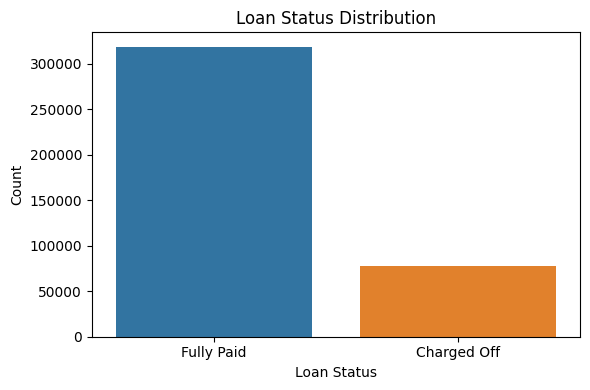

In [14]:
#Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', hue = 'loan_status', data=df)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [15]:
# check the balance of the outcome feature
val_counts  = df['loan_status'].value_counts(normalize = True) * 100
pd.DataFrame(val_counts.round())

proportion
loan_status            
Fully Paid         80.0
Charged Off        20.0

The data is clearly imbalanced. This is a typical scenario when dealing with problems related to loan default, spam or fraud detection. We can expect to do very well in terms of accuracy, but our precision and recall will be the true matrix that our model should be evaluated based on.

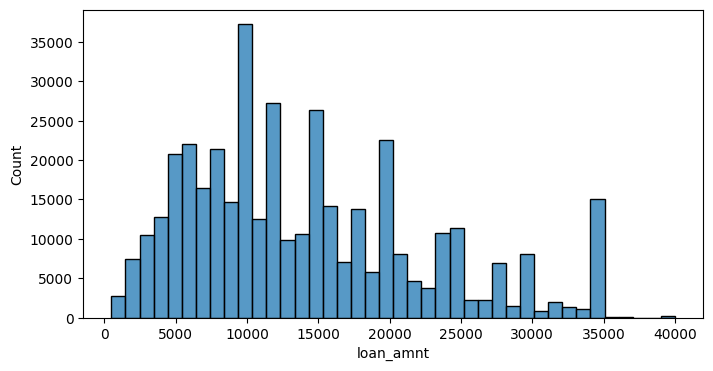

In [16]:
# Inspect the distribution of loan amounts
plt.figure(figsize = (8,4), dpi = 100)
sns.histplot(data = df, x = 'loan_amnt', bins = 40)
plt.show()

In [17]:
# --- Target mapping (edit if your labels differ)
target_map = {
    "Charged Off": 1,
    "Fully Paid": 0,
}
df = df[df["loan_status"].isin(target_map)].copy()
df["target"] = df["loan_status"].map(target_map)


In [18]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [19]:
categorical_cols

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'address']

In [20]:
numerical_cols

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies',
 'target']

In [21]:
df['issue_d'].unique

<bound method Series.unique of 0         Jan-2015
1         Jan-2015
2         Jan-2015
3         Nov-2014
4         Apr-2013
            ...   
396025    Oct-2015
396026    Feb-2015
396027    Oct-2013
396028    Aug-2012
396029    Jun-2010
Name: issue_d, Length: 396030, dtype: object>

In [22]:
# Convert date columns
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
df["earliest_cr_line"] = pd.to_datetime(df.get("earliest_cr_line"),format='%b-%Y', errors='coerce')

In [23]:
df['issue_d']

0        2015-01-01
1        2015-01-01
2        2015-01-01
3        2014-11-01
4        2013-04-01
            ...    
396025   2015-10-01
396026   2015-02-01
396027   2013-10-01
396028   2012-08-01
396029   2010-06-01
Name: issue_d, Length: 396030, dtype: datetime64[ns]

In [24]:
df["earliest_cr_line"].unique()

<DatetimeArray>
['1990-06-01 00:00:00', '2004-07-01 00:00:00', '2007-08-01 00:00:00',
 '2006-09-01 00:00:00', '1999-03-01 00:00:00', '2005-01-01 00:00:00',
 '2005-08-01 00:00:00', '1994-09-01 00:00:00', '1994-06-01 00:00:00',
 '1997-12-01 00:00:00',
 ...
 '1959-06-01 00:00:00', '1962-02-01 00:00:00', '1956-09-01 00:00:00',
 '1960-08-01 00:00:00', '1961-02-01 00:00:00', '1948-01-01 00:00:00',
 '1963-08-01 00:00:00', '1961-10-01 00:00:00', '1962-08-01 00:00:00',
 '1959-08-01 00:00:00']
Length: 684, dtype: datetime64[ns]

In [25]:
# List of numerical columns to visualize
numerical_columns = ["loan_amnt", "int_rate", "installment", "annual_inc", "dti",
    "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc",
    "mort_acc", "pub_rec_bankruptcies"]

In [26]:
# Set seaborn style
sns.set(style="whitegrid")

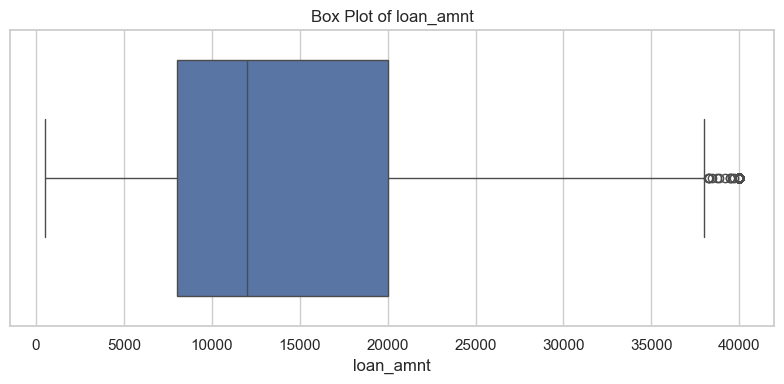

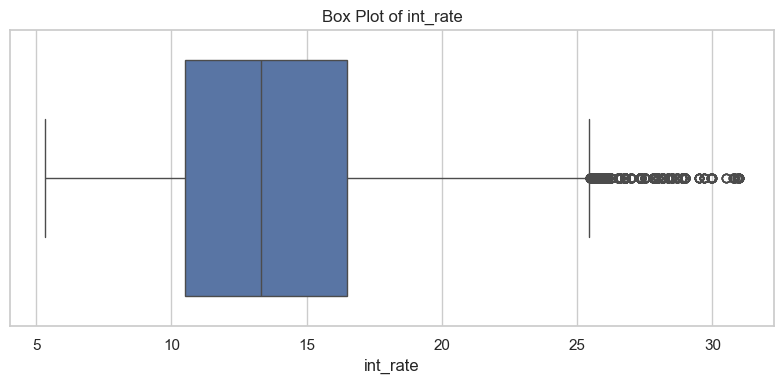

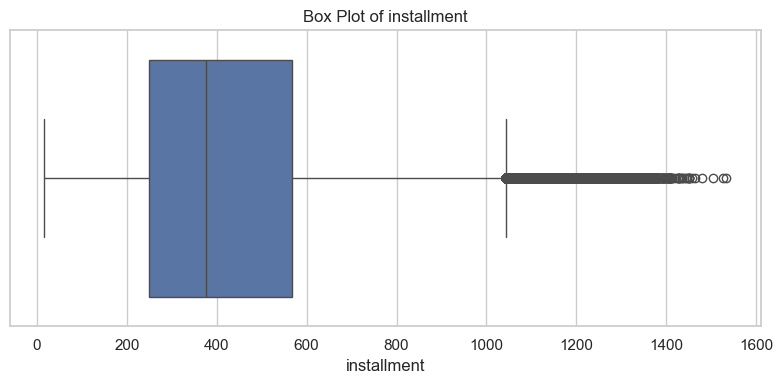

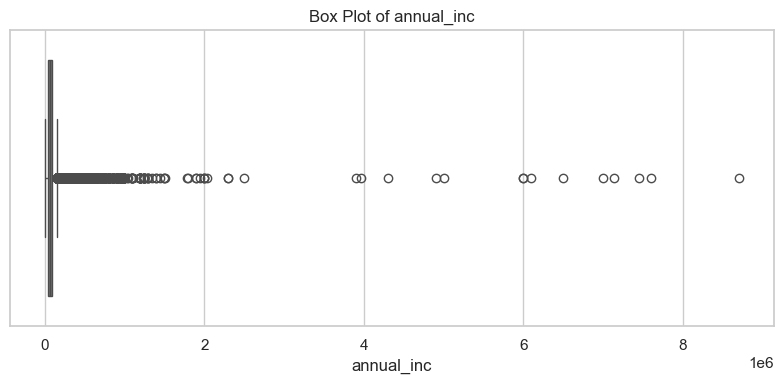

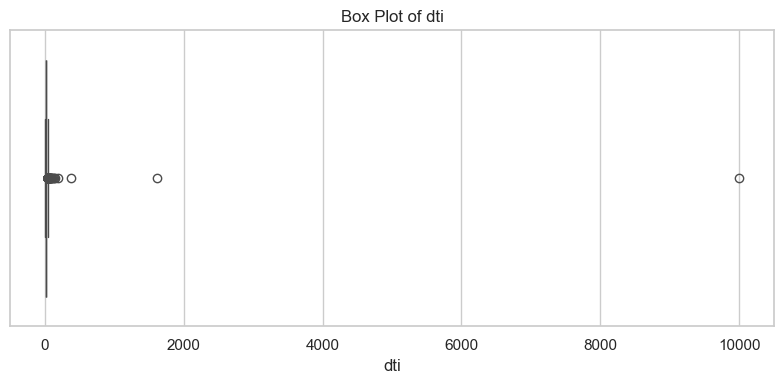

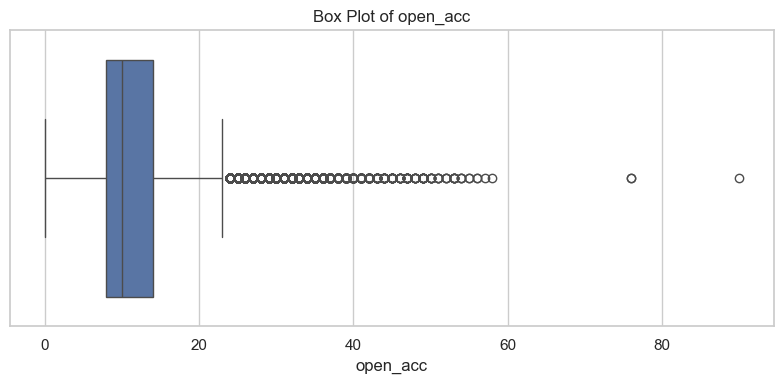

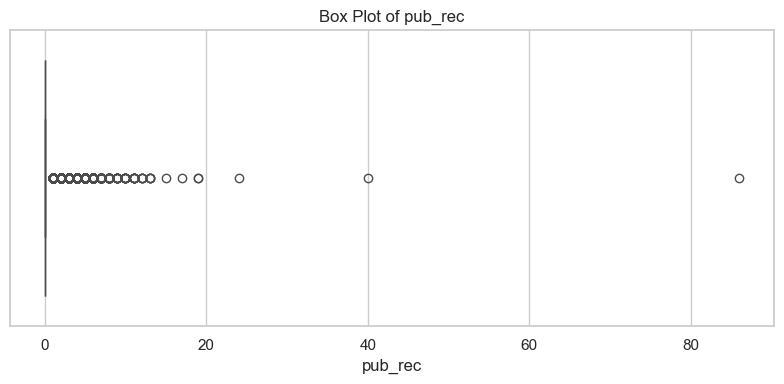

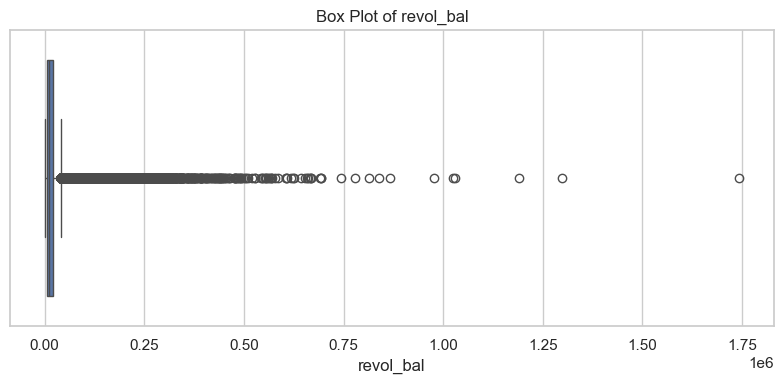

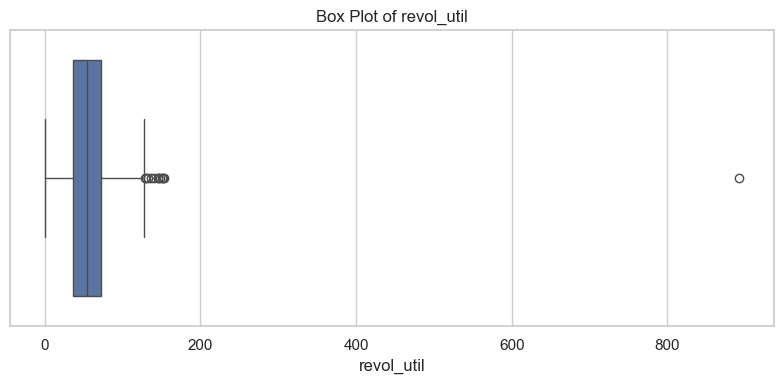

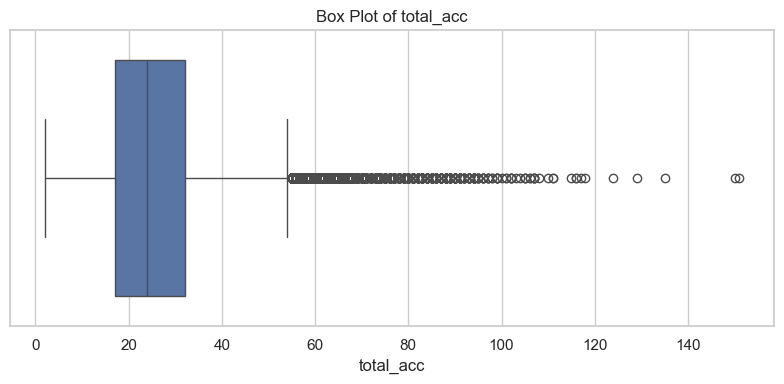

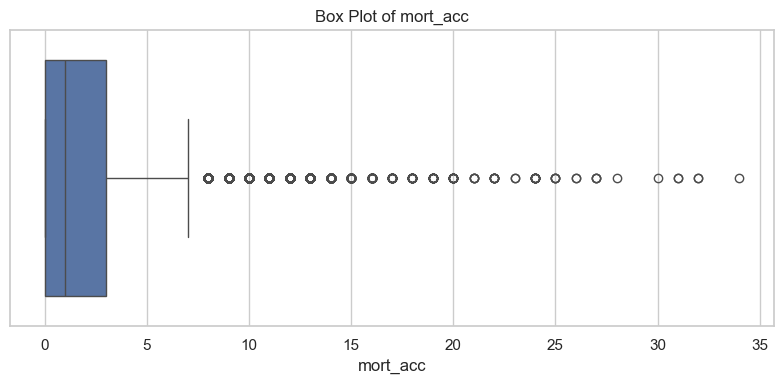

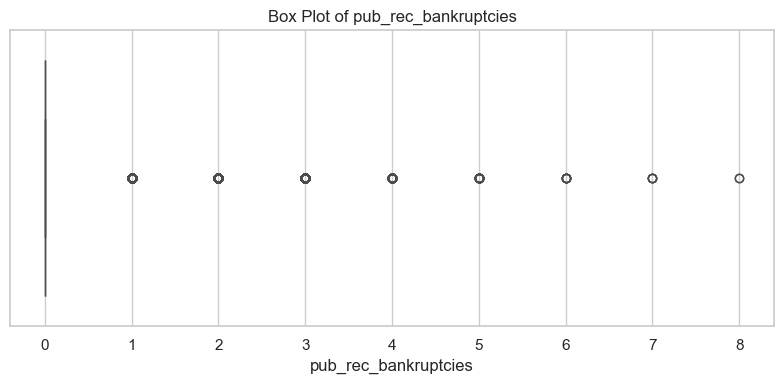

In [27]:
# Generate box plots
for column in numerical_columns:
    if column in df.columns:
        # Box Plot
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[column])
        plt.title(f'Box Plot of {column}')
        plt.xlabel(column)
        plt.tight_layout()
        plt.show()

In [28]:
#(Loan Amount)
#This feature has a relatively symmetrical distribution with moderate outliers at the upper end (up to $40,000), aligning with Lending Club loan caps. Larger loans might carry higher default risk and are likely to be important features in the model.

#(Interest Rate)
#The boxplot is right-skewed, showing that most borrowers receive interest rates between 8% and 20%, with some getting rates as high as 30%. Higher interest rates may signal higher risk profiles and should be analyzed for correlation with defaults.

#(Monthly Loan Installment)
#This distribution is more balanced, with some high-end outliers, indicating that while most borrowers pay reasonable monthly installments, a few loans come with very high repayment burdens. These higher installments could impact default risk, especially if not aligned with income.

#(Annual Income)
#The income variable shows a highly skewed distribution with many high-income outliers, possibly due to self-reporting or rare high earners. Since income is a key predictor in loan approvals, transformation (eg- log scaling) may be needed for model stability.

#(Debt-to-Income Ratio)
#While most values are within a reasonable range, there are a few massive outliers (up to 10,000), likely due to data entry errors or anomalies. These values could distort model training and should be investigated or capped during preprocessing.

#(Number of Open Credit Lines)
#The distribution is moderately skewed right, with the majority of borrowers having fewer than 25 open accounts, and a few extreme outliers with over 80. This suggests the need to treat high open account numbers carefully, as they could indicate either creditworthiness or potential overextension.

#(Public Records)
#Most borrowers have zero or very few public records, but several outliers suggest some borrowers have a high number of derogatory public records. These rare but significant values could strongly influence loan default predictions.

#(Revolving Balance)
#The boxplot shows a heavily right-skewed distribution with a large number of extreme outliers, indicating that while most borrowers have low to moderate revolving balances, a few have exceptionally high balances. This skew may significantly affect credit risk modeling if not normalized or capped.

#(Public Record Bankruptcies)
#This variable is highly skewed, with the vast majority of borrowers having zero bankruptcies and a small number showing up to 8, making them distinct outliers. These rare occurrences could be strong indicators of risk and are important features for credit default prediction models.

#(Number of Mortgage Accounts)
#The distribution is moderately right-skewed with a few high outliers. Most borrowers have fewer than 6 mortgage accounts, and values beyond that may represent either higher asset ownership or over-leveraging, affecting creditworthiness differently based on context.

#(Total Number of Credit Accounts)
#Most borrowers have between 10 and 60 accounts, with outliers reaching well above 100, suggesting varying credit histories and financial behaviors. Extreme outliers may require capping to prevent distortion in model training.

#(Revolving Credit Utilization %)
#While most borrowers fall within a realistic utilization range (under 100%), there are a few extreme outliers above 800%, likely due to reporting or data quality issues. Such anomalies could strongly bias model performance and should be handled during data preprocessing.

In [29]:
# Define the categorical columns to visualize
categorical_columns = ["term", "grade", "sub_grade", "emp_length",
    "home_ownership", "verification_status", "loan_status", "purpose", "initial_list_status", "application_type"]

In [30]:
# Set the plot style
sns.set(style="whitegrid")

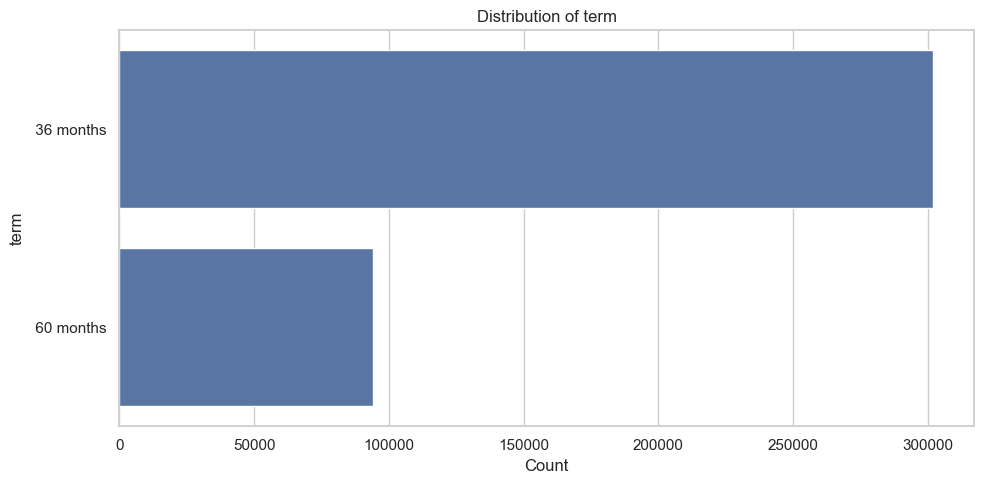

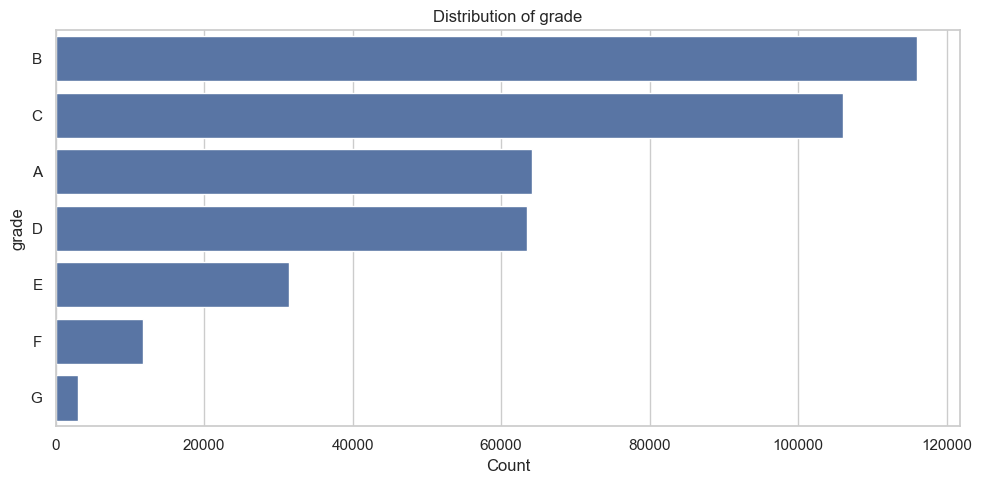

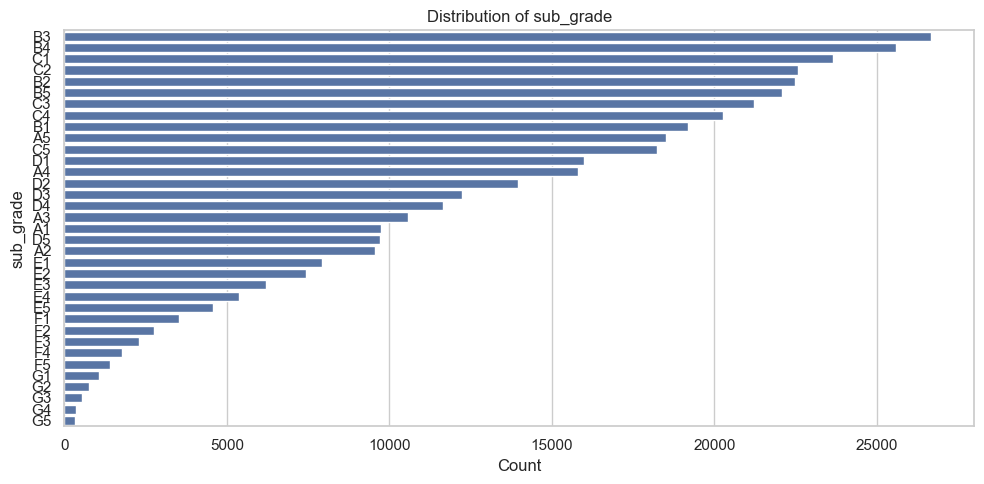

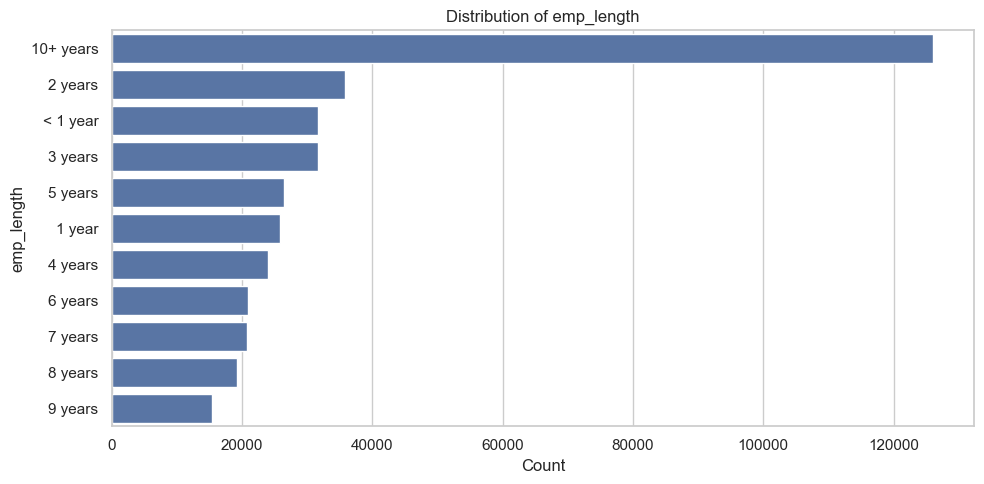

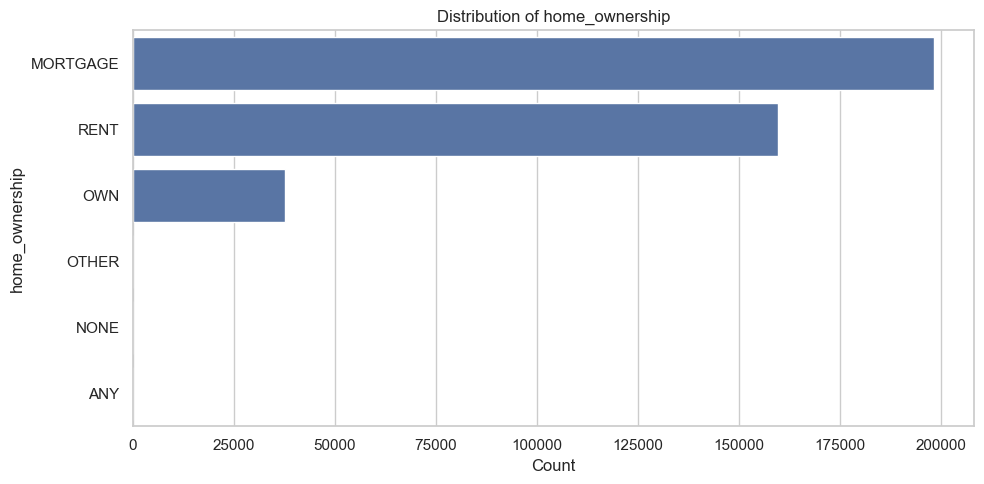

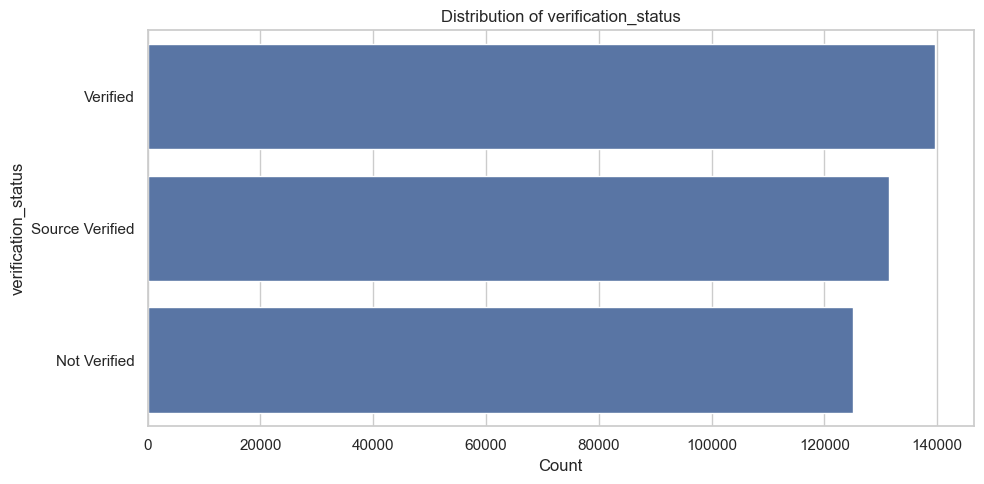

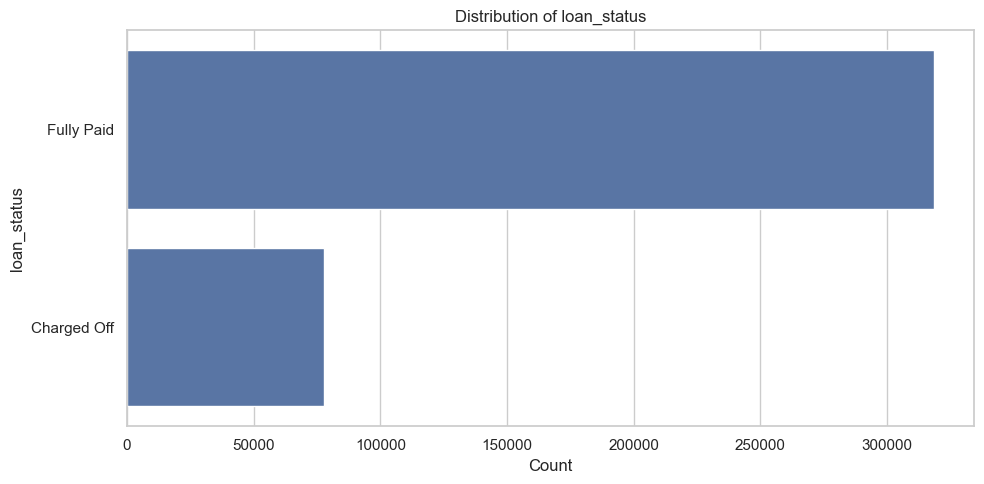

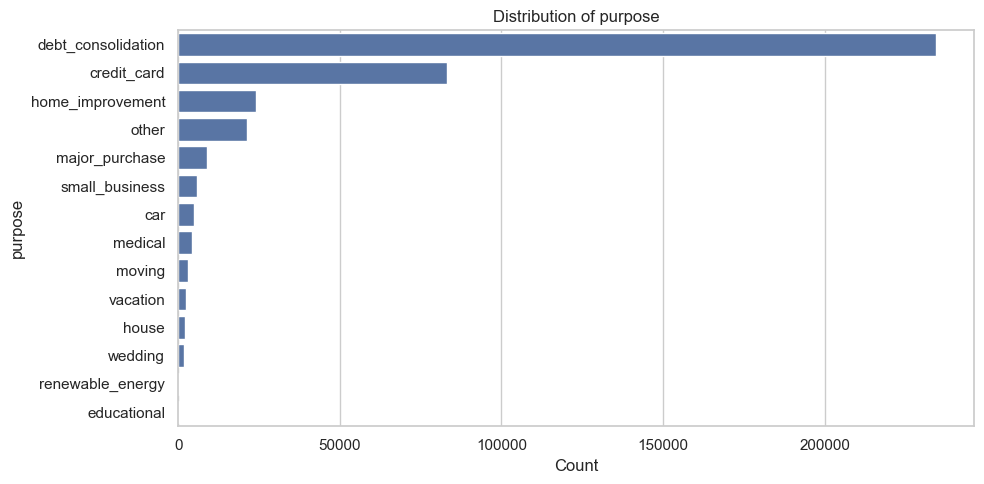

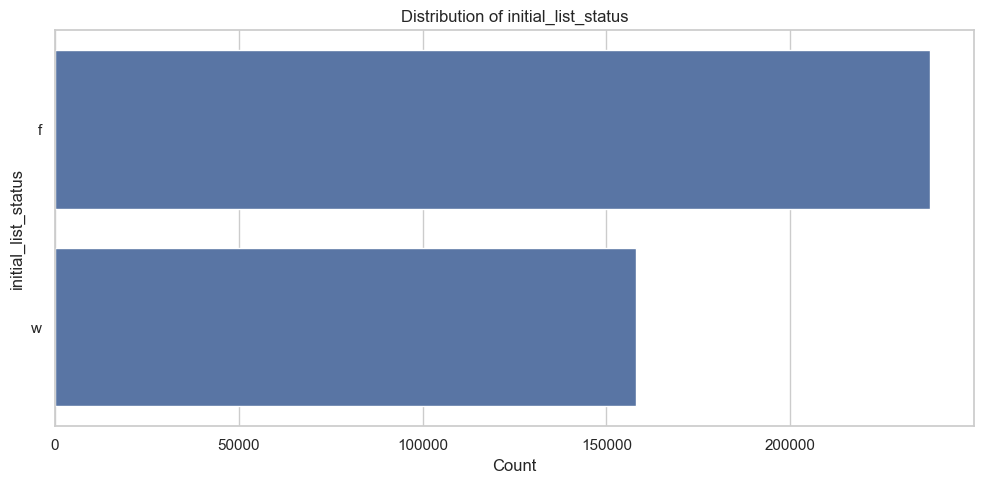

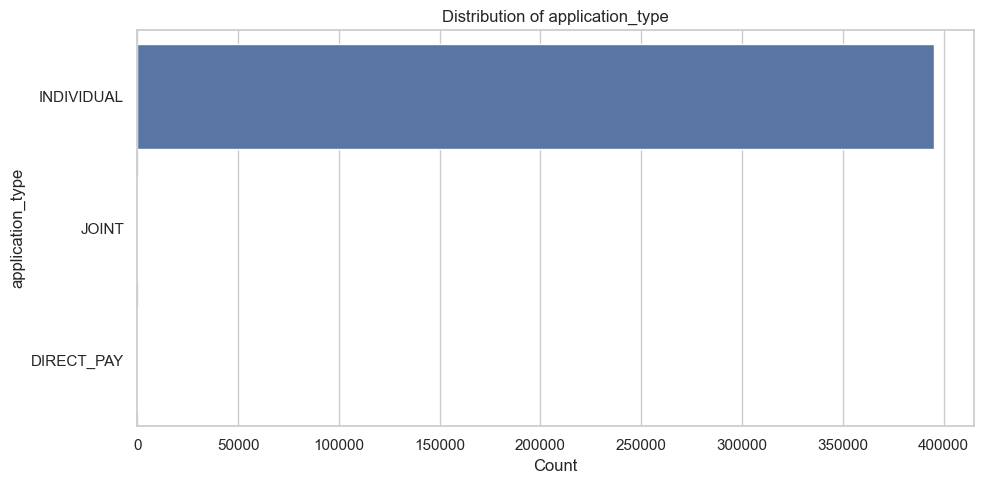

In [31]:
# Generate and display bar plots for each categorical column
for column in categorical_columns:
    if column in df.columns:
        plt.figure(figsize=(10, 5))
        order = df[column].value_counts().index
        sns.countplot(data=df, y=column, order=order)
        plt.title(f'Distribution of {column}')
        plt.xlabel('Count')
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

In [32]:
#Distribution of purpose
#This shows that most loans are taken for debt consolidation and credit card repayment, which dominate the dataset. These categories indicate financial restructuring, often linked to moderate to high risk. This variable is useful for feature engineering (eg- grouping rare purposes as "Other") and helps interpret risk profiles based on loan intent.

#Distribution of loan status
#This is the target variable, with "Fully Paid" being far more common than "Charged Off," highlighting a class imbalance problem. This imbalance must be addressed in preprocessing using resampling or class-weight techniques, as it can bias model predictions towards the majority class.

#Distribution of verification status
#This feature indicates whether income was verified. Its balanced distribution makes it a useful categorical feature, especially since unverified income could signal higher default risk. It should be one-hot encoded and evaluated for correlation with loan_status.

#Distribution of home_ownership
#Most borrowers either rent or have a mortgage, with very few owning their homes outright. Homeownership status can act as a proxy for financial stability and asset backing, which is relevant in risk assessment. Encode this feature carefully, possibly grouping sparse classes (eg- ANY, NONE, OTHER) into a general "Unknown/Other" category.

#Distribution of emp_length
#This feature captures job tenure, which may indicate employment stability and repayment reliability. “10+ years” is most common, but the distribution is varied, so this feature should be ordinal encoded to preserve its rank order and meaning for models.

#Distribution of sub_grade
#This is a fine-grained credit grade derived from Lending Club's internal scoring system. It has strong predictive potential, but is ordinal and should be label encoded to preserve the ordering (eg- A1 > A2 > … > G5). Also valuable for SHAP/LIME as it’s easily explainable.

#Distribution of grade
#This is a broader grouping of sub_grade, ranging from A (best) to G (worst). It's highly correlated with int_rate, and can serve as a strong signal of risk. Use either grade or sub_grade (not both, to avoid multicollinearity), depending on model needs and explainability goals.

#Distribution of term
#Loan terms are either 36 months or 60 months, which affects risk and monthly installment size. Longer terms may increase default risk due to prolonged repayment periods. This binary feature should be encoded and considered in interaction with loan_amnt and installment.

#Distribution of application_type
#The vast majority of loans are individual applications, with very few joint or direct pay applications. This class imbalance may limit the predictive value of this feature, but it should still be retained and one-hot encoded. If joint applications show different default behavior, this could enhance fairness-related explainability.

#Distribution of initial_list_status
#There are two categories: f (likely “fully funded”) and w (likely “waiting” or “watchlist”), with a higher frequency of f. While not directly interpretable without business context, this feature might relate to the loan's initial risk classification or funding stage and should be encoded and analyzed for correlation with defaults.

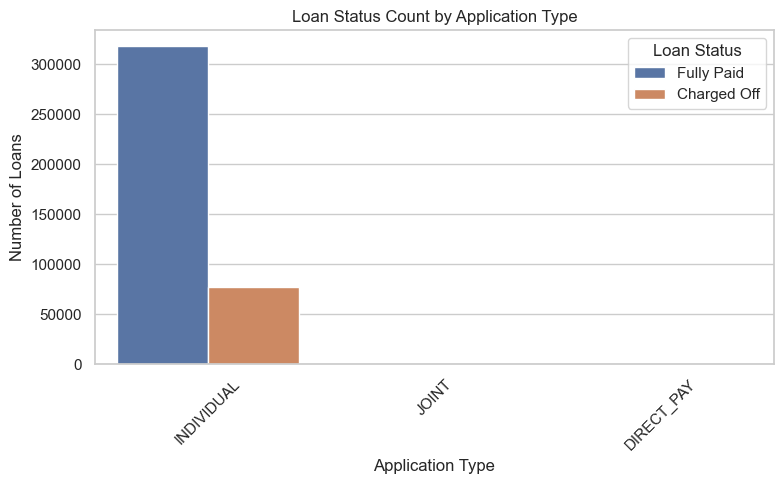

In [33]:
# SADLY APPLICATION TYPE WONT TELL US MUCH!!
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='application_type', hue='loan_status')

plt.title('Loan Status Count by Application Type')
plt.xlabel('Application Type')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

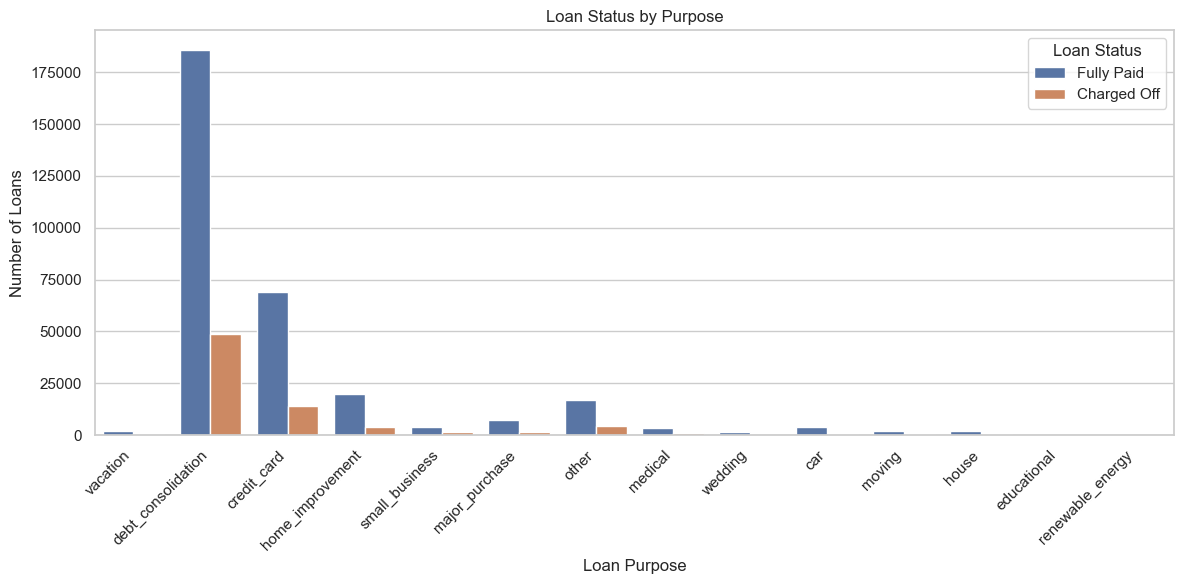

In [34]:
# PURPOSE TELLS US SOMETHING BUT WONT TELL US TO SEGREGATE THE PEOPLE WHO PAYS AND WONT PAY!!
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='purpose', hue='loan_status')

plt.title('Loan Status by Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

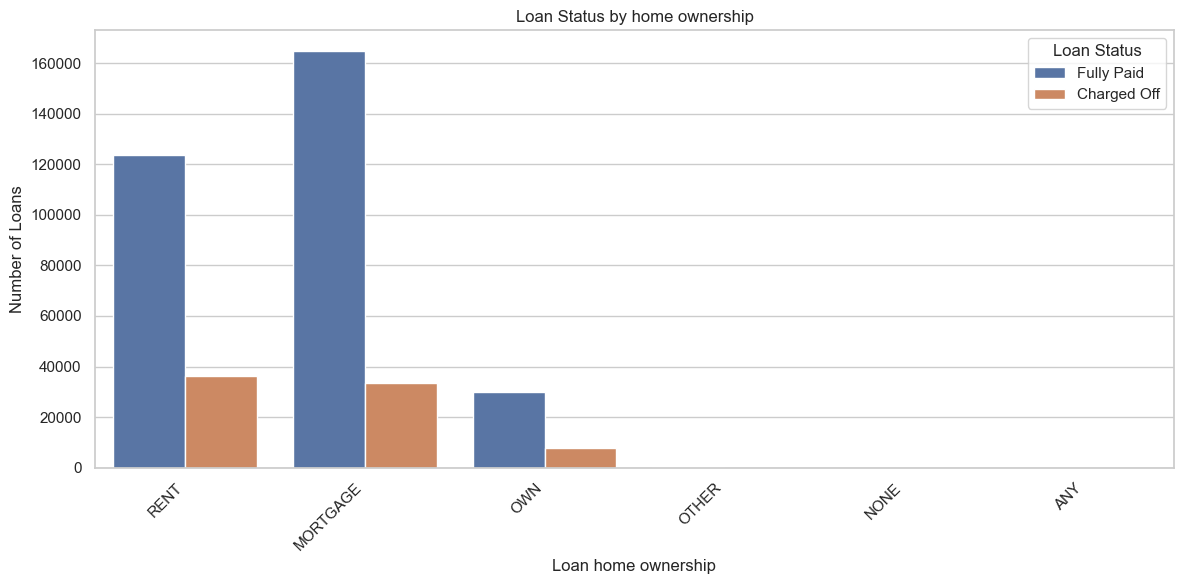

In [35]:
# OK HAVE A HOME OR NOT ALSO AFFECT THE PAY CRITERIA, HERE LETS SEE IF HOME OWNER AND NOT HOME OWNER PAYS OR NOT!!

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='home_ownership', hue='loan_status')

plt.title('Loan Status by home ownership')
plt.xlabel('Loan home ownership')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

# INTERESTING, PEOPLE WHO RENT THE HOUSE HAVE HIGHER CHANCE OF NOT PAYING THE LOAN WHEN YOU LOOK AT THE RATIO!! LOGICAL!!

In [36]:
# ----- Correlation Matrix for Numeric Features -----
numeric_df = df.select_dtypes(include='number')

In [37]:
# Compute correlation matrix
correlation_matrix = numeric_df.corr()

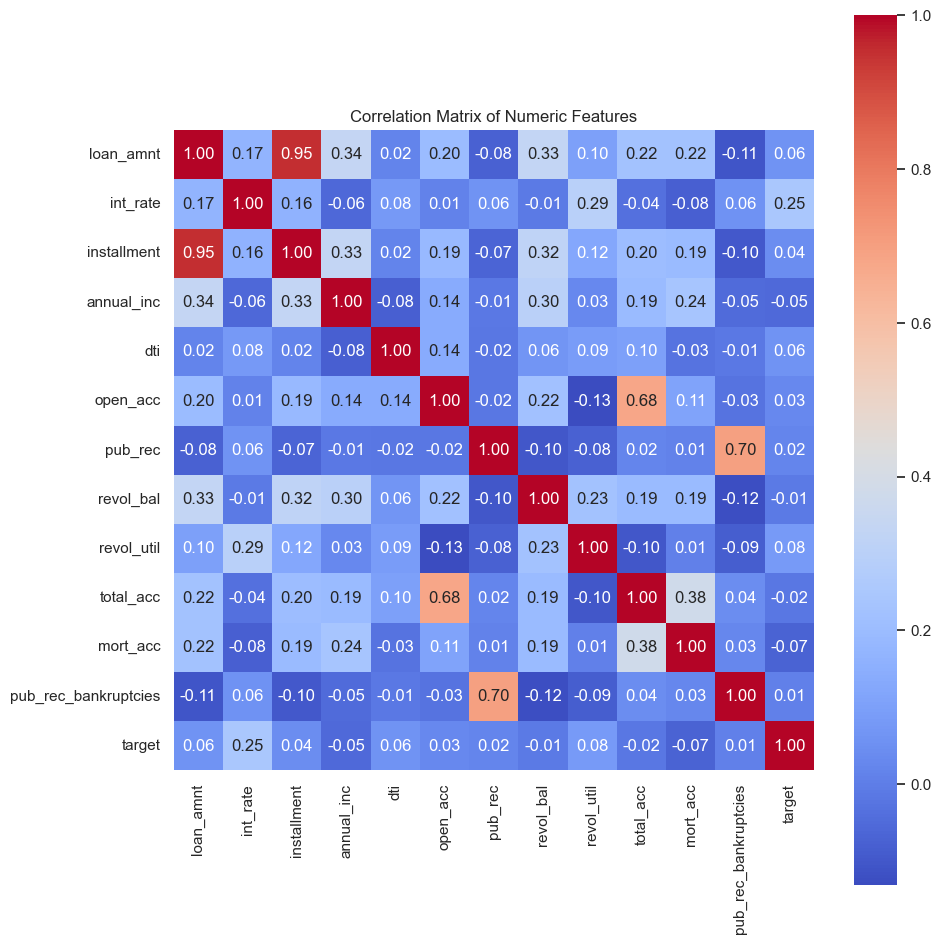

In [38]:
# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

loan_amnt, installment, and int_rate show strong positive correlations, indicating overlapping influence on borrower risk and repayment burden. Weak or no correlation between annual_inc, dti, and loan features suggests they provide distinct, non-redundant signals for default prediction.

In [39]:
# Create the helper function 
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [40]:
feat_info('installment')

The monthly payment owed by the borrower if the loan originates.


In [41]:
feat_info('loan_amnt')

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


It make sense to be highly correlated, because the higher loans means higher installments and vise versa. This relationship is governed by a fixed formula.

In [42]:
# bivariate analysis

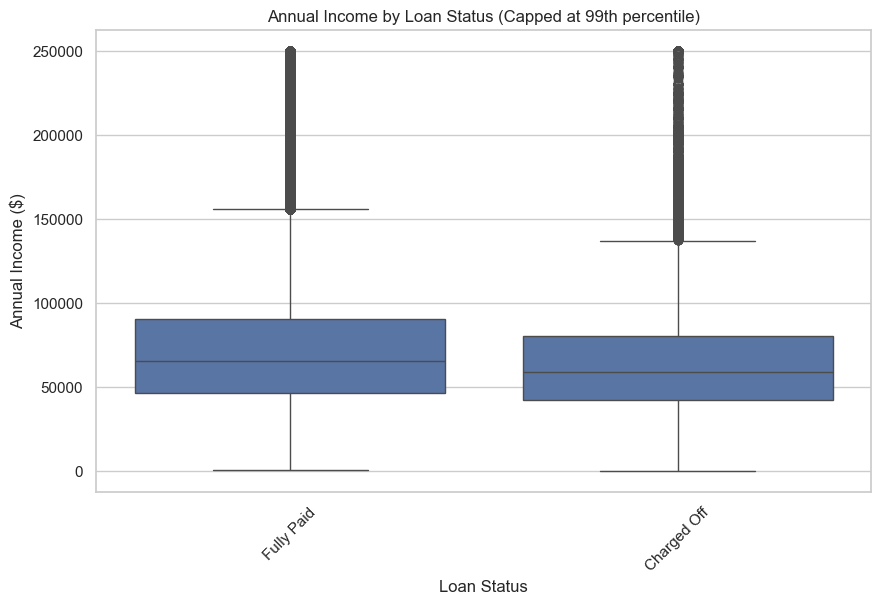

In [43]:
# NOW ANNUAL INCOME PLAYS A HUGE FACTOR IN THE REAL WORLD BUT IS IT ACTUALLY ? LETS CHECK IT OUT!!

temp_income = df['annual_inc'].clip(upper=df['annual_inc'].quantile(0.99))
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['loan_status'], y=temp_income, data=df)
plt.title('Annual Income by Loan Status (Capped at 99th percentile)')
plt.ylabel('Annual Income ($)')
plt.xlabel('Loan Status')
plt.xticks(rotation=45)
plt.show()

# ON AVERAGE PEOPLE WHO DONT PAY OFF THE LOAN HAVE THE LOWER INCOME THAN THE PEOPLE WHO PAY OFF THEIR LOAN, INTERESTING!! BUT DOESNT TELL MUCH!!

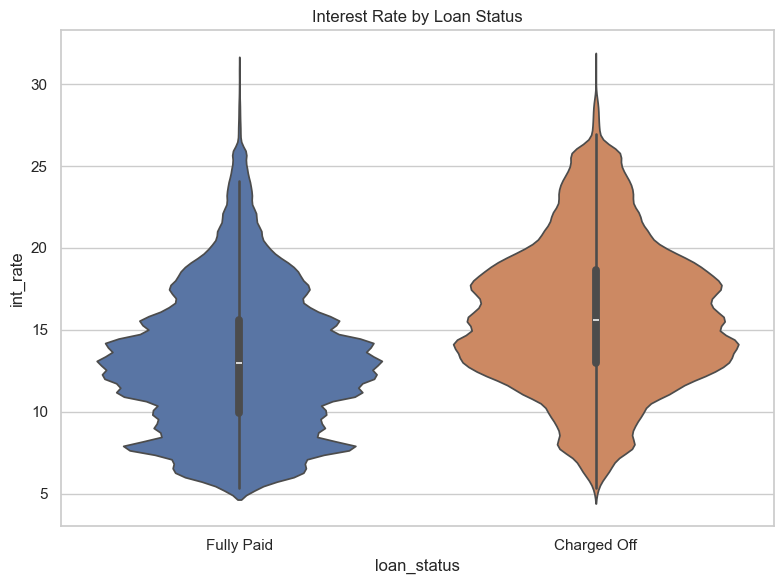

In [44]:
# 3. DTI vs. Loan Status
plt.figure(figsize=(8, 6))
sns.violinplot(data=df[df['dti'] < 50], x='loan_status', hue ="loan_status", y='int_rate')
plt.title('Interest Rate by Loan Status')
plt.tight_layout()
plt.show()

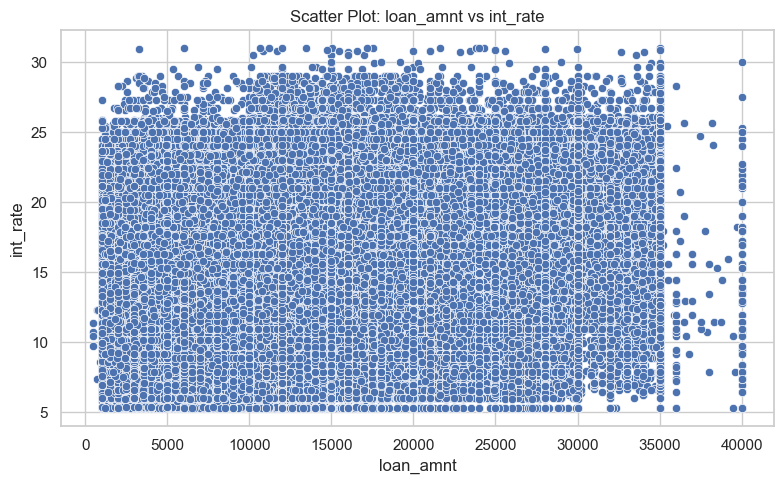

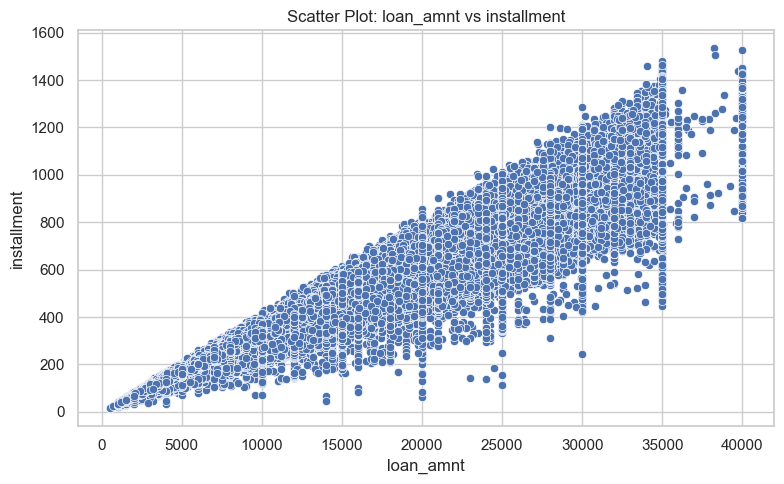

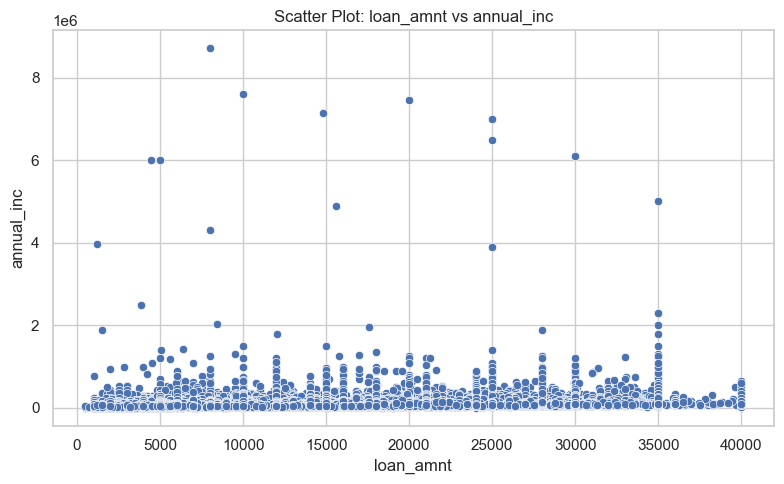

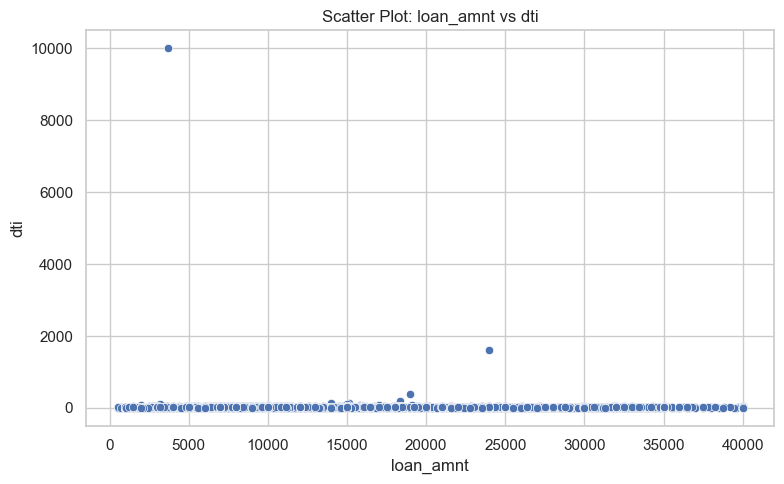

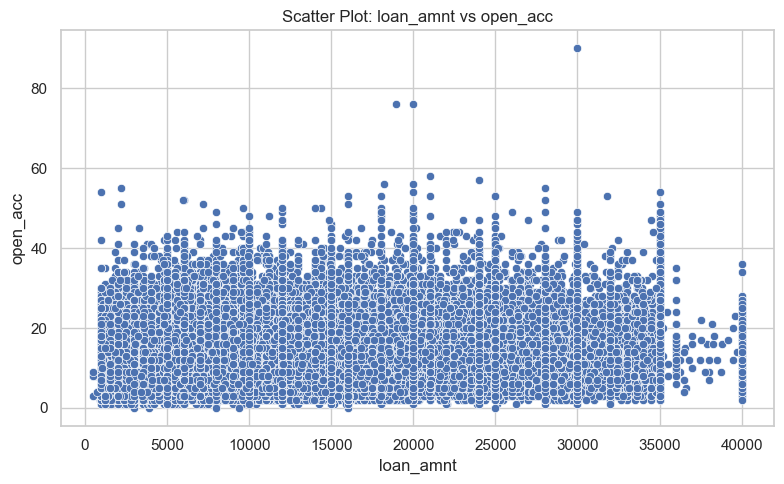

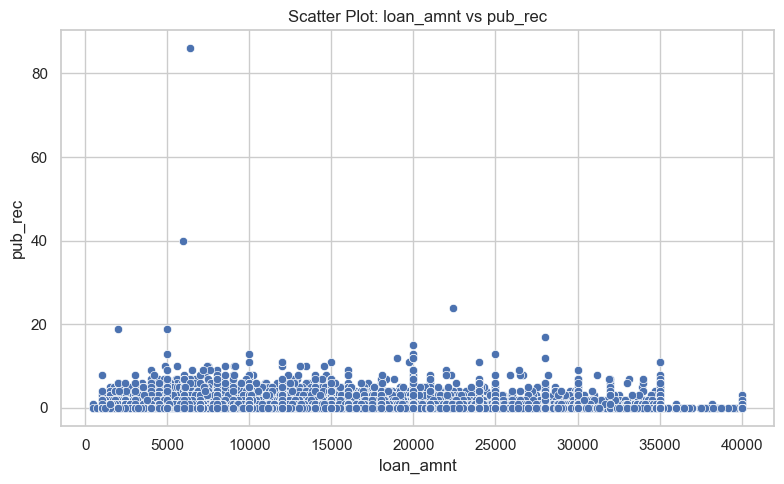

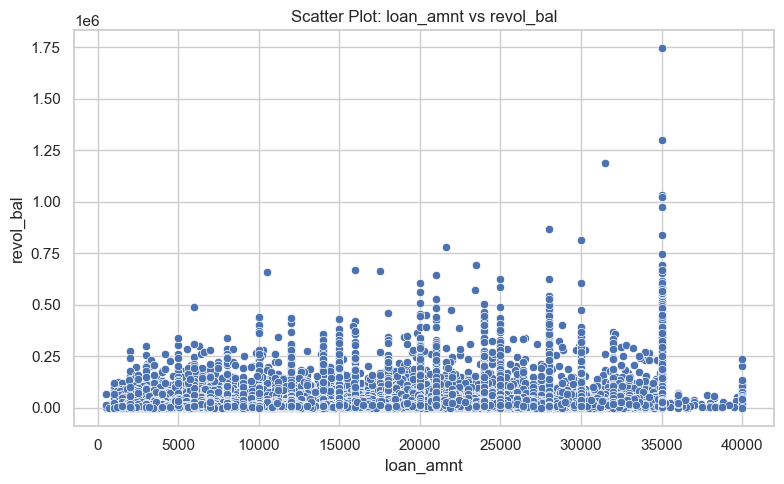

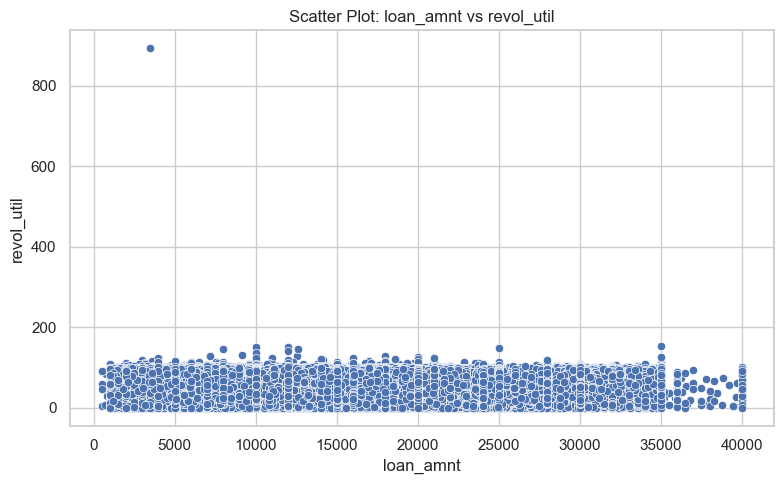

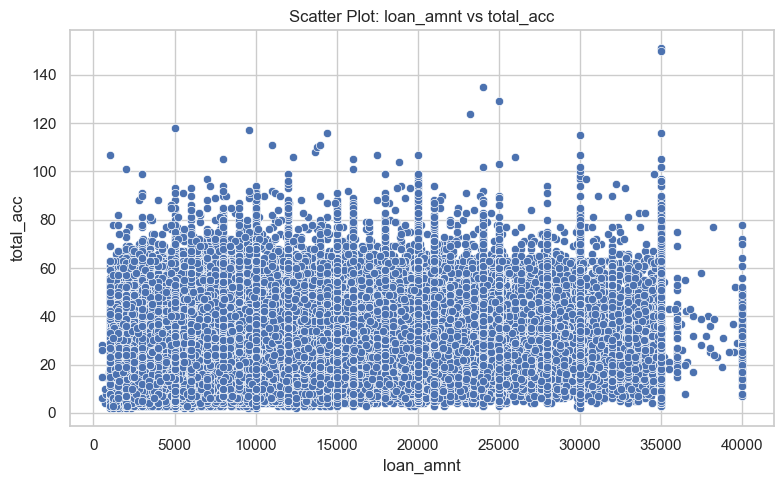

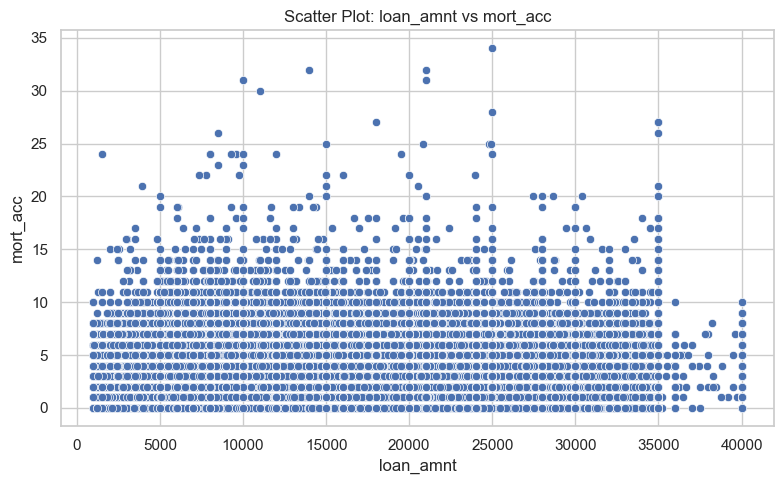

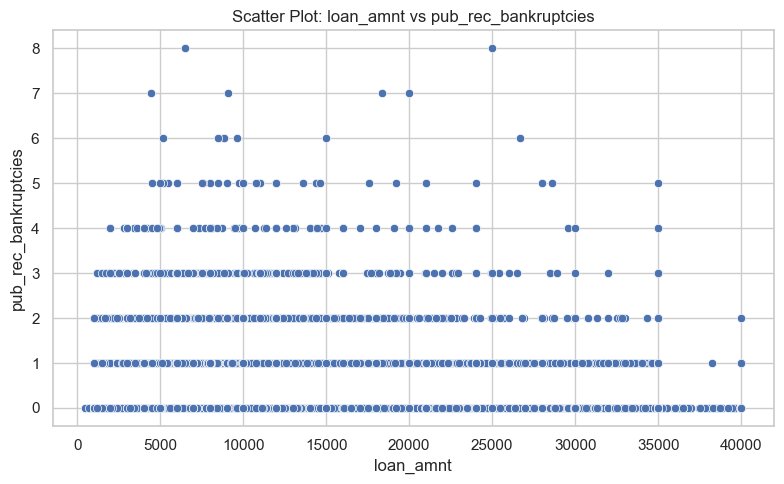

In [45]:
# Scatter Plot against loan_amnt
for column in numerical_columns:
    if column != "loan_amnt":
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=df["loan_amnt"], y=df[column])
        plt.title(f'Scatter Plot: loan_amnt vs {column}')
        plt.xlabel("loan_amnt")
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

In [46]:
#loan_amnt vs revol_bal
#There is no clear linear correlation, but we see some outliers with extremely high revolving balances. This indicates that high loan amounts do not necessarily mean high credit card debt, suggesting these two features may provide distinct information for default prediction.

#loan_amnt vs pub_rec
#Most borrowers have very few or no public records regardless of loan amount. A few extreme outliers exist, but the overall relationship is weak, which shows pub_rec might act as a binary risk flag rather than a continuous predictor.

#loan_amnt vs open_acc
#There is no clear correlation between loan amount and the number of open accounts. Borrowers across all loan sizes exhibit a wide range of open accounts, meaning open_acc should be treated as an independent credit history variable in the model.

#loan_amnt vs dti
#There is no visible correlation, but a few extreme dti outliers (especially near 10,000) suggest erroneous or rare values. These outliers should be handled in preprocessing, and dti remains a critical affordability indicator.

#loan_amnt vs annual_inc
#The relationship appears scattered, with high-income individuals applying for a wide range of loan amounts. Some extreme outliers in income suggest the need for log transformation; however, this feature still provides vital information for creditworthiness.

#loan_amnt vs installment
#There is a strong linear relationship between loan amount and installment, as expected. These two are mechanically related, so including both in the model may introduce multicollinearity — one can be used to derive affordability ratios.

#loan_amnt vs int_rate
#The scatter is relatively uniform, indicating that loan amount and interest rate are not strongly correlated. This suggests int_rate is likely influenced more by credit risk (e.g., grade) than loan size, which aligns with lending practices.

#dti vs loan_status
#The boxplot shows that extreme DTI outliers are more prevalent among "Charged Off" loans, supporting the idea that high debt burden increases default risk. Cleaning these values and using DTI in SHAP analysis could reveal critical risk insights.

#annual_inc vs loan_status (log scale)
#On a log scale, both "Fully Paid" and "Charged Off" loans span similar income ranges, but charged-off loans show slightly more outliers at the low-income end. This supports the use of annual_inc in affordability-based risk models, especially when normalized.

#loan_amnt vs grade
#Higher credit grades (A, B) tend to be associated with lower loan amounts, while lower grades (E, F, G) show wider and higher loan distributions. This confirms the inverse relationship between credit grade and loan amount, reinforcing both as strong predictors for credit scoring.

#loan_amnt vs pub_rec_bankruptcies
#This scatter plot shows that most borrowers have zero or one bankruptcy, and there’s no clear pattern between bankruptcy count and loan amount. While rare, higher bankruptcy counts may act as strong risk indicators and should be flagged for SHAP/LIME interpretability.

#loan_amnt vs mort_acc
#There is a dense spread across mortgage account counts for all loan amounts, with no clear correlation. However, borrowers with many mortgage accounts may reflect different financial profiles (wealth or over-leverage) and should be retained for modeling.

#loan_amnt vs total_acc
#The plot shows a wide spread of total accounts across loan amounts, suggesting no direct relationship. Since total_acc reflects credit experience, it remains an independent predictor of reliability in the credit scoring model.

#loan_amnt vs revol_util
#There’s no strong visible correlation, and one clear outlier shows an abnormally high utilization (around 900%), likely a data error. Revolving utilization should be cleaned (clip above 100%) and retained as a vital indicator of borrower risk level.

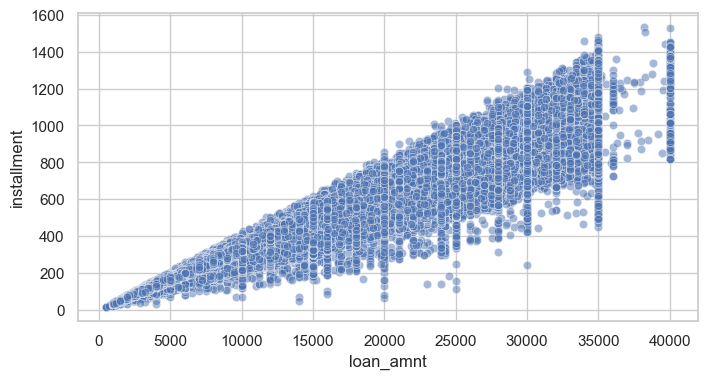

In [47]:
# Inspect the relationship between loan amount and installment
plt.figure(figsize = (8,4), dpi = 100)
sns.scatterplot(data = df, x = 'loan_amnt', y = 'installment', alpha = 0.5)
plt.show()

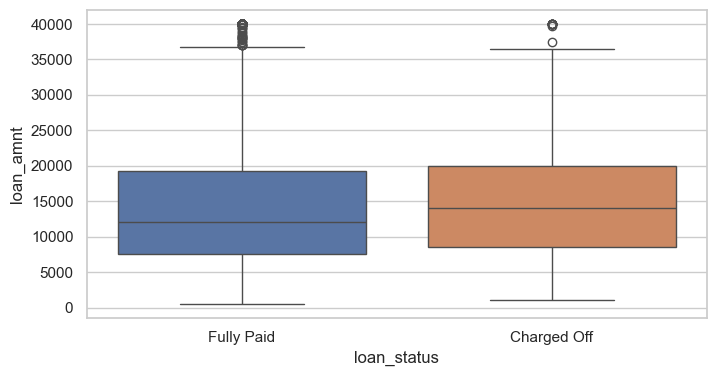

In [48]:
# The relationship between the loan_status and the Loan Amount
plt.figure(figsize = (8,4), dpi = 100)
sns.boxplot(x='loan_status',y='loan_amnt',hue ="loan_status",data=df)
plt.show()

In [49]:
#Calculate the summary statistics for the loan amount, grouped by the loan_status.
df.groupby('loan_status')['loan_amnt'].describe().round()

count     mean     std     min     25%      50%      75%  \
loan_status                                                                
Charged Off   77673.0  15126.0  8505.0  1000.0  8525.0  14000.0  20000.0   
Fully Paid   318357.0  13867.0  8302.0   500.0  7500.0  12000.0  19225.0   

                 max  
loan_status           
Charged Off  40000.0  
Fully Paid   40000.0

The loan amount is higher we have a slight increase in the likelihood of being charged off.
This makes sense, it is often harder to repay larger loans than smaller loans

In [50]:
#unique possible grade
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [51]:
sorted(df['sub_grade'].unique())

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5']

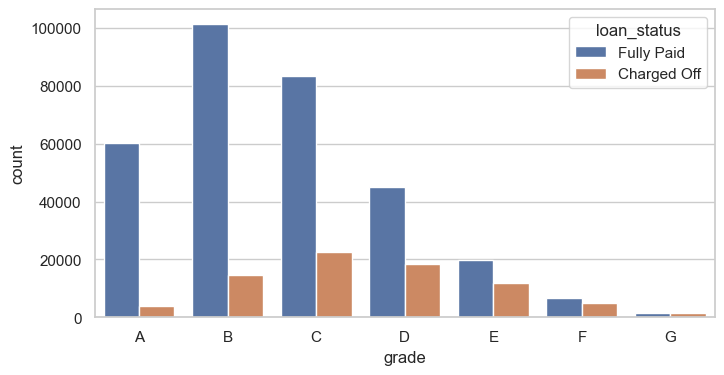

In [52]:
#a countplot per grade. Set the hue to the loan_status label.
order = sorted(df['grade'].unique())
plt.figure(figsize = (8,4), dpi = 100)
sns.countplot(x='grade',data=df,hue='loan_status', order = order)
plt.show()

C:\Users\kurha\AppData\Local\Temp\ipykernel_18536\4060295672.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sub_grade',data=df,order = order, palette='coolwarm')


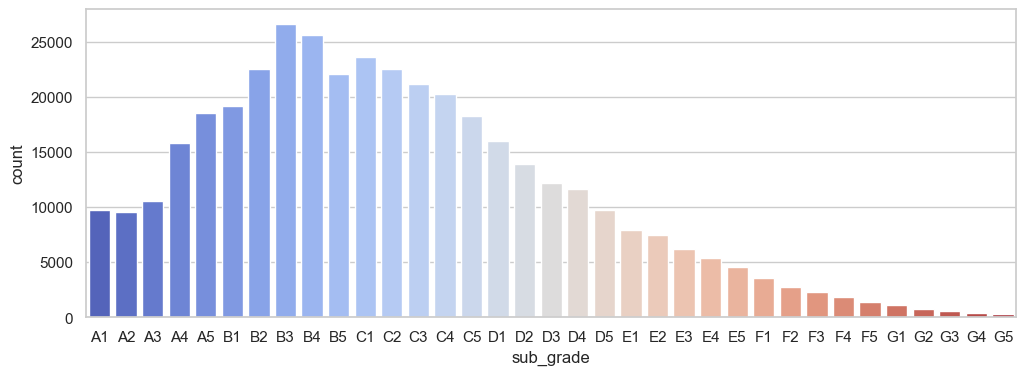

In [53]:
# Display a count plot per subgrade
plt.figure(figsize=(12,4), dpi = 100)
order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = order, palette='coolwarm')
plt.show()

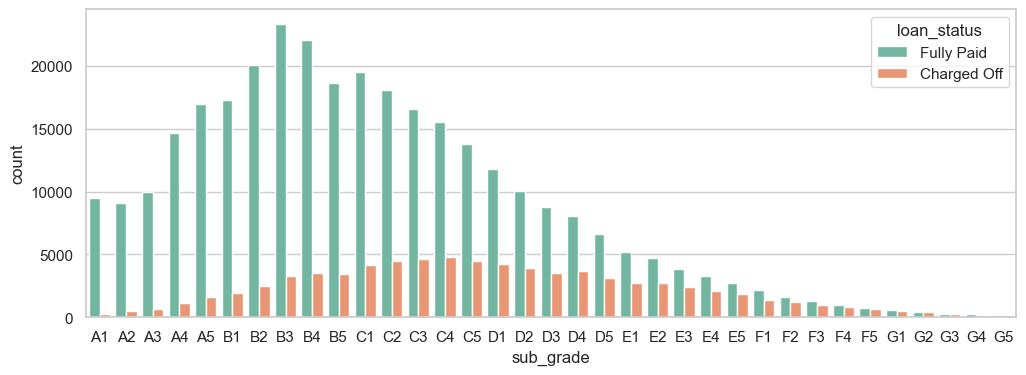

In [54]:
#countplot per sub_grade. Set the hue to the loan_status label.
order = sorted(df['sub_grade'].unique())
plt.figure(figsize = (12,4), dpi = 100)
sns.countplot(x='sub_grade',data=df,hue='loan_status', order = order, palette='Set2')
plt.show()

In [55]:
#It is obvious that F and G grades have a high default rate.
#We will need to have a closer look at them.

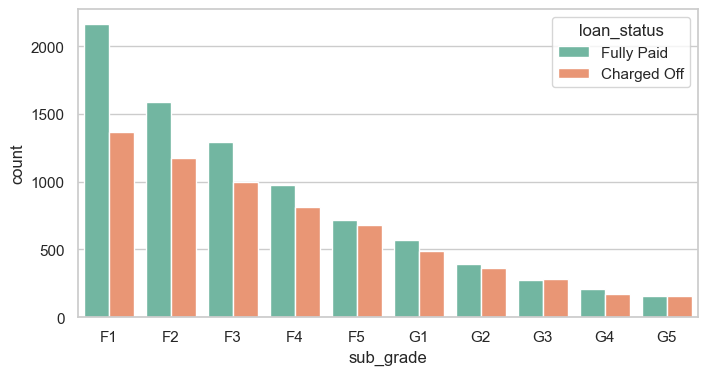

In [56]:
# Zoom in for F and G
filtered_f_g = df[(df.grade == 'F') | (df.grade == 'G')]
order = sorted(filtered_f_g['sub_grade'].unique())
plt.figure(figsize = (8,4), dpi = 100)
sns.countplot(x='sub_grade', data=filtered_f_g, hue='loan_status', order = order, palette='Set2')
plt.show()

In [57]:
#Here the sub grade is G5: the probability is default with almost 50%

In [58]:
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select numerical features that may contain outliers
features = ['loan_amnt', 'annual_inc', 'dti', 'revol_util']

In [59]:
# Step 2: Drop rows with missing values in those features (for this step)
df_anomaly = df[features].dropna()

In [60]:
# Step 3: Run Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
df_anomaly['anomaly_flag'] = iso.fit_predict(df_anomaly)
df['anomaly_flag'] = -1  # Default
df.loc[df_anomaly.index, 'anomaly_flag'] = df_anomaly['anomaly_flag']

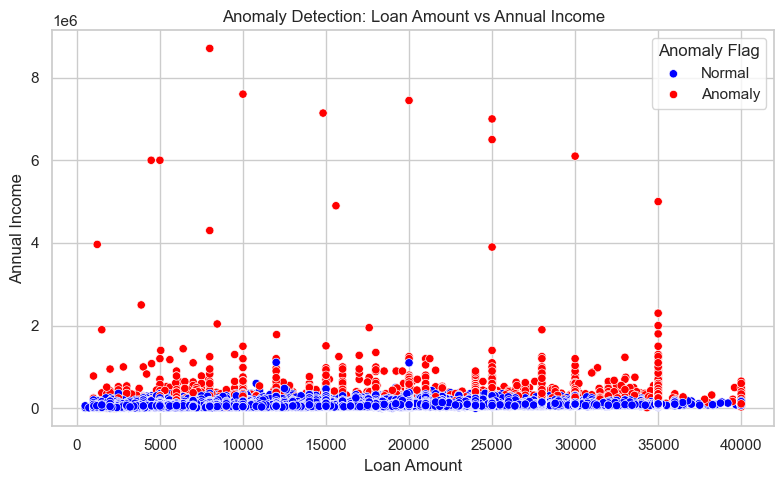

In [61]:
# Step 5: Plot to visualize anomalies
plt.figure(figsize=(8, 5))
sns.scatterplot(x='loan_amnt', y='annual_inc', data=df, hue='anomaly_flag', palette={1: 'blue', -1: 'red'})
plt.title('Anomaly Detection: Loan Amount vs Annual Income')
plt.xlabel('Loan Amount')
plt.ylabel('Annual Income')
plt.legend(title='Anomaly Flag', labels=['Normal', 'Anomaly'])
plt.tight_layout()
plt.show()

In [62]:
df = df[df['anomaly_flag'] == 1].copy()

In [63]:
print(df['anomaly_flag'].value_counts())

anomaly_flag
1    391796
Name: count, dtype: int64


In [64]:
# Sanity checks with a conditin for anomaly removed value
df[df['annual_inc'] > 1_000_000]

loan_amnt        term  int_rate  installment grade sub_grade  \
190684    12000.0   36 months     11.47       395.55     B        B5   
377460    20000.0   36 months      7.89       625.72     A        A5   

                            emp_title emp_length home_ownership  annual_inc  \
190684           Citrix Administrator    4 years           RENT   1110000.0   
377460  Senior Vice President Trading  10+ years           RENT   1100000.0   

        ... revol_bal revol_util total_acc initial_list_status  \
190684  ...   57587.0       45.3      26.0                   w   
377460  ...   13274.0       53.7      30.0                   w   

       application_type  mort_acc pub_rec_bankruptcies  \
190684       INDIVIDUAL       0.0                  0.0   
377460       INDIVIDUAL       4.0                  0.0   

                                          address  target  anomaly_flag  
190684  1052 Torres Port\r\nSandraville, NY 30723       0             1  
377460         PSC 8764, Box 1994\r\nAPO AE 00813       0             1  

[2 rows x 29 columns]

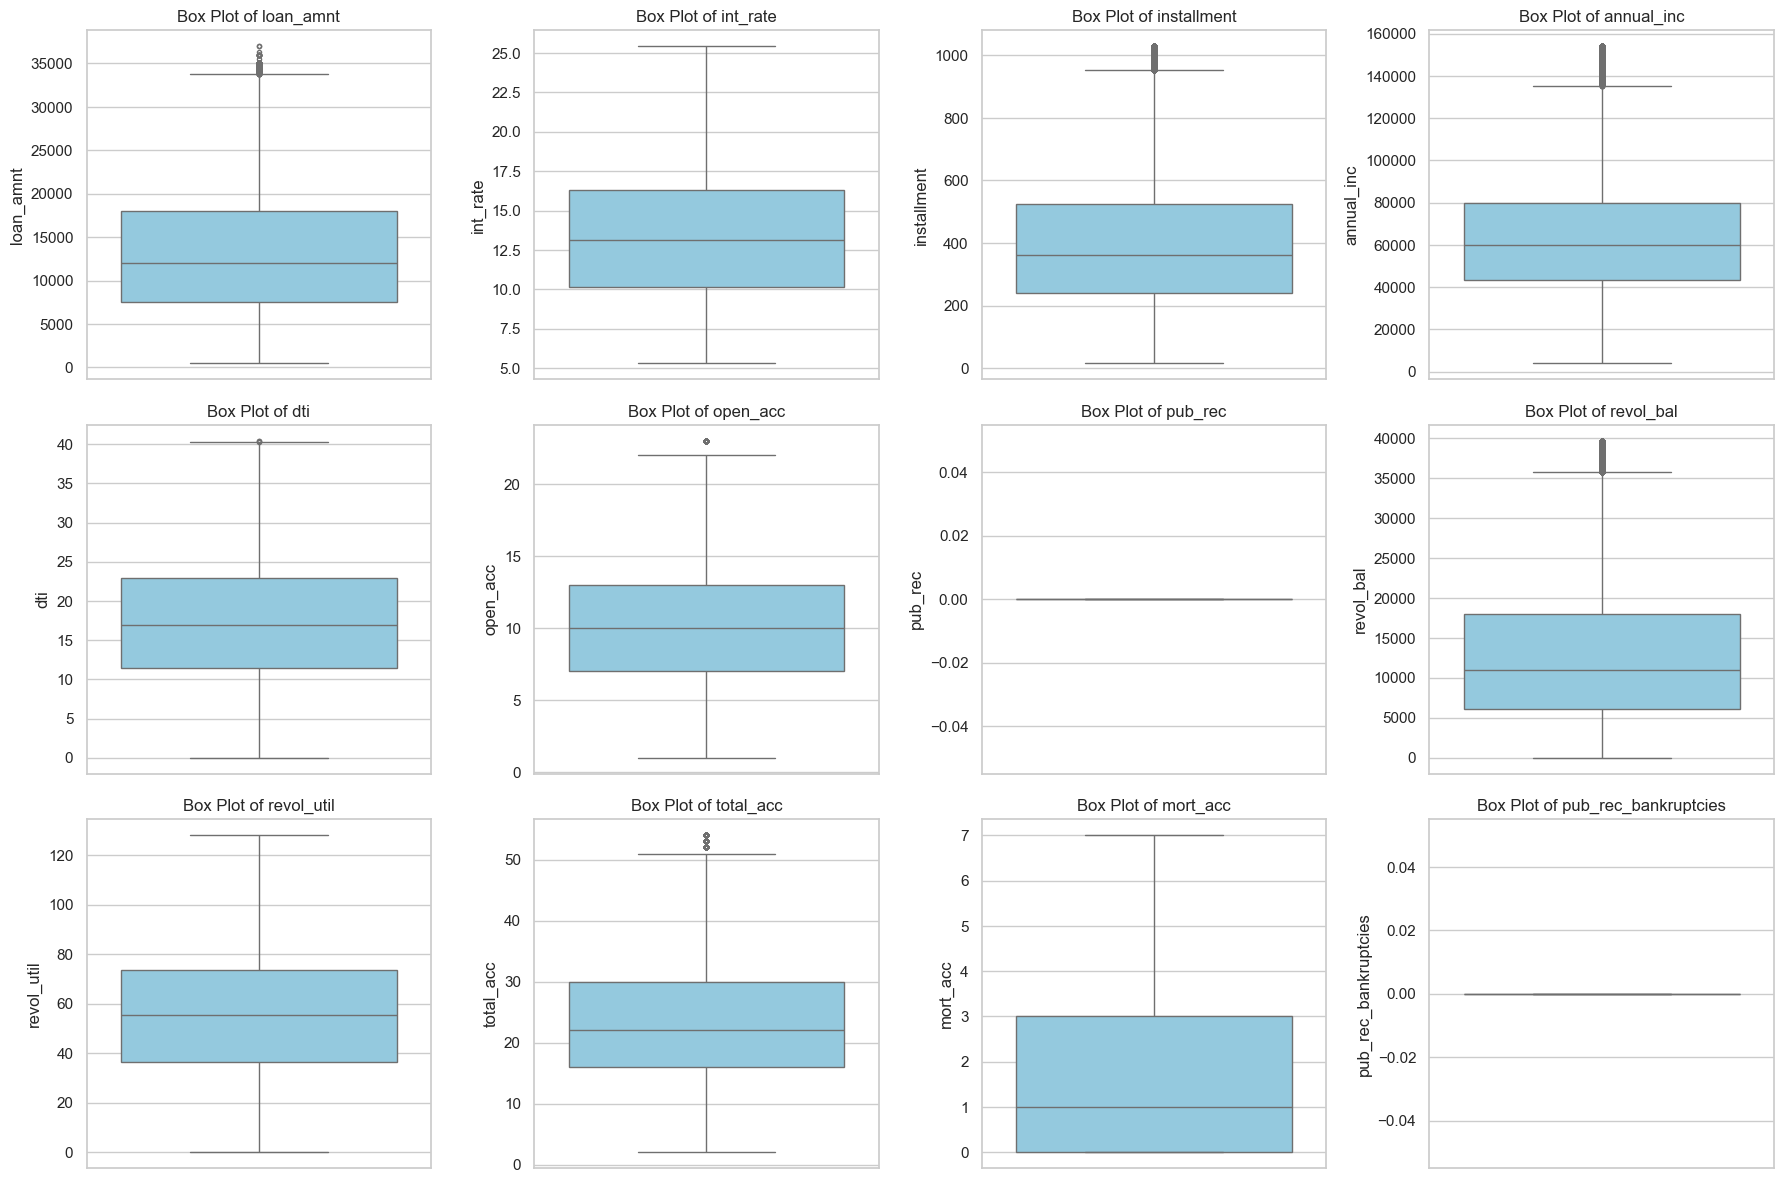

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Outlier removal with IQR (global, for all numeric cols) ---
df_num = df[numerical_columns].copy()

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Keep rows without outliers in any numeric column
df_num = df_num[~((df_num < lower) | (df_num > upper)).any(axis=1)]

# --- Plot in grid ---
ncols = 4
nplots = len(df_num.columns)
nrows = (nplots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4*nrows))

for i, col in enumerate(df_num.columns):
    ax = axes.flat[i]
    sns.boxplot(y=df_num[col], ax=ax, color="skyblue", 
                flierprops=dict(marker='o', color='red', markersize=3))
    ax.set_title(f"Box Plot of {col}")

# Hide empty subplots if grid is bigger than number of columns
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()


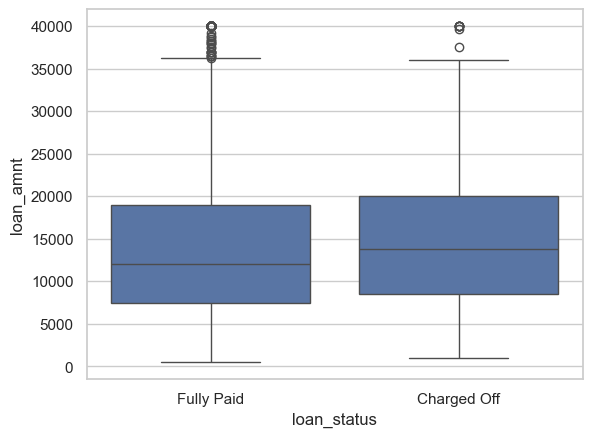

In [68]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df)
plt.show()

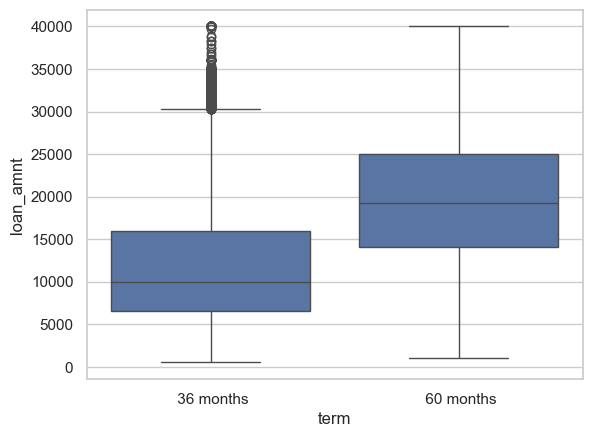

In [73]:
sns.boxplot(x='term',y='loan_amnt',data=df)
plt.show()

Loan amount taken is significantly higher in 60month than for 36 month term.

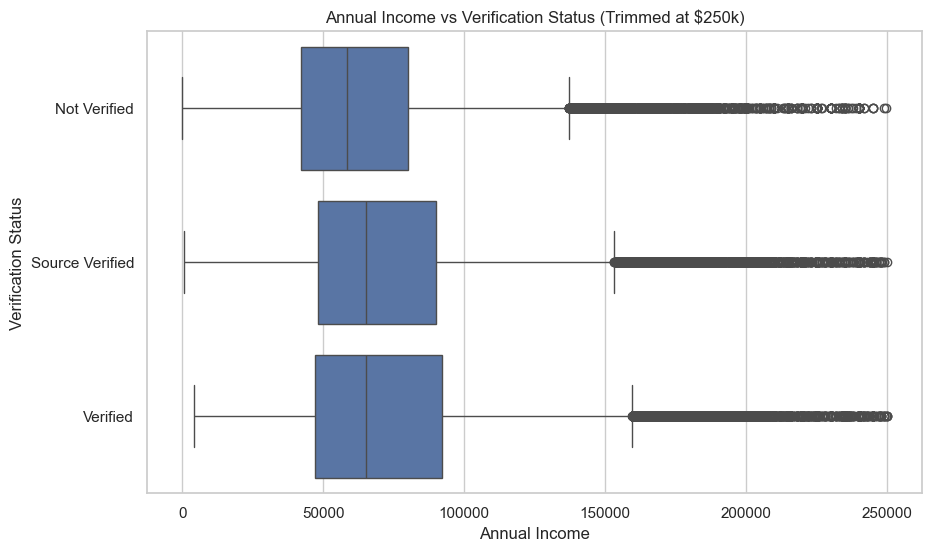

In [78]:
df_trimmed = df[df['annual_inc'] < 250000]

plt.figure(figsize=(10, 6))
sns.boxplot(x='annual_inc', y='verification_status', data=df_trimmed)
plt.title("Annual Income vs Verification Status (Trimmed at $250k)")
plt.xlabel("Annual Income")
plt.ylabel("Verification Status")
plt.show()


Almost all verification status have same annual income.

In [75]:
# pip install seaborn --upgrade

Annual income is more or the same over all emp length.

In [76]:
# Ensure target column is numeric
df['loan_repaid'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

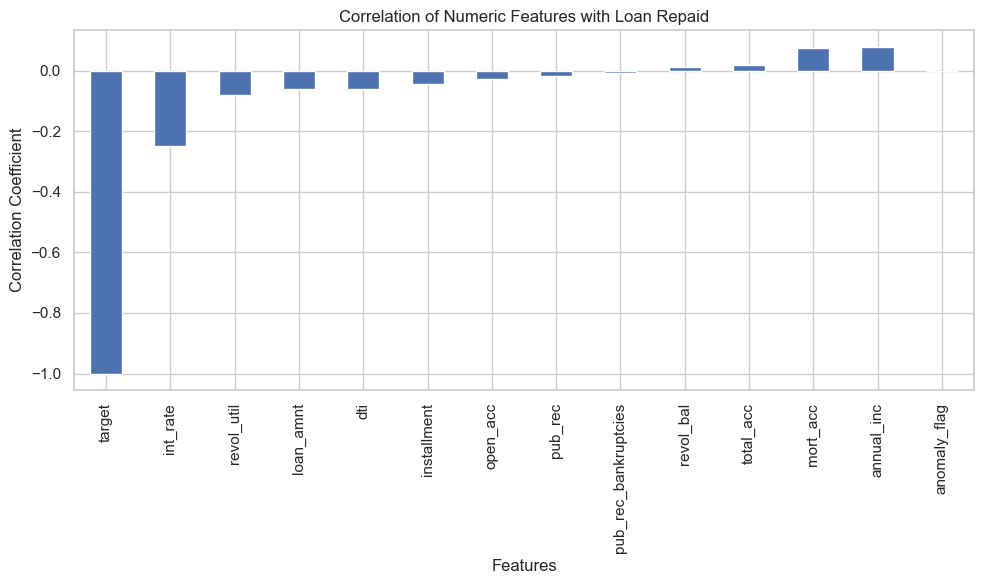

In [78]:
import matplotlib.pyplot as plt

# 1. Select numeric columns including the new loan_repaid
numeric_df = df.select_dtypes(include='number')

# 2. Compute correlation with loan_repaid
df_corr = numeric_df.corr()['loan_repaid'].drop('loan_repaid').sort_values()

plt.figure(figsize=(10, 6))
df_corr.plot(kind='bar') 
plt.title('Correlation of Numeric Features with Loan Repaid')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [79]:
#As interest rate goes up it is harder to pay off the loan

In [79]:
import pandas as pd
import numpy as np

# --- Percent strings -> numeric floats
def pct_to_float(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.replace("%", "", regex=False), errors="coerce")

if "int_rate" in df.columns:
    df["int_rate"] = pct_to_float(df["int_rate"])

if "revol_util" in df.columns:
    df["revol_util"] = pct_to_float(df["revol_util"])

# --- Derive numeric features used by the app
# term like " 36 months" -> 36
if "term" in df.columns and "term_months" not in df.columns:
    df["term_months"] = pd.to_numeric(
        df["term"].astype(str).str.extract(r"(\d+)", expand=False), errors="coerce"
    )

# emp_length like "< 1 year", "10+ years" -> integer years (cap 10)
if "emp_length" in df.columns and "emp_length_yrs" not in df.columns:
    yrs = df["emp_length"].astype(str).str.extract(r"(\d+)", expand=False)
    df["emp_length_yrs"] = pd.to_numeric(yrs, errors="coerce").fillna(0).clip(0, 10)

# Optional: split dates into numeric parts if you plan to use them later
if "earliest_cr_line" in df.columns:
    d = pd.to_datetime(df["earliest_cr_line"], errors="coerce")
    df["earliest_cr_year"]  = d.dt.year
    df["earliest_cr_month"] = d.dt.month

if "issue_d" in df.columns:
    df["issue_year"]  = df["issue_d"].dt.year
    df["issue_month"] = df["issue_d"].dt.month

# Optional: drop very high-cardinality free text you won't model
for col in ["emp_title", "title", "address"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

Data pre-processing

In [80]:
def get_missing(df):
    missing_values_count = df.isna().sum()
    missing_values_percent = (df.isna().sum()/len(df) * 100).round(1)
    missing_values_percent_sign = missing_values_percent.astype(str) + '%'
    missing_dataframe = pd.DataFrame({"Missing Count": missing_values_count,
                                        'Missing Percent': missing_values_percent_sign})
    return missing_dataframe[missing_dataframe['Missing Count'] > 0]

In [81]:
get_missing(df)

Missing Count Missing Percent
emp_length                    18232            4.7%
mort_acc                      37347            9.5%
pub_rec_bankruptcies            519            0.1%

In [82]:
# value counts
#df['title'].value_counts()

In [83]:
#vThis feature will not be informative because half people (173k) have unique titles, so we will drop it

In [84]:
# Treating missing values -
# Dropping null values from 'title','revol_util'and 'pub_rec_bankruptcies' as they are less than 1% of the record
# Imputing values in 'emp_title','emp_length' and 'mort_acc' as they have more missing records
df = df.dropna(subset=['revol_util','pub_rec_bankruptcies'])

In [85]:
get_missing(df)

Missing Count Missing Percent
emp_length          18232            4.7%
mort_acc            36828            9.4%

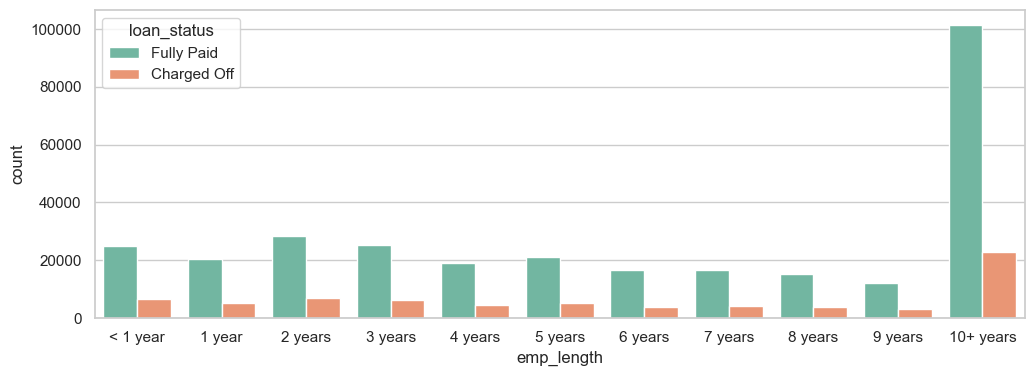

In [86]:
# Display a count plot per emp_length. Set the hue to the loan_status label.
plt.figure(figsize = (12,4), dpi = 100)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
sns.countplot(x='emp_length', data=df, hue='loan_status', order = order, palette='Set2')
plt.show()

In [87]:
# If you filtered earlier like df = df[df['loan_status'].isin(...)]
# df = df.loc[df['loan_status'].isin(target_map)].copy()   # <-- .copy() breaks the view chain

In [88]:
# Fill missing 'emp_title' and 'emp_length' with the mode (most frequent value)
# si_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# cols_mode = ['emp_length']
# df[cols_mode] = si_mode.fit_transform(df[cols_mode])
cols_mode = ['emp_length']
si_mode = SimpleImputer(strategy='most_frequent')

df.loc[:, cols_mode] = pd.DataFrame(
    si_mode.fit_transform(df[cols_mode]),
    columns=cols_mode,
    index=df.index
)

In [89]:
# col = 'mort_acc'
# df.loc[:, col] = SimpleImputer(strategy='median').fit_transform(df[[col]]).ravel()


# cols_median = ['mort_acc']
# si_median = SimpleImputer(strategy='median')

# df.loc[:, cols_median] = pd.DataFrame(
#     si_median.fit_transform(df[cols_median]),
#     columns=cols_median,
#     index=df.index
# )

In [90]:
col = 'mort_acc'
df.loc[:, col] = SimpleImputer(strategy='median').fit_transform(df[[col]]).ravel()

In [91]:
#Imputed values for 'emp_title','emp_length' and 'mort_acc'

In [92]:
get_missing(df)

Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []

In [93]:
df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
target                  0
anomaly_flag            0
loan_repaid             0
term_months             0
emp_length_yrs          0
earliest_cr_year        0
earliest_cr_month       0
issue_year              0
issue_month             0
dtype: int64

In [94]:
df[df.duplicated()]

Empty DataFrame
Columns: [loan_amnt, term, int_rate, installment, grade, sub_grade, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, purpose, dti, earliest_cr_line, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, application_type, mort_acc, pub_rec_bankruptcies, target, anomaly_flag, loan_repaid, term_months, emp_length_yrs, earliest_cr_year, earliest_cr_month, issue_year, issue_month]
Index: []

[0 rows x 33 columns]

No Duplicated records

In [95]:
#No duplicated records

# Non - Graphical Analysis


In [96]:
df['term'].value_counts()

term
 36 months    298499
 60 months     92778
Name: count, dtype: int64

In [97]:
#Most of the customer opt for 36months term

In [98]:
(df['int_rate'].value_counts()).head(10)

int_rate
10.99    12303
12.99     9550
15.61     9277
11.99     8501
8.90      7949
12.12     7319
7.90      7253
16.29     6581
13.11     6548
6.03      6223
Name: count, dtype: int64

In [99]:
#Top interest rate is 10.99, 12.99 and 15.61.

In [100]:
df['grade'].value_counts(normalize=True)*100

grade
B    29.353118
C    26.789206
A    16.180864
D    16.029820
E     7.925587
F     2.960051
G     0.761353
Name: proportion, dtype: float64

In [101]:
#Top Loan Grades are A,B,C and D

In [102]:
(df['sub_grade'].value_counts(normalize=True)*100).head(10)

sub_grade
B3    6.734615
B4    6.491309
C1    5.984507
C2    5.711299
B2    5.685486
B5    5.589902
C3    5.357330
C4    5.123991
B1    4.851806
A5    4.673416
Name: proportion, dtype: float64

In [103]:
#Top Loan Sub Grades are from B and C.

In [104]:
df.groupby(['grade','sub_grade'])['loan_status'].count()

grade  sub_grade
A      A1            9575
       A2            9460
       A3           10418
       A4           15573
       A5           18286
B      B1           18984
       B2           22246
       B3           26351
       B4           25399
       B5           21872
C      C1           23416
       C2           22347
       C3           20962
       C4           20049
       C5           18046
D      D1           15822
       D2           13774
       D3           12069
       D4           11485
       D5            9571
E      E1            7812
       E2            7313
       E3            6112
       E4            5272
       E5            4502
F      F1            3466
       F2            2727
       F3            2248
       F4            1767
       F5            1374
G      G1            1038
       G2             740
       G3             538
       G4             358
       G5             305
Name: loan_status, dtype: int64

In [105]:
df['emp_length'].value_counts(normalize=True)*100

emp_length
10+ years    36.483872
2 years       9.037843
3 years       7.985903
< 1 year      7.983091
5 years       6.687590
1 year        6.533990
4 years       6.048400
6 years       5.268135
7 years       5.263535
8 years       4.841327
9 years       3.866315
Name: proportion, dtype: float64

In [106]:
#Most loans are either taken by people with 10+ employment or 0-3 years of employment

In [107]:
df['purpose'].value_counts(normalize=True)*100

purpose
debt_consolidation    59.423886
credit_card           21.021425
home_improvement       5.936459
other                  5.308771
major_purchase         2.190009
small_business         1.397987
car                    1.183816
medical                1.056029
moving                 0.718928
vacation               0.620788
house                  0.542838
wedding                0.454921
renewable_energy       0.082550
educational            0.061593
Name: proportion, dtype: float64

In [108]:
print(df.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'target', 'anomaly_flag', 'loan_repaid',
       'term_months', 'emp_length_yrs', 'earliest_cr_year',
       'earliest_cr_month', 'issue_year', 'issue_month'],
      dtype='object')


In [109]:
# common_purposes = ['debt_consolidation', 'credit_card', 'home_improvement', 'major_purchase', 'small_business', 'car']
# df['purpose_grouped'] = df['purpose'].apply(lambda x: x if x in common_purposes else 'other_purpose')

In [110]:
#Most of the loan purpose is 'debt_consolidation' or 'credit_card'

In [111]:
df['home_ownership'].value_counts(normalize=True)*100

home_ownership
MORTGAGE    49.954125
RENT        40.500208
OWN          9.509887
OTHER        0.027602
NONE         0.007412
ANY          0.000767
Name: proportion, dtype: float64

In [112]:
# Recode 'NONE' and 'ANY' as 'OTHER'
df['home_ownership'] = df['home_ownership'].replace({'NONE': 'OTHER', 'ANY': 'OTHER'})

# Check value counts after recoding
df['home_ownership'].value_counts(normalize=True)*100

home_ownership
MORTGAGE    49.954125
RENT        40.500208
OWN          9.509887
OTHER        0.035780
Name: proportion, dtype: float64

In [113]:
#Most of the customers have either 'Mortgage' or 'Rented' home.

In [114]:
df['initial_list_status'].value_counts(normalize=True)*100

initial_list_status
f    60.099367
w    39.900633
Name: proportion, dtype: float64

In [115]:
df['application_type'].value_counts(normalize=True)*100

application_type
INDIVIDUAL    99.822121
JOINT          0.107341
DIRECT_PAY     0.070538
Name: proportion, dtype: float64

In [116]:
#Almost all the application type is 'INDIVIDUAL'

In [117]:
# (df['emp_title'].value_counts(normalize=True)*100).head(10)

In [118]:
# Out of all the different emp title most common is 'Teacher' and 'Manager'

In [119]:
df['loan_status'].value_counts(normalize=True)*100

loan_status
Fully Paid     80.350749
Charged Off    19.649251
Name: proportion, dtype: float64

80 percent loans are fully paid

Feature Engineering

Creating date fields

In [120]:
#step 1
categorical_cols = df.select_dtypes(include='object').columns
print("Categorical Columns:")
print(categorical_cols)

Categorical Columns:
Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'initial_list_status',
       'application_type'],
      dtype='object')


In [121]:
print("Unique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


Unique values in categorical columns:
term: 2 unique values
grade: 7 unique values
sub_grade: 35 unique values
emp_length: 11 unique values
home_ownership: 4 unique values
verification_status: 3 unique values
loan_status: 2 unique values
purpose: 14 unique values
initial_list_status: 2 unique values
application_type: 3 unique values


In [122]:
emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

# Apply the mapping
df['emp_length'] = df['emp_length'].map(emp_length_map)

In [123]:
df['emp_length']

0         10
1          4
2          0
3          6
4          9
          ..
396025     2
396026     5
396027    10
396028    10
396029    10
Name: emp_length, Length: 391277, dtype: int64

In [124]:
# df.drop(columns=['emp_title', 'title', 'address'], inplace=True)

In [125]:
print(df.columns)


Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'target', 'anomaly_flag', 'loan_repaid',
       'term_months', 'emp_length_yrs', 'earliest_cr_year',
       'earliest_cr_month', 'issue_year', 'issue_month'],
      dtype='object')


In [126]:
categorical_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'initial_list_status',
       'application_type'],
      dtype='object')

In [127]:
# Step 2: Label encode sub_grade
from sklearn.preprocessing import LabelEncoder
df['sub_grade'] = LabelEncoder().fit_transform(df['sub_grade'])

In [128]:
# Step 3: One-hot encode low-cardinality useful categoricals
to_onehot = ['term', 'grade', 'emp_length', 'home_ownership',
             'verification_status', 'purpose', 'initial_list_status',
             'application_type']
df = pd.get_dummies(df, columns=to_onehot, drop_first=True)

In [129]:
# df['emp_length'].value_counts()

In [130]:
# Step 4: Encode target column
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

In [131]:
# from sklearn.model_selection import train_test_split

# X = df.drop('loan_status', axis=1)
# y = df['loan_status']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=1, stratify=y)


In [132]:
# target_map = {"Fully Paid": 0, "Charged Off": 1}
# df = df.loc[df["loan_status"].isin(target_map)].copy()
# df["target"] = df["loan_status"].map(target_map)

In [133]:
print(df["loan_status"].value_counts())
print(df["target"].value_counts())
df[["loan_status","target"]].head()


loan_status
0    314394
1     76883
Name: count, dtype: int64
target
0    314394
1     76883
Name: count, dtype: int64


loan_status  target
0            0       0
1            0       0
2            0       0
3            0       0
4            1       1

In [134]:
# import numpy as np
# import pandas as pd

# # 1) If a stray "feature" column exists (often created by mistake), drop it
# df = df.drop(columns=["feature"], errors="ignore")

# # 2) See what's actually in loan_status
# print("loan_status unique:", sorted(df["loan_status"].dropna().unique()))

# # 3) Rebuild target ONLY from final outcomes (adjust if your file has 'Default')
# s = df["loan_status"].astype(str).str.strip().str.lower()
# map_final = {"fully paid": 0, "charged off": 1}   # add "default": 1 if present

# keep_mask = s.isin(map_final.keys())
# df = df.loc[keep_mask].copy()
# df["target"] = s.loc[keep_mask].map(map_final).astype("int8")

# # 4) Sanity checks
# print("target value_counts:\n", df["target"].value_counts(dropna=False))
# print("positive rate:", df["target"].mean().round(4))

# # 5) (Optional) put target at the end for display
# cols = [c for c in df.columns if c != "target"] + ["target"]
# display(df[cols].head())


In [135]:
NUMERIC_FEATURES = [
    "loan_amnt","term_months","int_rate","installment","annual_inc","dti",
    "open_acc","pub_rec","inq_last_6mths","revol_bal","revol_util","total_acc","emp_length_yrs"
    # include if you want them:
    # "earliest_cr_year","earliest_cr_month","issue_year","issue_month"
]
CATEGORICAL_FEATURES = ["home_ownership","verification_status","purpose","application_type"]

ALL_FEATURES = [c for c in NUMERIC_FEATURES + CATEGORICAL_FEATURES if c in df.columns]

# fail fast if key numerics didn’t convert
for c in ["loan_amnt","int_rate","revol_util","term_months","emp_length_yrs"]:
    assert c in df.columns and pd.api.types.is_numeric_dtype(df[c]), f"{c} not ready"

# build modeling frame, THEN create X/y
df_model = df.dropna(subset=ALL_FEATURES + ["target"]).copy()
X = df_model[ALL_FEATURES]
y = df_model["target"]

print("X shape:", X.shape, " y shape:", y.shape)

X shape: (391277, 12)  y shape: (391277,)


In [136]:
datetime_cols = df_model.select_dtypes(include="datetime64[ns]").columns.tolist()
print("Datetime columns in df_model:", datetime_cols)

Datetime columns in df_model: ['issue_d', 'earliest_cr_line']


In [137]:
datetime_cols = X.select_dtypes(include='datetime64').columns
print("Datetime columns:", datetime_cols)

Datetime columns: Index([], dtype='object')


In [138]:
# for col in datetime_cols:
#     X[col + '_year'] = X[col].dt.year
#     X[col + '_month'] = X[col].dt.month

# X.drop(columns=datetime_cols, inplace=True)


In [139]:
# print(df.columns).value()

In [140]:
print(df.dtypes)


loan_amnt                      float64
int_rate                       float64
installment                    float64
sub_grade                        int32
annual_inc                     float64
                                ...   
purpose_vacation                  bool
purpose_wedding                   bool
initial_list_status_w             bool
application_type_INDIVIDUAL       bool
application_type_JOINT            bool
Length: 63, dtype: object


In [141]:
# df['issue_d_year'] = pd.to_datetime(df['issue_d']).dt.year
# df['issue_d_month'] = pd.to_datetime(df['issue_d']).dt.month

# df['earliest_cr_year'] = pd.to_datetime(df['earliest_cr_line']).dt.year
# df['earliest_cr_month'] = pd.to_datetime(df['earliest_cr_line']).dt.month

# # Drop original datetime columns
# df.drop(columns=['issue_d', 'earliest_cr_line'], inplace=True)


In [142]:
df.head()

loan_amnt  int_rate  installment  sub_grade  annual_inc    issue_d  \
0    10000.0     11.44       329.48          8    117000.0 2015-01-01   
1     8000.0     11.99       265.68          9     65000.0 2015-01-01   
2    15600.0     10.49       506.97          7     43057.0 2015-01-01   
3     7200.0      6.49       220.65          1     54000.0 2014-11-01   
4    24375.0     17.27       609.33         14     55000.0 2013-04-01   

   loan_status    dti earliest_cr_line  open_acc  ...  purpose_medical  \
0            0  26.24       1990-06-01      16.0  ...            False   
1            0  22.05       2004-07-01      17.0  ...            False   
2            0  12.79       2007-08-01      13.0  ...            False   
3            0   2.60       2006-09-01       6.0  ...            False   
4            1  33.95       1999-03-01      13.0  ...            False   

   purpose_moving  purpose_other  purpose_renewable_energy  \
0           False          False                     False   
1           False          False                     False   
2           False          False                     False   
3           False          False                     False   
4           False          False                     False   

   purpose_small_business  purpose_vacation  purpose_wedding  \
0                   False              True            False   
1                   False             False            False   
2                   False             False            False   
3                   False             False            False   
4                   False             False            False   

   initial_list_status_w  application_type_INDIVIDUAL  application_type_JOINT  
0                   True                         True                   False  
1                  False                         True                   False  
2                  False                         True                   False  
3                  False                         True                   False  
4                  False                         True                   False  

[5 rows x 63 columns]

In [143]:
print(df.dtypes)

loan_amnt                      float64
int_rate                       float64
installment                    float64
sub_grade                        int32
annual_inc                     float64
                                ...   
purpose_vacation                  bool
purpose_wedding                   bool
initial_list_status_w             bool
application_type_INDIVIDUAL       bool
application_type_JOINT            bool
Length: 63, dtype: object


In [144]:
# Step 1: Drop datetime columns if they still exist
datetime_cols = X.select_dtypes(include='datetime64').columns
if len(datetime_cols) > 0:
    print("Dropping datetime columns:", list(datetime_cols))
    X = X.drop(columns=datetime_cols)

In [145]:
# Step 2: Confirm all columns are numeric (float, int, bool)
print("\nRemaining non-numeric columns:")
print(X.select_dtypes(exclude=['float64', 'int64', 'bool']).dtypes)


Remaining non-numeric columns:
Series([], dtype: object)


In [146]:
df.drop(columns=['sub_grade'], inplace=True)

In [147]:
# Step 2: Confirm all columns are numeric (float, int, bool)
print("\nRemaining non-numeric columns:")
print(X.select_dtypes(exclude=['float64', 'int64', 'bool']).dtypes)


Remaining non-numeric columns:
Series([], dtype: object)


In [148]:
# df['sub_grade'].head()

In [149]:
df.head()

loan_amnt  int_rate  installment  annual_inc    issue_d  loan_status  \
0    10000.0     11.44       329.48    117000.0 2015-01-01            0   
1     8000.0     11.99       265.68     65000.0 2015-01-01            0   
2    15600.0     10.49       506.97     43057.0 2015-01-01            0   
3     7200.0      6.49       220.65     54000.0 2014-11-01            0   
4    24375.0     17.27       609.33     55000.0 2013-04-01            1   

     dti earliest_cr_line  open_acc  pub_rec  ...  purpose_medical  \
0  26.24       1990-06-01      16.0      0.0  ...            False   
1  22.05       2004-07-01      17.0      0.0  ...            False   
2  12.79       2007-08-01      13.0      0.0  ...            False   
3   2.60       2006-09-01       6.0      0.0  ...            False   
4  33.95       1999-03-01      13.0      0.0  ...            False   

   purpose_moving  purpose_other  purpose_renewable_energy  \
0           False          False                     False   
1           False          False                     False   
2           False          False                     False   
3           False          False                     False   
4           False          False                     False   

   purpose_small_business  purpose_vacation  purpose_wedding  \
0                   False              True            False   
1                   False             False            False   
2                   False             False            False   
3                   False             False            False   
4                   False             False            False   

   initial_list_status_w  application_type_INDIVIDUAL  application_type_JOINT  
0                   True                         True                   False  
1                  False                         True                   False  
2                  False                         True                   False  
3                  False                         True                   False  
4                  False                         True                   False  

[5 rows x 62 columns]

In [150]:
#df['laon_repaid'].head()

In [151]:
#df['sub_grade'].unique()

In [152]:
# from sklearn.model_selection import train_test_split

# X = df.drop('loan_status', axis=1)
# y = df['loan_status']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y)

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=1, stratify=y)
#Split data
from sklearn.model_selection import train_test_split

X = df_model[ALL_FEATURES]      # ONLY the fields you’ll collect in Streamlit
y = df_model["target"]

# X = df.drop("loan_status", axis=1)
# y = df["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [153]:
# Detect feature types from X (after your conversions)
NUM_COLS = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
CAT_COLS = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

print("Train:", X_train.shape, " Valid:", X_test.shape)
print("NUM_COLS:", len(NUM_COLS), NUM_COLS)
print("CAT_COLS:", len(CAT_COLS), CAT_COLS)


Train: (313021, 12)  Valid: (78256, 12)
NUM_COLS: 12 ['loan_amnt', 'term_months', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'emp_length_yrs']
CAT_COLS: 0 []


In [154]:
print(X.corrwith(y).sort_values(ascending=False))

int_rate          0.248042
term_months       0.174033
revol_util        0.082207
loan_amnt         0.062344
dti               0.061845
installment       0.043211
open_acc          0.028082
pub_rec           0.019124
revol_bal        -0.010010
total_acc        -0.017792
emp_length_yrs   -0.027303
annual_inc       -0.078559
dtype: float64


In [155]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Train unique labels:", y_train.unique())
print("Test unique labels:", y_test.unique())

Train shape: (313021, 12) (313021,)
Test shape: (78256, 12) (78256,)
Train unique labels: [0 1]
Test unique labels: [0 1]


In [156]:
df.drop(columns=['loan_repaid'], inplace=True)

In [157]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Train unique labels:", y_train.unique())
print("Test unique labels:", y_test.unique())

Train shape: (313021, 12) (313021,)
Test shape: (78256, 12) (78256,)
Train unique labels: [0 1]
Test unique labels: [0 1]


In [158]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True)),   # dense
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # dense
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUM_COLS),
        ("cat", categorical_pipe, CAT_COLS),
    ],
    remainder="drop",
    sparse_threshold=0.0  # force dense output
)

In [159]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_sm_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

lr_model = LogisticRegression(max_iter=1500, class_weight = 'balanced', random_state = 42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))


xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

C:\Users\kurha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.88      0.61      0.72     62879
           1       0.29      0.66      0.41     15377

    accuracy                           0.62     78256
   macro avg       0.59      0.64      0.56     78256
weighted avg       0.76      0.62      0.66     78256

XGBoost Report:
               precision    recall  f1-score   support

           0       0.81      0.98      0.89     62879
           1       0.52      0.08      0.14     15377

    accuracy                           0.80     78256
   macro avg       0.67      0.53      0.51     78256
weighted avg       0.76      0.80      0.74     78256



Accuracy = 65%:

Macro average F1 = 0.58: Equal weight to both classes.

Weighted average F1 = 0.68: Accounts for class imbalance.


Random Forest
High accuracy — mostly predicting Class 0

Horrible recall for Class 1 (only 8% of defaulters are detected!)

Heavily biased toward the majority class

Not usable for credit risk where missing defaulters is costly

XGBoost
Slightly better recall than Random Forest (12% vs 8%) but still very low

Accuracy is good — but due to correct prediction of non-defaulters

Still very poor F1-score (0.19) for Class 1

| Test Size | Model               | Class 1 Recall | Class 1 F1 | Accuracy |
| --------- | ------------------- | -------------- | ---------- | -------- |
| 0.2       | Logistic Regression | 0.63           | 0.42       | 0.65     |
| 0.2       | Random Forest       | 0.08           | 0.13       | 0.81     |
| 0.2       | XGBoost             | 0.12           | 0.20       | 0.81     |
| 0.3       | Logistic Regression | 0.61           | 0.40       | 0.64     |
| 0.3       | Random Forest       | 0.08           | 0.14       | 0.80     |
| 0.3       | XGBoost             | 0.12           | 0.20       | 0.81     |
| 0.5       | Logistic Regression | 0.62           | 0.40       | 0.63     |
| 0.5       | Random Forest       | 0.08           | 0.14       | 0.81     |
| 0.5       | XGBoost             | 0.12           | 0.20       | 0.81     |
| 0.6       | Logistic Regression | 0.63           | 0.41       | 0.64     |
| 0.6       | Random Forest       | 0.08           | 0.14       | 0.81     |
| 0.6       | XGBoost             | 0.13           | 0.20       | 0.81     |
| 0.7       | Logistic Regression | 0.64           | 0.42       | 0.65     |
| 0.7       | Random Forest       | 0.08           | 0.14       | 0.81     |
| 0.7       | XGBoost             | 0.13           | 0.21       | 0.80     |
| 0.8       | Logistic Regression | 0.63           | 0.42       | 0.65     |
| 0.8       | Random Forest       | 0.08           | 0.13       | 0.81     |
| 0.8       | XGBoost             | 0.12           | 0.20       | 0.81     |



##  Impact of Test Size on Model Performance (Logistic Regression, Random Forest, XGBoost)


### Logistic Regression

* Most **consistent** performer across all test sizes
* **Class 1 recall stays around 0.63–0.64**
* Slightly lower overall accuracy (\~0.65), but better at catching defaulters
* **Best choice** when the cost of missing a default is high

### Random Forest

* High overall accuracy (\~0.81) but **recall for defaulters is only \~0.08**
* Strong bias toward majority class (Fully Paid)
* Not recommended for imbalanced credit risk tasks

### XGBoost

* Slightly better than Random Forest in detecting defaulters (recall \~0.12–0.13)
* Still not good enough for credit risk settings unless tuned further
* Better for accuracy, not recall



In [163]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    class_weight="balanced",       # helps the minority class
    random_state=1
)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt, digits=3))


Decision Tree Report:
               precision    recall  f1-score   support

           0      0.821     0.822     0.821     62879
           1      0.268     0.266     0.267     15377

    accuracy                          0.713     78256
   macro avg      0.544     0.544     0.544     78256
weighted avg      0.712     0.713     0.712     78256



In [164]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64,32),
    max_iter=500,
    early_stopping=True,
    random_state=42
)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

print("MLP Report:\n", classification_report(y_test, y_pred_mlp))


MLP Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     62879
           1       0.43      0.00      0.00     15377

    accuracy                           0.80     78256
   macro avg       0.62      0.50      0.45     78256
weighted avg       0.73      0.80      0.72     78256



In [166]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

KeyboardInterrupt: 

In [167]:
import joblib
joblib.dump(lr_model, 'logistic_regression_model_1.1.pkl')

['logistic_regression_model_1.1.pkl']

In [168]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print("After SMOTE:", X_train_sampled.shape, y_train_sampled.shape)

After SMOTE: (503030, 12) (503030,)


In [169]:
lr_model_smote = LogisticRegression(max_iter=4000, random_state=1)
lr_model_smote.fit(X_train_sampled, y_train_sampled)

y_pred_smote = lr_model_smote.predict(X_test)
print("Logistic Regression Report (with SMOTE):\n", classification_report(y_test, y_pred_smote))

C:\Users\kurha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Report (with SMOTE):
               precision    recall  f1-score   support

           0       0.88      0.62      0.73     62879
           1       0.30      0.65      0.41     15377

    accuracy                           0.63     78256
   macro avg       0.59      0.63      0.57     78256
weighted avg       0.76      0.63      0.67     78256



In [170]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_test_scaled = scaler.transform(X_test)

In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train model on scaled SMOTE-balanced training data
lr_model_scaled = LogisticRegression(max_iter=2000, random_state=1)
lr_model_scaled.fit(X_train_scaled, y_train_sampled)

# Predict on scaled test data
y_pred_scaled = lr_model_scaled.predict(X_test_scaled)

# Evaluate performance
print("Logistic Regression Report (Scaled + SMOTE):\n")
print(classification_report(y_test, y_pred_scaled))


Logistic Regression Report (Scaled + SMOTE):

              precision    recall  f1-score   support

           0       0.88      0.66      0.75     62879
           1       0.31      0.63      0.42     15377

    accuracy                           0.66     78256
   macro avg       0.60      0.65      0.59     78256
weighted avg       0.77      0.66      0.69     78256



In [172]:
import joblib
joblib.dump(lr_model, 'logistic_regression_model_1.2.pkl')

['logistic_regression_model_1.2.pkl']

In [173]:
dt_model_scaled = DecisionTreeClassifier(
    max_depth=8,          # keep the tree from overfitting
    min_samples_leaf=50,
    random_state=1
)
dt_model_scaled.fit(X_train_scaled, y_train_sampled)

# Predict on the **scaled** test set
y_pred_dt = dt_model_scaled.predict(X_test_scaled)

print("Decision Tree Report (Scaled + SMOTE):\n",
      classification_report(y_test, y_pred_dt))

Decision Tree Report (Scaled + SMOTE):
               precision    recall  f1-score   support

           0       0.83      0.85      0.84     62879
           1       0.33      0.32      0.32     15377

    accuracy                           0.74     78256
   macro avg       0.58      0.58      0.58     78256
weighted avg       0.74      0.74      0.74     78256



In [174]:
import xgboost as xgb
from sklearn.metrics import classification_report

# class imbalance ratio from TRAIN
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
spw = neg / max(pos, 1)   # scale_pos_weight

# use your train/test (trees don't need scaling)
xgb_spw = xgb.XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=5,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    objective="binary:logistic", eval_metric="auc",
    scale_pos_weight=spw, n_jobs=-1, random_state=42
)

xgb_spw.fit(X_train, y_train)
y_pred_spw = xgb_spw.predict(X_test)  # default 0.50 cutoff

print(f"scale_pos_weight used: {spw:.2f}")
print("XGB (no SMOTE, with scale_pos_weight):\n",
      classification_report(y_test, y_pred_spw))


scale_pos_weight used: 4.09
XGB (no SMOTE, with scale_pos_weight):
               precision    recall  f1-score   support

           0       0.89      0.65      0.75     62879
           1       0.32      0.66      0.43     15377

    accuracy                           0.65     78256
   macro avg       0.60      0.66      0.59     78256
weighted avg       0.77      0.65      0.69     78256



In [175]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb_model_scaled = xgb.XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=5,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    objective="binary:logistic", eval_metric="auc",
    n_jobs=-1, random_state=1
)  # with SMOTE, do NOT set scale_pos_weight
xgb_model_scaled.fit(X_train_scaled, y_train_sampled)

y_pred_xgb = xgb_model_scaled.predict(X_test_scaled)
print("XGBoost Report (Scaled + SMOTE):\n",
      classification_report(y_test, y_pred_xgb))

XGBoost Report (Scaled + SMOTE):
               precision    recall  f1-score   support

           0       0.82      0.98      0.89     62879
           1       0.52      0.10      0.16     15377

    accuracy                           0.80     78256
   macro avg       0.67      0.54      0.53     78256
weighted avg       0.76      0.80      0.75     78256



Scaling doesn’t affect XGBoost.
XGB is tree-based, so feature scaling has essentially no effect. So “Scaled + SMOTE” vs “Unscaled + SMOTE” will look the same unless the training set itself changed.

In [176]:
mlp_model_scaled = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    early_stopping=True,
    random_state=1
)
mlp_model_scaled.fit(X_train_scaled, y_train_sampled)

y_pred_mlp = mlp_model_scaled.predict(X_test_scaled)
print("MLP Report (Scaled + SMOTE):\n",
      classification_report(y_test, y_pred_mlp, digits=3))

C:\Users\kurha\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP Report (Scaled + SMOTE):
               precision    recall  f1-score   support

           0      0.839     0.838     0.838     62879
           1      0.340     0.341     0.340     15377

    accuracy                          0.740     78256
   macro avg      0.589     0.589     0.589     78256
weighted avg      0.741     0.740     0.740     78256



In [178]:
# 1) Sanity check
# Create the scaler on ORIGINAL (non-SMOTE) train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train)      # fit ONLY on X_train

import numpy as np
def shp(name, arr): 
    try: print(name, np.shape(arr))
    except: print(name, 'missing')

shp('X_train', X_train)
shp('y_train', y_train)
shp('X_train_scaled', X_train_scaled)      # might be SMOTE-sized in your notebook
shp('X_train_sampled', X_train_sampled)    # SMOTE
shp('y_train_sampled', y_train_sampled)

# 2) Build ORIGINAL-TRAIN (non-SMOTE) *scaled* matrices using the SAME scaler 'sc'
#    (this is the scaler you fit BEFORE doing SMOTE; reuse it!)
X_train_scaled_orig = sc.transform(X_train)   # <-- original train, scaled with sc
X_test_scaled_orig  = sc.transform(X_test)


X_train (313021, 12)
y_train (313021,)
X_train_scaled (503030, 12)
X_train_sampled (503030, 12)
y_train_sampled (503030,)


In [179]:
# ---- Tune threshold for ALL fitted models, then evaluate on TEST ----
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, precision_recall_fscore_support,
                             roc_auc_score, average_precision_score)

# 1) make a small validation slice from the ORIGINAL (non-SMOTE) TRAIN
X_tr_raw, X_val_raw, y_trv, y_valv = train_test_split(
    X_train, y_train, test_size=0.20, stratify=y_train, random_state=42
)

# 2) build scaled versions for models that were trained on SCALED inputs
if 'sc' in globals():
    X_val_scaled  = sc.transform(X_val_raw)
    X_test_scaled2 = sc.transform(X_test)
else:
    X_val_scaled  = X_val_raw
    X_test_scaled2 = X_test

def best_thr_from_val(model, Xv, yv, metric="f1"):
    """Pick threshold that maximizes F1 (or recall) on validation probs."""
    p = model.predict_proba(Xv)[:, 1]
    grid = np.round(np.linspace(0.05, 0.95, 91), 2)
    best, thr = -1.0, 0.50
    for t in grid:
        yhat = (p >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
        score = f1 if metric=="f1" else rec
        if score > best:
            best, thr = score, float(t)
    return thr

def tune_and_report(name, model, Xv, yv, Xte, yte):
    thr = best_thr_from_val(model, Xv, yv, metric="f1")
    pte = model.predict_proba(Xte)[:, 1]
    yhat = (pte >= thr).astype(int)
    print(f"\n{name} @ thr={thr:.2f} | ROC-AUC={roc_auc_score(yte, pte):.3f} | PR-AUC={average_precision_score(yte, pte):.3f}")
    print(classification_report(yte, yhat, digits=3))

# 3) run for whatever models you have
if 'lr_model_scaled' in globals():
    tune_and_report("LR (Scaled+SMOTE)",  lr_model_scaled,  X_val_scaled, y_valv, X_test_scaled2, y_test)

if 'dt_model_scaled' in globals():
    tune_and_report("DT (Scaled+SMOTE)",  dt_model_scaled,  X_val_scaled, y_valv, X_test_scaled2, y_test)

if 'mlp_model_scaled' in globals():
    tune_and_report("MLP (Scaled+SMOTE)", mlp_model_scaled, X_val_scaled, y_valv, X_test_scaled2, y_test)

# XGBoost with scale_pos_weight was trained on RAW features in your notebook
if 'xgb_spw' in globals():
    tune_and_report("XGB (spw, no SMOTE)", xgb_spw, X_val_raw, y_valv, X_test, y_test)

# (Optional) if you also trained an XGB on Scaled+SMOTE:
if 'xgb_model_scaled' in globals():
    tune_and_report("XGB (Scaled+SMOTE)", xgb_model_scaled, X_val_scaled, y_valv, X_test_scaled2, y_test)



LR (Scaled+SMOTE) @ thr=0.53 | ROC-AUC=0.701 | PR-AUC=0.353
              precision    recall  f1-score   support

           0      0.884     0.637     0.741     62879
           1      0.307     0.657     0.418     15377

    accuracy                          0.641     78256
   macro avg      0.595     0.647     0.579     78256
weighted avg      0.770     0.641     0.677     78256


DT (Scaled+SMOTE) @ thr=0.30 | ROC-AUC=0.456 | PR-AUC=0.183
              precision    recall  f1-score   support

           0      0.857     0.006     0.012     62879
           1      0.197     0.996     0.329     15377

    accuracy                          0.201     78256
   macro avg      0.527     0.501     0.171     78256
weighted avg      0.728     0.201     0.075     78256


MLP (Scaled+SMOTE) @ thr=0.14 | ROC-AUC=0.430 | PR-AUC=0.174
              precision    recall  f1-score   support

           0      0.904     0.014     0.028     62879
           1      0.198     0.994     0.330     15377

In [180]:
import numpy as np, json
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_fscore_support, classification_report,
                             roc_auc_score, average_precision_score)

# use scaled matrices if you have them, else raw
X_tr_all = X_train_scaled if 'X_train_scaled' in globals() else X_train
X_te_all = X_test_scaled  if 'X_test_scaled'  in globals() else X_test

# 1) a small validation slice from TRAIN (for threshold picking)
X_trv, X_valv, y_trv, y_valv = train_test_split(
    X_tr_all, y_train, test_size=0.20, stratify=y_train, random_state=42
)

def tune_threshold(model, Xv, yv, metric="f1"):
    """Return threshold that maximizes F1 (or Recall) on validation probs."""
    p = model.predict_proba(Xv)[:, 1]
    ths = np.round(np.linspace(0.05, 0.95, 91), 2)
    best_t, best = 0.50, -1.0
    for t in ths:
        yhat = (p >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
        val = f1 if metric == "f1" else rec
        if val > best:
            best, best_t = val, float(t)
    return best_t

def report_at_thr(name, model, Xte, yte, thr):
    p = model.predict_proba(Xte)[:, 1]
    yhat = (p >= thr).astype(int)
    print(f"\n{name} @ thr={thr:.2f} | ROC-AUC={roc_auc_score(yte, p):.3f} | PR-AUC={average_precision_score(yte, p):.3f}")
    print(classification_report(yte, yhat))

ValueError: Found input variables with inconsistent numbers of samples: [503030, 313021]

In [ ]:
# Create the scaler on ORIGINAL (non-SMOTE) train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train)      # fit ONLY on X_train


In [181]:
# ===== simple threshold sweep (tune on VAL, report on TEST) =====
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_auc_score, average_precision_score
)

# 1) make a small validation split from the ORIGINAL (non-SMOTE) train
X_tr_raw, X_val_raw, y_trv, y_valv = train_test_split(
    X_train, y_train, test_size=0.20, stratify=y_train, random_state=42
)

# if your model expects scaled inputs, scale the val/test with the SAME scaler `sc`
X_val_s  = sc.transform(X_val_raw)
X_test_s = sc.transform(X_test)

def pick_threshold(model, Xv, yv, metric="f1"):
    """Return best threshold and a dict of metrics (tuned on validation probs)."""
    p = model.predict_proba(Xv)[:, 1]
    grid = np.round(np.linspace(0.05, 0.95, 91), 2)
    best, best_row = -1.0, None
    for t in grid:
        yhat = (p >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
        tn, fp, fn, tp = confusion_matrix(yv, yhat).ravel()
        row = {
            "threshold": float(t),
            "precision": float(prec), "recall": float(rec), "f1": float(f1),
            "roc_auc": float(roc_auc_score(yv, p)),
            "pr_auc":  float(average_precision_score(yv, p)),
            "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        }
        score = row[metric]
        if score > best:
            best, best_row = score, row
    return best_row["threshold"], best_row

def report_at(model, Xte, yte, thr):
    """Print metrics & confusion matrix on TEST at the chosen threshold."""
    p = model.predict_proba(Xte)[:, 1]
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(yte, yhat).ravel()
    print(f"\n@thr={thr:.2f}  ROC-AUC={roc_auc_score(yte, p):.3f}  PR-AUC={average_precision_score(yte, p):.3f}")
    print(classification_report(yte, yhat, digits=3))
    print("Confusion matrix [[tn fp],[fn tp]]:\n", np.array([[tn, fp], [fn, tp]]))

In [182]:
# A) Logistic Regression trained on SCALED+SMOTE
thr_lr, row_lr = pick_threshold(lr_model_scaled, X_val_s, y_valv, metric="f1")
print("LR best:", row_lr)
report_at(lr_model_scaled, X_test_s, y_test, thr_lr)

# B) XGBoost with scale_pos_weight (trained on RAW, no SMOTE)
thr_xgb, row_xgb = pick_threshold(xgb_spw, X_val_raw, y_valv, metric="f1")
print("XGB best:", row_xgb)
report_at(xgb_spw, X_test, y_test, thr_xgb)



LR best: {'threshold': 0.53, 'precision': 0.3078352548543689, 'recall': 0.6598650516218194, 'f1': 0.41981949365124516, 'roc_auc': 0.7030233967898719, 'pr_auc': 0.3560537279610458, 'tn': 32053, 'fp': 18251, 'fn': 4184, 'tp': 8117}

@thr=0.53  ROC-AUC=0.701  PR-AUC=0.353
              precision    recall  f1-score   support

           0      0.884     0.637     0.741     62879
           1      0.307     0.657     0.418     15377

    accuracy                          0.641     78256
   macro avg      0.595     0.647     0.579     78256
weighted avg      0.770     0.641     0.677     78256

Confusion matrix [[tn fp],[fn tp]]:
 [[40081 22798]
 [ 5279 10098]]
XGB best: {'threshold': 0.53, 'precision': 0.3511009667024705, 'recall': 0.6377530282090887, 'f1': 0.4528792033482465, 'roc_auc': 0.7412702979525652, 'pr_auc': 0.4088212452088915, 'tn': 35805, 'fp': 14499, 'fn': 4456, 'tp': 7845}

@thr=0.53  ROC-AUC=0.714  PR-AUC=0.374
              precision    recall  f1-score   support

          

In [202]:
# Cell 0 — helpers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

def get_proba(model, X):
    """Return class-1 scores; works for models with predict_proba or decision_function."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        # map margins to [0,1] as a fallback
        s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        return s
    raise ValueError("Model has neither predict_proba nor decision_function.")


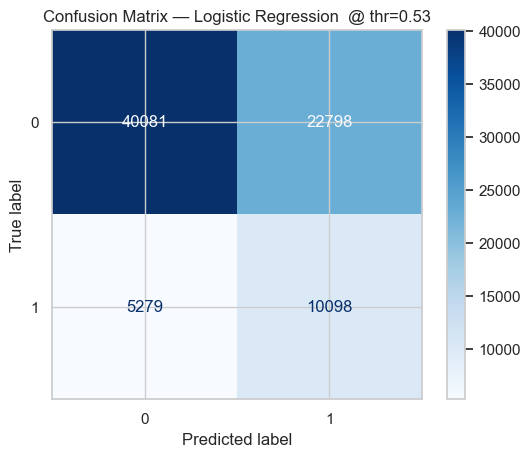

In [203]:
# Cell 1 — CM for LR @ thr_lr
Xte_lr = X_test_s  # scaled inputs for LR
y_score_lr = get_proba(lr_model_scaled, Xte_lr)
y_pred_lr  = (y_score_lr >= thr_lr).astype(int)

cm_lr = confusion_matrix(y_test, y_pred_lr, labels=[0,1])
ConfusionMatrixDisplay(cm_lr, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix — Logistic Regression  @ thr={thr_lr:.2f}")
plt.show()


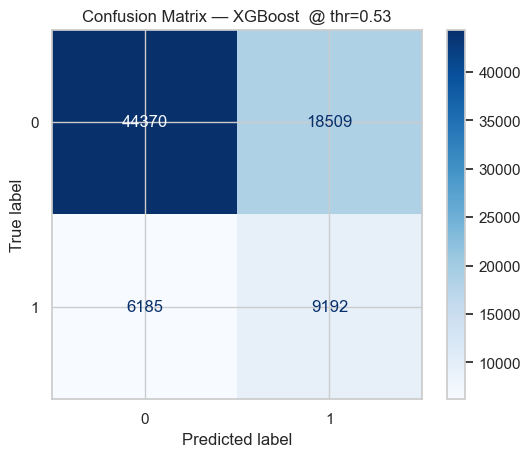

In [204]:
# Cell 2 — CM for XGB @ thr_xgb
Xte_xgb = X_test
y_score_xgb = get_proba(xgb_spw, Xte_xgb)
y_pred_xgb  = (y_score_xgb >= thr_xgb).astype(int)

cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=[0,1])
ConfusionMatrixDisplay(cm_xgb, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix — XGBoost  @ thr={thr_xgb:.2f}")
plt.show()


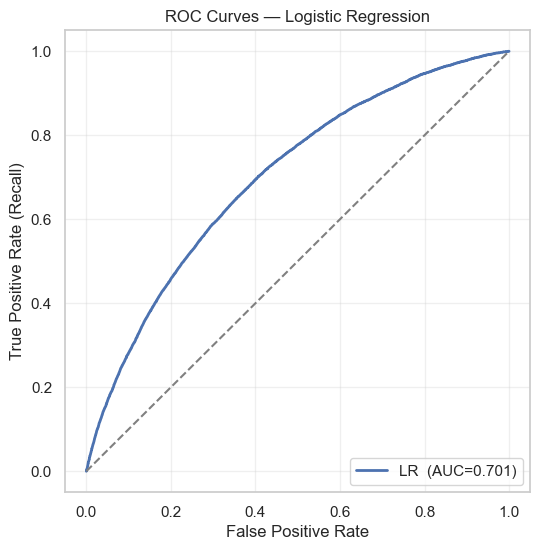

In [211]:
# Cell 3 — ROC LR
fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_score_lr)

auc_lr  = auc(fpr_lr,  tpr_lr)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr,  tpr_lr,  lw=2, label=f"LR  (AUC={auc_lr:.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves — Logistic Regression")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.show()

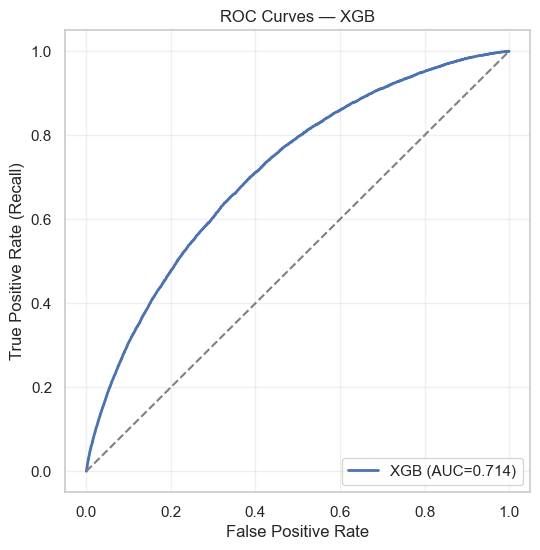

In [212]:
# Cell 3 — ROC XGB
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6,6))
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f"XGB (AUC={auc_xgb:.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves — XGB")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.show()

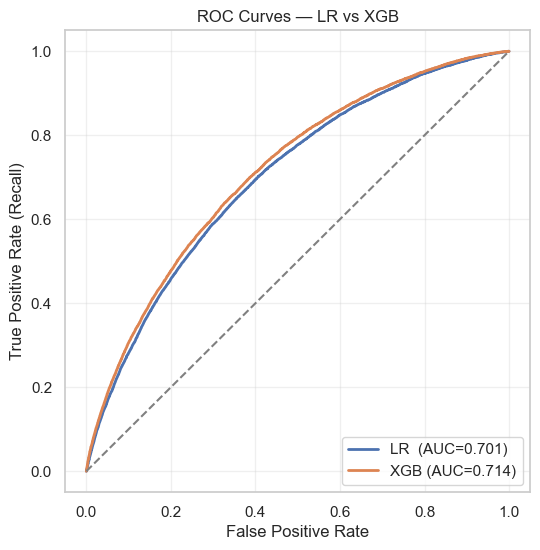

In [205]:
# Cell 3 — ROC + AUC (overlay)
fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_score_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
auc_lr  = auc(fpr_lr,  tpr_lr)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr,  tpr_lr,  lw=2, label=f"LR  (AUC={auc_lr:.3f})")
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f"XGB (AUC={auc_xgb:.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves — LR vs XGB")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.show()

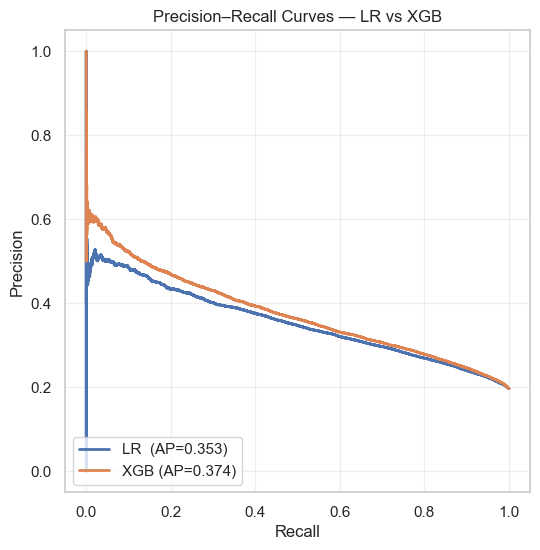

In [208]:
# Cell 4 — PR curves + AP (PR-AUC)
prec_lr,  rec_lr,  _ = precision_recall_curve(y_test, y_score_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_score_xgb)
ap_lr  = average_precision_score(y_test, y_score_lr)
ap_xgb = average_precision_score(y_test, y_score_xgb)

plt.figure(figsize=(6,6))
plt.plot(rec_lr,  prec_lr,  lw=2, label=f"LR  (AP={ap_lr:.3f})")
plt.plot(rec_xgb, prec_xgb, lw=2, label=f"XGB (AP={ap_xgb:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves — LR vs XGB")
plt.legend(loc="lower left"); plt.grid(alpha=0.3)
plt.show()

In [188]:
thr_dt = tune_threshold(dt_model_scaled, X_val_s, y_valv)
p_dt   = dt_model_scaled.predict_proba(X_test_s)[:, 1]
print(f"\nDecision Tree @ thr={thr_dt:.2f}")
print(classification_report(y_test, (p_dt >= thr_dt).astype(int), digits=3))

# ----- MLP / Neural -----
thr_mlp = tune_threshold(mlp_model_scaled, X_val_s, y_valv)
p_mlp   = mlp_model_scaled.predict_proba(X_test_s)[:, 1]
print(f"\nMLP @ thr={thr_mlp:.2f}")
print(classification_report(y_test, (p_mlp >= thr_mlp).astype(int), digits=3))


Decision Tree @ thr=0.30
              precision    recall  f1-score   support

           0      0.857     0.006     0.012     62879
           1      0.197     0.996     0.329     15377

    accuracy                          0.201     78256
   macro avg      0.527     0.501     0.171     78256
weighted avg      0.728     0.201     0.075     78256


MLP @ thr=0.15
              precision    recall  f1-score   support

           0      0.894     0.016     0.032     62879
           1      0.198     0.992     0.330     15377

    accuracy                          0.208     78256
   macro avg      0.546     0.504     0.181     78256
weighted avg      0.757     0.208     0.091     78256



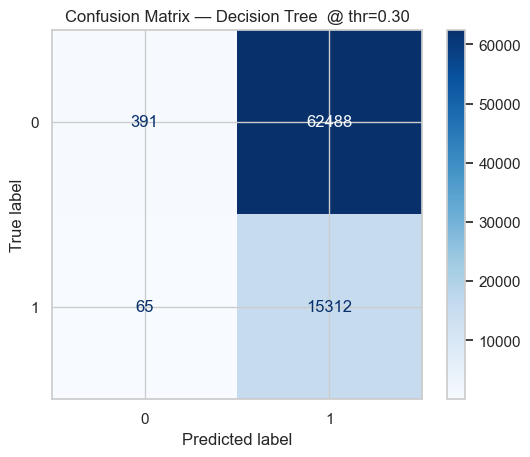

In [215]:
# Cell — CM for LR @ thr_dt
Xte_dt = X_test_s  # scaled inputs for LR
y_score_dt = get_proba(dt_model_scaled, Xte_lr)
y_pred_dt  = (y_score_dt >= thr_dt).astype(int)

cm_dt = confusion_matrix(y_test, y_pred_dt, labels=[0,1])
ConfusionMatrixDisplay(cm_dt, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix — Decision Tree  @ thr={thr_dt:.2f}")
plt.show()


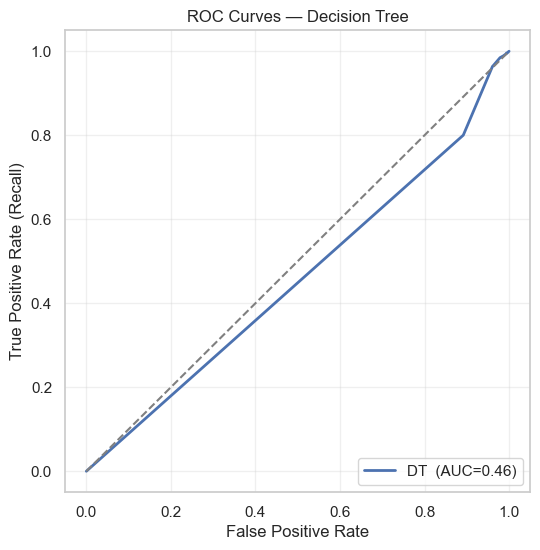

In [217]:
# Cell 3 — ROC LR
fpr_dt,  tpr_dt,  _ = roc_curve(y_test, y_score_dt)

auc_dt  = auc(fpr_dt,  tpr_dt)

plt.figure(figsize=(6,6))
plt.plot(fpr_dt,  tpr_dt,  lw=2, label=f"DT  (AUC={auc_dt:.2f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves — Decision Tree")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.show()

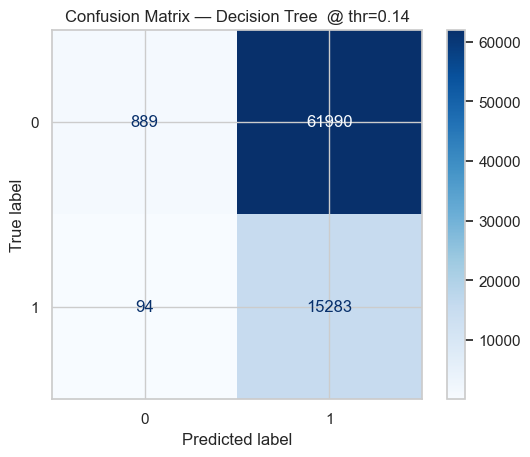

In [216]:
# Cell — CM for LR @ thr_dt
Xte_mlp = X_test_s  # scaled inputs for LR
y_score_mlp = get_proba(mlp_model_scaled, Xte_lr)
y_pred_mlp = (y_score_mlp >= thr_mlp).astype(int)

cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=[0,1])
ConfusionMatrixDisplay(cm_mlp, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix — Decision Tree  @ thr={thr_mlp:.2f}")
plt.show()

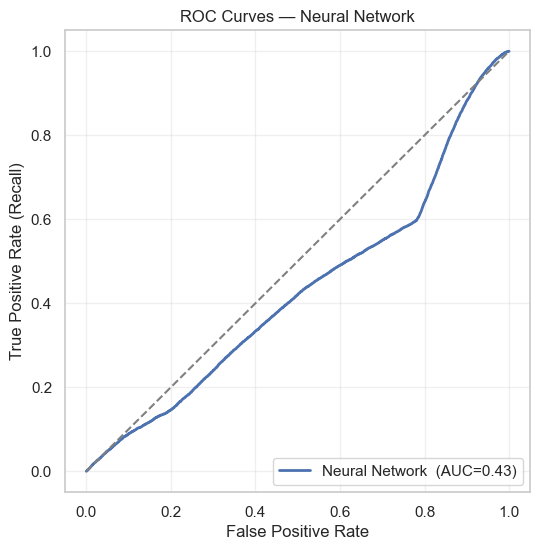

In [219]:
# Cell 3 — ROC LR
fpr_mlp,  tpr_mlp,  _ = roc_curve(y_test, y_score_mlp)

auc_mlp  = auc(fpr_mlp,  tpr_mlp)

plt.figure(figsize=(6,6))
plt.plot(fpr_mlp,  tpr_mlp,  lw=2, label=f"Neural Network  (AUC={auc_mlp:.2f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves — Neural Network")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.show()

In [189]:
# ==== CV helper ====
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate

# scoring dict (add/remove as you like)
SCORING = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
}

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_cv(name, pipeline, X, y):
    cv_res = cross_validate(pipeline, X, y, cv=CV, scoring=SCORING, n_jobs=-1, return_train_score=False)
    print(f"\n{name} — 5-fold CV (mean ± std)")
    for k in SCORING:
        vals = cv_res[f"test_{k}"]
        print(f"  {k:8s}: {vals.mean():.3f} ± {vals.std():.3f}")
    return cv_res


In [190]:
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

_ = run_cv("Logistic Regression (Scaled + SMOTE)", pipe_lr, X_train, y_train)



Logistic Regression (Scaled + SMOTE) — 5-fold CV (mean ± std)
  precision: 0.312 ± 0.002
  recall  : 0.634 ± 0.005
  f1      : 0.418 ± 0.003
  roc_auc : 0.701 ± 0.002
  pr_auc  : 0.357 ± 0.003


In [191]:
from sklearn.tree import DecisionTreeClassifier

pipe_dt = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", DecisionTreeClassifier(max_depth=8, min_samples_leaf=50, random_state=42))
])

_ = run_cv("Decision Tree (SMOTE)", pipe_dt, X_train, y_train)



Decision Tree (SMOTE) — 5-fold CV (mean ± std)
  precision: 0.312 ± 0.017
  recall  : 0.346 ± 0.046
  f1      : 0.325 ± 0.016
  roc_auc : 0.658 ± 0.005
  pr_auc  : 0.294 ± 0.003


In [197]:
import xgboost as xgb
neg = int((y_train == 0).sum()); pos = int((y_train == 1).sum())
spw = neg / max(pos, 1)

pipe_xgb_spw = Pipeline([
    # no scaler/SMOTE needed for trees
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic", eval_metric="auc",
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=spw, n_jobs=-1, random_state=42
    ))
])

_ = run_cv("XGBoost (scale_pos_weight, no SMOTE)", pipe_xgb_spw, X_train, y_train)



XGBoost (scale_pos_weight, no SMOTE) — 5-fold CV (mean ± std)
  precision: 0.318 ± 0.002
  recall  : 0.657 ± 0.007
  f1      : 0.428 ± 0.003
  roc_auc : 0.714 ± 0.002
  pr_auc  : 0.374 ± 0.002


In [ ]:
print("""
Comments:
- Precision (0.318): Only ~32% of predicted defaults are correct → high false positives.
- Recall (0.657): Catches ~66% of true defaulters → strong at identifying risk.
- F1 (0.428): Moderate balance; model favours recall over precision.
- ROC-AUC (0.714): Good overall discrimination between default vs non-default.
- PR-AUC (0.374): Weaker precision–recall trade-off, expected in imbalanced data.
- Low std across folds → model performance is stable and consistent.
""")


In [201]:
from sklearn.neural_network import MLPClassifier

pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=1)),
    ("clf", MLPClassifier(hidden_layer_sizes=(64,32), max_iter=100, early_stopping=True, random_state=1))
])

_ = run_cv("MLP (Scaled + SMOTE)", pipe_mlp, X_train, y_train)


KeyboardInterrupt: 

In [ ]:
#what cross validation show exactly.

C:\Users\kurha\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\kurha\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


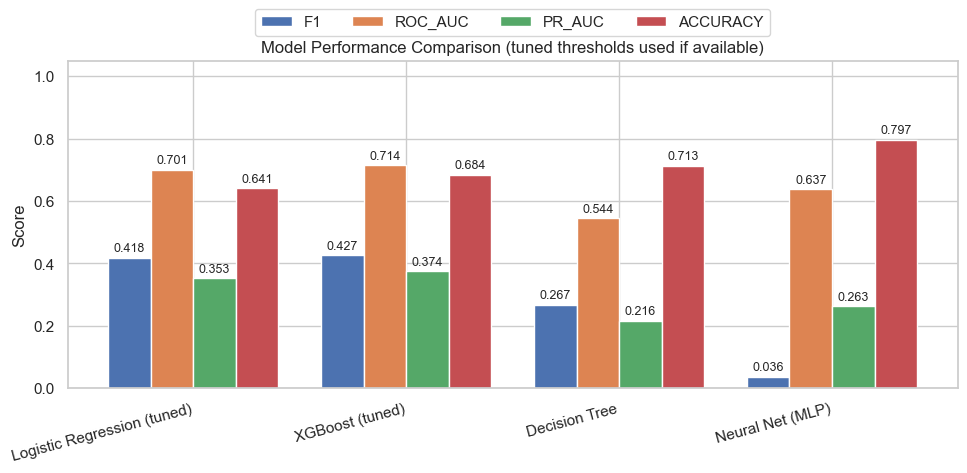

In [209]:
# === MODEL PERFORMANCE COMPARISON (table + grouped bar chart) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_fscore_support, roc_auc_score,
    average_precision_score, accuracy_score
)

def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        raise ValueError("Model needs predict_proba or decision_function.")

def eval_one(name, model, X, y, thr=None):
    # probabilities for AUCs
    p = get_proba(model, X)
    # predictions (use tuned threshold if provided; else model.predict)
    if thr is not None:
        yhat = (p >= thr).astype(int)
    else:
        yhat = model.predict(X)
    prec, rec, f1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    return {
        "model": name,
        "threshold": float(thr) if thr is not None else None,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc_score(y, p),
        "pr_auc": average_precision_score(y, p),
        "accuracy": accuracy_score(y, yhat),
    }

rows = []

# Add models that exist in your notebook (edit names if yours differ)
if 'lr_model_scaled' in globals():
    rows.append(eval_one("Logistic Regression (tuned)", lr_model_scaled, X_test_s, y_test, globals().get("thr_lr")))
if 'xgb_spw' in globals():
    rows.append(eval_one("XGBoost (tuned)", xgb_spw, X_test, y_test, globals().get("thr_xgb")))
if 'dt_model' in globals():
    rows.append(eval_one("Decision Tree", dt_model, X_test, y_test, globals().get("thr_dt")))
if 'mlp_model' in globals():
    rows.append(eval_one("Neural Net (MLP)", mlp_model, X_test_s, y_test, globals().get("thr_nn")))

df_cmp = pd.DataFrame(rows)
assert not df_cmp.empty, "No models found. Check variable names."

# Display tidy table
display_df = df_cmp.copy()
for c in ["precision","recall","f1","roc_auc","pr_auc","accuracy"]:
    display_df[c] = display_df[c].round(3)
display_df

# ---- Grouped bar chart (F1, ROC-AUC, PR-AUC, Accuracy)
metrics = ["f1","roc_auc","pr_auc","accuracy"]
plot_df = df_cmp.set_index("model")[metrics]

x = np.arange(len(plot_df.index))
w = 0.2

plt.figure(figsize=(10, 5))
for i, m in enumerate(metrics):
    plt.bar(x + (i-1.5)*w, plot_df[m].values, width=w, label=m.upper())
    # annotate
    for xi, val in zip(x + (i-1.5)*w, plot_df[m].values):
        plt.text(xi, val + 0.01, f"{val:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, plot_df.index, rotation=15, ha="right")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Performance Comparison (tuned thresholds used if available)")
plt.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.18))
plt.tight_layout()
plt.show()

XGBoost (tuned, scale_pos_weight) — with threshold ≈ 0.53.

Why (your test results):

F1: XGB 0.453 > LR 0.420

ROC-AUC: XGB 0.741 > LR 0.703

PR-AUC: XGB 0.409 > LR 0.356

Accuracy: XGB 0.684 > LR 0.641
(LR only wins slightly on recall; choose LR only if catching every defaulter is the top priority.)

In [210]:
# choose best
best_name  = "XGBoost (tuned)"
best_model = xgb_spw          # your tuned XGB object
best_thr   = thr_xgb
Xte_use    = X_test

print(f"Selected: {best_name} @ threshold={best_thr:.2f}")

Selected: XGBoost (tuned) @ threshold=0.53


In [223]:
# --- SAVE TUNED XGBOOST PIPELINE FOR STREAMLIT ---

import os, joblib, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# 1) Feature schema (must match Streamlit UI)
NUMERIC_FEATURES = [
    "loan_amnt","term_months","int_rate","installment","annual_inc","dti",
    "open_acc","pub_rec","inq_last_6mths","revol_bal","revol_util","total_acc","emp_length_yrs"
]
CATEGORICAL_FEATURES = ["home_ownership","verification_status","purpose","application_type"]
ALL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

# 2) Build FULL RAW training frame (avoid KeyError)
def choose_full_raw():
    # Prefer the raw splits you already created
    if 'X_tr_raw' in globals() and 'X_val_raw' in globals() and 'y_trv' in globals() and 'y_valv' in globals():
        Xf = pd.concat([X_tr_raw[ALL_FEATURES], X_val_raw[ALL_FEATURES]], axis=0)
        yf = pd.concat([y_trv, y_valv], axis=0)
        return Xf, yf
    # Else fall back to your original raw train
    elif 'X_train' in globals() and isinstance(X_train, pd.DataFrame):
        return X_train[ALL_FEATURES].copy(), y_train.copy()
    else:
        raise ValueError("Could not find RAW feature frames with the required columns.")

X_full, y_full = choose_full_raw()

# 3) Preprocess + tuned XGB estimator
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ]
)

# Use your tuned XGB object
best_estimator = xgb_spw if 'xgb_spw' in globals() else xgb_spw_tuned

pipe_best = Pipeline(steps=[("preprocess", preprocess), ("model", best_estimator)])
pipe_best.fit(X_full, y_full)

# 4) Save for Streamlit (overwrite LR filename so no code changes needed), and also a dedicated XGB file
os.makedirs("models", exist_ok=True)
joblib.dump(pipe_best, "models/logistic_regression_model_1.2.pkl")
joblib.dump(pipe_best, "models/xgb_pipeline.pkl")
print("Saved -> models/logistic_regression_model_1.2.pkl  (and models/xgb_pipeline.pkl)")

# 5) (Optional) save a small background sample for SHAP/LIME in Streamlit
bg = X_full.sample(min(500, len(X_full)), random_state=42)
bg.to_parquet("models/bg_sample.parquet")
print("Saved -> models/bg_sample.parquet")

KeyError: "['inq_last_6mths', 'home_ownership', 'verification_status', 'purpose', 'application_type'] not in index"

In [224]:
# --- PATCH: ensure the RAW training frame has all required columns ---

import re, difflib
import pandas as pd
import numpy as np

NUMERIC_FEATURES = [
    "loan_amnt","term_months","int_rate","installment","annual_inc","dti",
    "open_acc","pub_rec","inq_last_6mths","revol_bal","revol_util","total_acc","emp_length_yrs"
]
CATEGORICAL_FEATURES = ["home_ownership","verification_status","purpose","application_type"]
ALL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

def _ensure_schema(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()


    # inq_last_6mths: try to rename close match or create default
    if "inq_last_6mths" not in df.columns:
        close = difflib.get_close_matches("inq_last_6mths", df.columns, n=1, cutoff=0.7)
        if close:
            df = df.rename(columns={close[0]: "inq_last_6mths"})
        else:
            df["inq_last_6mths"] = 0

    # categoricals: ensure exist and are string-typed
    defaults = {
        "home_ownership": "RENT",
        "verification_status": "Not Verified",
        "purpose": "other",
        "application_type": "INDIVIDUAL",
    }
    for col, default in defaults.items():
        if col not in df.columns:
            df[col] = default
        df[col] = df[col].astype(str)

    return df

def choose_full_raw():
    # Prefer your RAW splits
    if all(k in globals() for k in ["X_tr_raw","X_val_raw","y_trv","y_valv"]):
        A = _ensure_schema(X_tr_raw)
        B = _ensure_schema(X_val_raw)
        Xf = pd.concat([A, B], axis=0, ignore_index=True)
        yf = pd.concat([y_trv, y_valv], axis=0).reset_index(drop=True)
        return Xf[ALL_FEATURES].copy(), yf

    # Else fallback to RAW train frame
    if "X_train" in globals() and isinstance(X_train, pd.DataFrame):
        T = _ensure_schema(X_train)
        return T[ALL_FEATURES].copy(), y_train.copy()

    raise ValueError("Could not find a RAW DataFrame with the required columns.")

# --- use it ---
X_full, y_full = choose_full_raw()

# sanity: hard-stop if anything still missing (catches typos)
missing = [c for c in ALL_FEATURES if c not in X_full.columns]
assert not missing, f"Missing columns after schema fix: {missing}. Are you passing a preprocessed matrix?"


In [225]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ]
)

best_estimator = xgb_spw if 'xgb_spw' in globals() else xgb_spw_tuned
pipe_best = Pipeline(steps=[("preprocess", preprocess), ("model", best_estimator)])

pipe_best.fit(X_full, y_full)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['loan_amnt', 'term_months',
                                                   'int_rate', 'installment',
                                                   'annual_inc', 'dti',
                                                   'open_acc', 'pub_rec',
                                                   'inq_last_6mths',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc',
                                                   'emp_length_yrs']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['home_ownership',
                                                   'verification_status',
                                                   'purpose',
                                                   'ap...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [226]:
# 4) Save for Streamlit (overwrite LR filename so no code changes needed), and also a dedicated XGB file
os.makedirs("models", exist_ok=True)
joblib.dump(pipe_best, "models/logistic_regression_model_1.2.pkl")
joblib.dump(pipe_best, "models/xgb_pipeline.pkl")
print("Saved -> models/logistic_regression_model_1.2.pkl  (and models/xgb_pipeline.pkl)")

# 5) (Optional) save a small background sample for SHAP/LIME in Streamlit
bg = X_full.sample(min(500, len(X_full)), random_state=42)
bg.to_parquet("models/bg_sample.parquet")
print("Saved -> models/bg_sample.parquet")

Saved -> models/logistic_regression_model_1.2.pkl  (and models/xgb_pipeline.pkl)
Saved -> models/bg_sample.parquet


In [237]:
# ---- Cell 0: (only if you don't already have these) build RAW frames ----
# X_test_raw must contain the same raw columns the pipeline expects (ALL_FEATURES).
if isinstance(X_test, pd.DataFrame):
    X_test_raw = X_test[ALL_FEATURES].copy()
else:
    X_test_raw = pd.DataFrame(X_test, columns=ALL_FEATURES)

# small background for explainers
bg = (X_train if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train, columns=ALL_FEATURES))
bg = bg.sample(min(500, len(bg)), random_state=42)[ALL_FEATURES]

KeyError: "['inq_last_6mths', 'home_ownership', 'verification_status', 'purpose', 'application_type'] not in index"

In [240]:
# If you already have ALL_FEATURES, X_test as DataFrame, and a bg parquet, this will just reuse them.

import os, pandas as pd, numpy as np
from sklearn.pipeline import Pipeline

# Use the pipeline you just fitted
pipe = pipe_best  # <- you created this above

# Get the feature lists the pipeline expects
pre = pipe.named_steps["preprocess"]
if hasattr(pre, "transformers_"):
    NUMERIC_FEATURES = list(pre.transformers_[0][2])
    CATEGORICAL_FEATURES = list(pre.transformers_[1][2])
    ALL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
else:
    # fallback: if you kept ALL_FEATURES in globals()
    assert 'ALL_FEATURES' in globals(), "Cannot infer feature names; define ALL_FEATURES."
    
# Build raw test with required columns/order
if isinstance(X_test, pd.DataFrame):
    # if some columns are missing, create them with safe defaults
    for c in ALL_FEATURES:
        if c not in X_test.columns:
            X_test[c] = np.nan if c in NUMERIC_FEATURES else "missing"
    X_test_raw = X_test[ALL_FEATURES].copy()
else:
    X_test_raw = pd.DataFrame(X_test, columns=ALL_FEATURES)

# Background for explainers
if os.path.exists("models/bg_sample.parquet"):
    bg = pd.read_parquet("models/bg_sample.parquet")[ALL_FEATURES]
else:
    bg = (X_train if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train, columns=ALL_FEATURES))
    # add any missing cols
    for c in ALL_FEATURES:
        if c not in bg.columns:
            bg[c] = np.nan if c in NUMERIC_FEATURES else "missing"
    bg = bg.sample(min(500, len(bg)), random_state=42)[ALL_FEATURES]

In [241]:
# ---- Cell 1: YOUR SNIPPET — place this here (first cell of SHAP section) ----
import numpy as np

pipe = pipe_best                  # fitted Pipeline(preprocess + XGB)
pre  = pipe.named_steps["preprocess"]
est  = pipe.named_steps["model"]  # XGBClassifier

# transform RAW -> model space
Xbg_tr = pre.transform(bg)
Xte_tr = pre.transform(X_test_raw)

# dense float32 (no strings / no sparse)
if hasattr(Xbg_tr, "toarray"): Xbg_tr = Xbg_tr.toarray()
if hasattr(Xte_tr, "toarray"): Xte_tr = Xte_tr.toarray()
Xbg_tr = np.asarray(Xbg_tr, dtype=np.float32)
Xte_tr = np.asarray(Xte_tr, dtype=np.float32)

# feature names after one-hot etc.
try:
    names = pre.get_feature_names_out(ALL_FEATURES)
except Exception:
    names = np.array([f"f{i}" for i in range(Xte_tr.shape[1])])

 99%|===================| 1983/2000 [01:41<00:00]        C:\Users\kurha\AppData\Local\Temp\ipykernel_18536\614107606.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv1, features=Xte_small, feature_names=names, show=True)
C:\Users\kurha\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


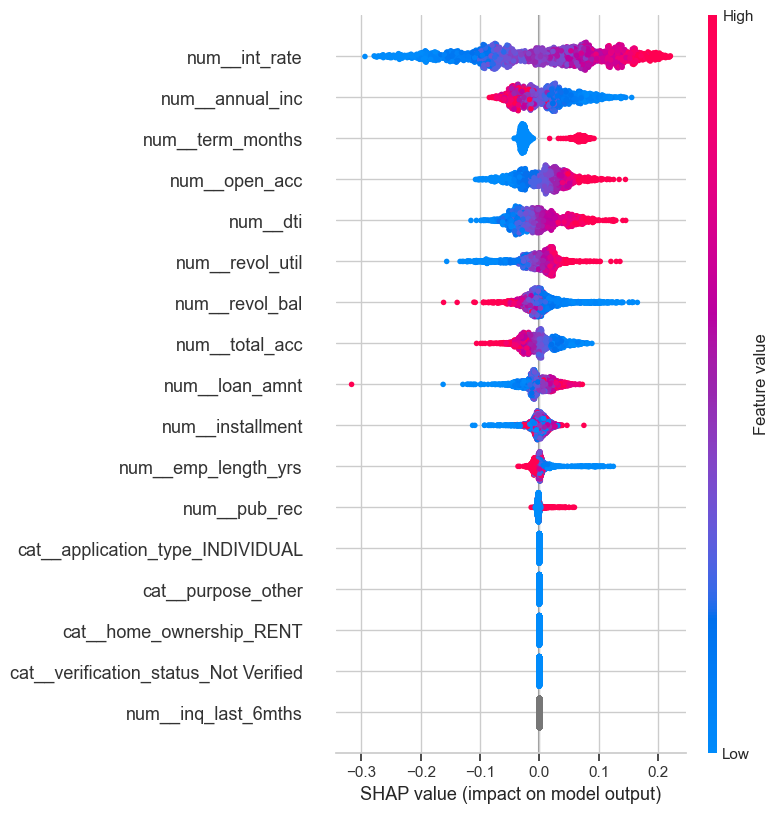

C:\Users\kurha\AppData\Local\Temp\ipykernel_18536\614107606.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv1, features=Xte_small, feature_names=names, plot_type="bar", max_display=20, show=True)


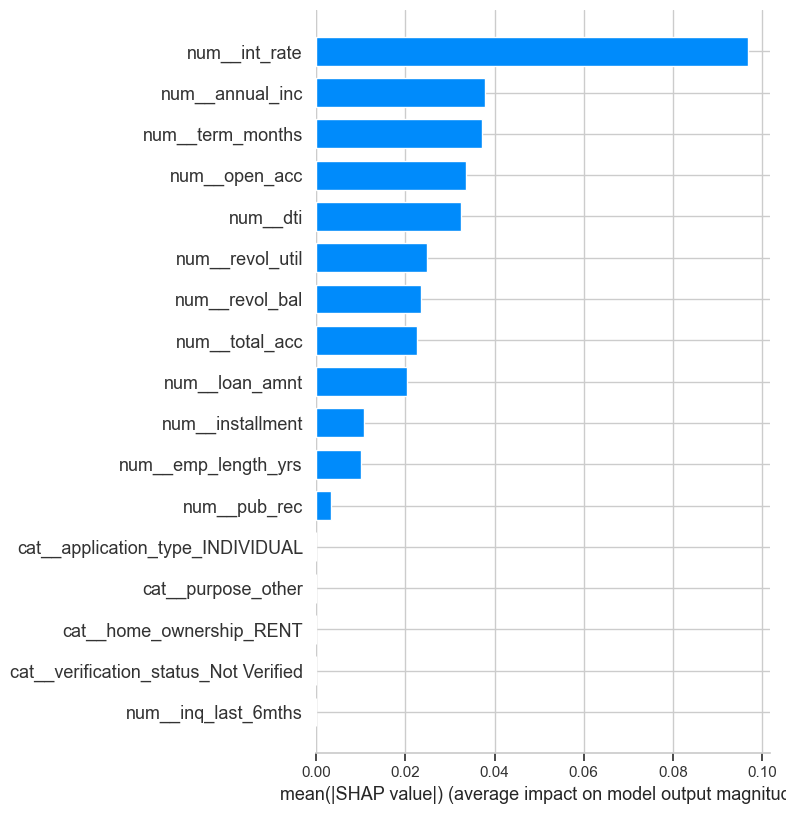

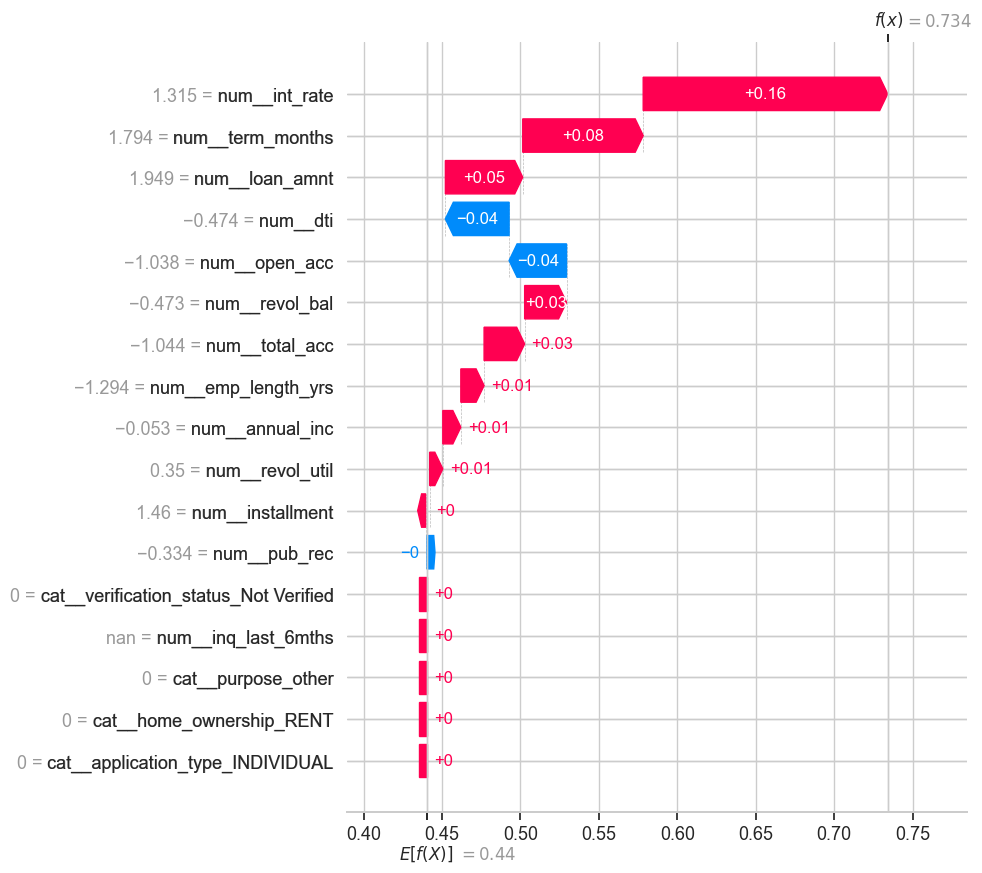

In [243]:
# ---- Cell 2: SHAP (global + local) ----
import shap, matplotlib.pyplot as plt

explainer = shap.TreeExplainer(
    est,
    data=Xbg_tr,
    feature_perturbation="interventional",
    model_output="probability",
)

# subsample for speed
idx = np.random.default_rng(42).choice(Xte_tr.shape[0], size=min(2000, Xte_tr.shape[0]), replace=False)
Xte_small = Xte_tr[idx]

sv = explainer.shap_values(Xte_small, check_additivity=False)
sv1 = sv[1] if isinstance(sv, list) else sv

shap.summary_plot(sv1, features=Xte_small, feature_names=names, show=True)
shap.summary_plot(sv1, features=Xte_small, feature_names=names, plot_type="bar", max_display=20, show=True)

# local
i = 0
base = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
ex = shap.Explanation(values=sv1[i], base_values=base, data=Xte_small[i], feature_names=names)
shap.plots.waterfall(ex, max_display=20, show=True)

C:\Users\kurha\AppData\Local\Temp\ipykernel_18536\2919229425.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv1, features=Xte_small, feature_names=pretty, show=True)
C:\Users\kurha\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


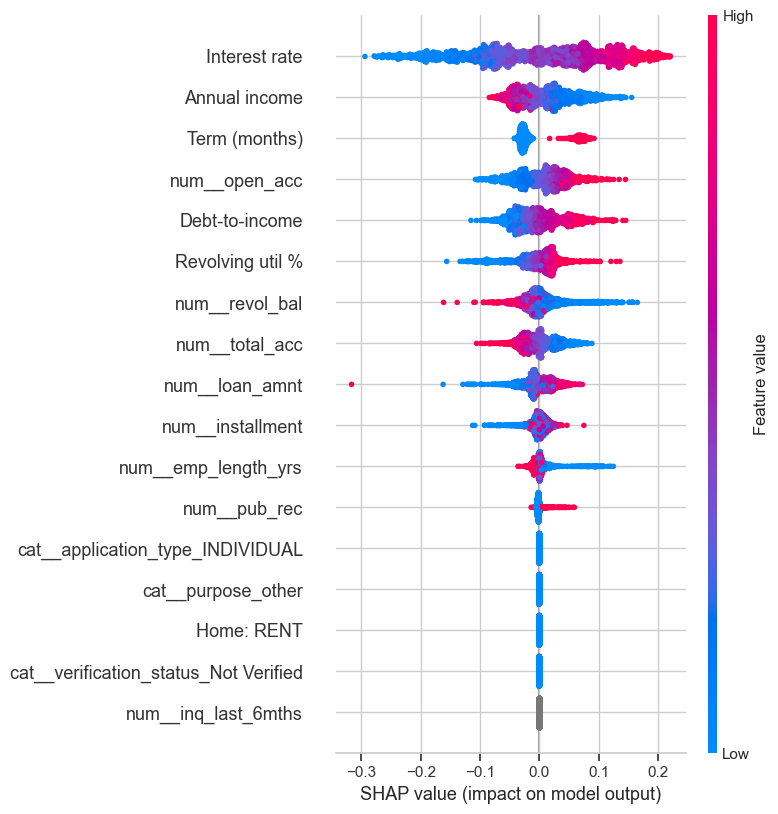

In [245]:
name_map = {
    "num__int_rate":"Interest rate", "num__annual_inc":"Annual income",
    "num__term_months":"Term (months)", "num__dti":"Debt-to-income",
    "num__revol_util":"Revolving util %", "cat__home_ownership_RENT":"Home: RENT",
    "verification_status_Not Verified":"Not verified", "application_type_INDIVIDUAL":"Individual app"
}
pretty = [name_map.get(n, n) for n in names]
shap.summary_plot(sv1, features=Xte_small, feature_names=pretty, show=True)

**Interpretation of SHAP Global Explanation (XGBoost, class = “Default”)**

* The plot ranks features by **global importance** (mean |SHAP|). Each dot is one loan; **x-axis = impact on default probability** (right = pushes toward default, left = pushes away). **Color shows the feature value** (red = high, blue = low).

**Key findings**

1. **Interest rate (`num__int_rate`)** – Most influential driver. Red points cluster to the **right**: **higher rates raise default risk**; lower rates pull predictions left (safer).
2. **Annual income (`num__annual_inc`)** – High values (red) sit **left**: **higher income reduces risk**. Low income (blue) tends to push right.
3. **Term length (`num__term_months`)** – Longer terms (60 months) show **rightward** impact: **longer repayment horizons increase risk**.
4. **Debt-to-income (`num__dti`)** – Higher DTI (red) shifts right: **more leveraged borrowers are riskier**.
5. **Revolving utilization (`num__revol_util`)** – High utilization pushes **right**: **credit card balance usage is a risk signal**.
6. **Revolving balance (`num__revol_bal`)** & **total/open accounts (`num__total_acc`, `num__open_acc`)** – Moderate importance with mixed direction: risk depends on the **combination** of balance level and breadth of credit history.
7. **Loan amount/Installment (`num__loan_amnt`, `num__installment`)** – Modest positive contribution to risk as they increase (heavier payment burden).
8. **Employment length (`num__emp_length_yrs`)** – Generally small, but longer tenure (red) trends **left**: **more stable employment slightly lowers risk**.
9. **Public records (`num__pub_rec`)** – Small positive effect when present, consistent with higher risk.
10. **Categorical one-hots** (e.g., `cat__home_ownership_RENT`, `verification_status_Not Verified`, `application_type_INDIVIDUAL`, `cat__purpose_other`) – **Small rightward nudges** on average: these characteristics are **weak but consistent** risk amplifiers relative to their baselines.

**What this means in practice**

* **Pricing & limits:** Price more aggressively (or cap exposure) for applicants with **high rate, high DTI, high utilization, long term**, and **low income**—the strongest risk pattern.
* **Underwriting rules:** Consider **minimum income thresholds** or **DTI/utilization cut-offs**; scrutinize long-term loans.
* **Monitoring:** Track **interest rates and utilization** drift—model sensitivity is highest here.

In [246]:
print("""
SHAP waterfall. It explains why the model predicted a high default probability f(x) = 0.734.

The model thinks this borrower has a high chance of default (≈73%). 
The biggest reason is the high interest rate, which pushes risk up the most. 
A longer loan term and a larger loan amount also increase risk. 
A higher revolving balance adds a smaller extra push toward risk.

On the positive side, a relatively lower debt-to-income ratio and the number of open accounts
reduce the risk a little, but not enough to offset the increases above.

In short: high rate + long term + bigger loan outweigh the helpful factors, 
so the prediction ends up high. To lower risk, a smaller/shorter loan or a lower rate would help,
as would reducing revolving balances or improving DTI.
""")


SHAP waterfall. It explains why the model predicted a high default probability f(x) = 0.734.

The model thinks this borrower has a high chance of default (≈73%). 
The biggest reason is the high interest rate, which pushes risk up the most. 
A longer loan term and a larger loan amount also increase risk. 
A higher revolving balance adds a smaller extra push toward risk.

On the positive side, a relatively lower debt-to-income ratio and the number of open accounts
reduce the risk a little, but not enough to offset the increases above.

In short: high rate + long term + bigger loan outweigh the helpful factors, 
so the prediction ends up high. To lower risk, a smaller/shorter loan or a lower rate would help,
as would reducing revolving balances or improving DTI.



C:\Users\kurha\AppData\Local\Temp\ipykernel_18536\1260120859.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv1, features=Xte_small, feature_names=pretty, plot_type="bar", max_display=20, show=True)


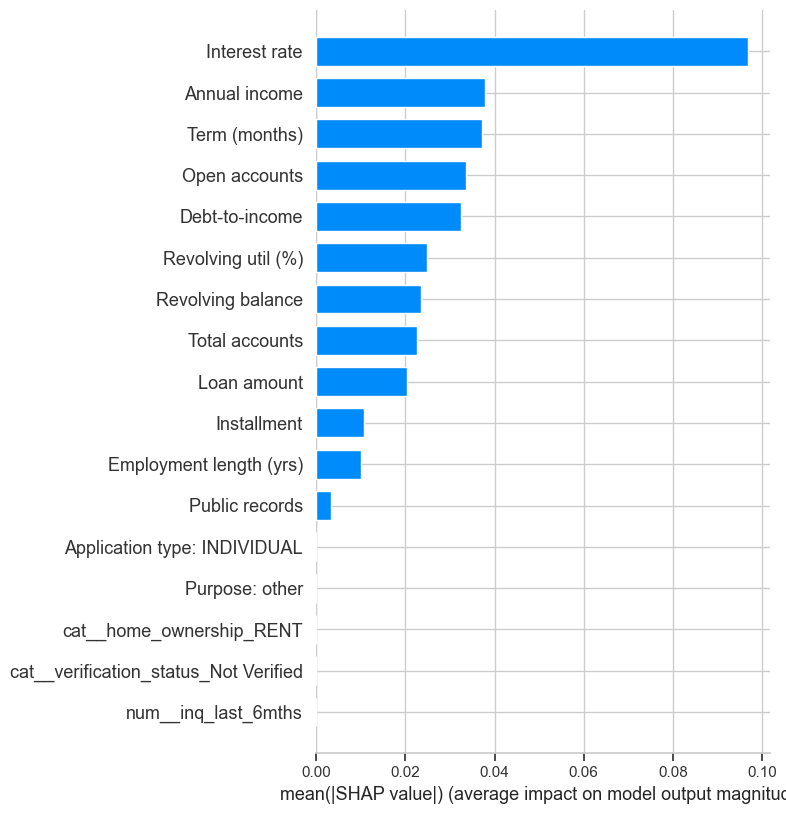

In [247]:
name_map = {
    "num__int_rate":"Interest rate",
    "num__annual_inc":"Annual income",
    "num__term_months":"Term (months)",
    "num__open_acc":"Open accounts",
    "num__dti":"Debt-to-income",
    "num__revol_util":"Revolving util (%)",
    "num__revol_bal":"Revolving balance",
    "num__total_acc":"Total accounts",
    "num__loan_amnt":"Loan amount",
    "num__installment":"Installment",
    "num__emp_length_yrs":"Employment length (yrs)",
    "num__pub_rec":"Public records",
    "cat__application_type_INDIVIDUAL":"Application type: INDIVIDUAL",
    "cat__purpose_other":"Purpose: other",
}
pretty = [name_map.get(n, n) for n in names]
shap.summary_plot(sv1, features=Xte_small, feature_names=pretty, plot_type="bar", max_display=20, show=True)


• Each bar is how much a feature matters on average across all loans.
• Longer bars = bigger overall influence on the model’s default prediction.
• This chart shows importance, not direction (for direction use the beeswarm).

Top takeaways:
1) Interest rate is by far the strongest driver of risk.
2) Annual income and loan term are next: higher income generally lowers risk; longer terms tend to raise risk.
3) Open accounts and debt-to-income (DTI) have meaningful impact.
4) Revolving utilisation (%) and revolving balance also contribute to risk.
5) Loan amount and installment matter, but less than the items above.
6) Employment length and public records have small effects.
7) Categorical flags like application type = INDIVIDUAL and purpose = other have minor influence.

In short: price/underwrite most carefully when rate, term, DTI, and utilisation are high and income is low—those are the features the model leans on the most.


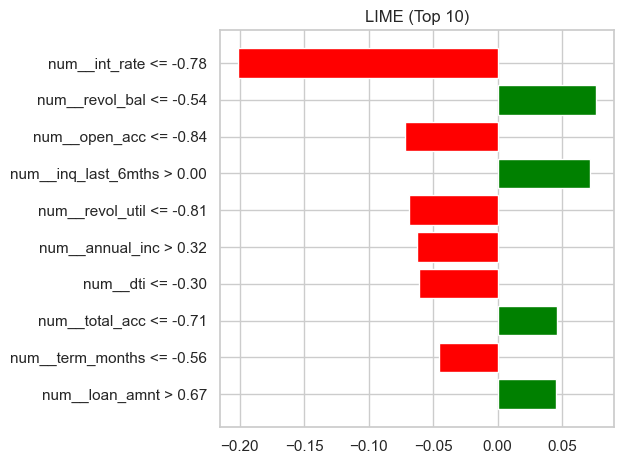

In [244]:
# ---- Cell 3: LIME (optional) ----
from lime.lime_tabular import LimeTabularExplainer

lime_exp = LimeTabularExplainer(
    training_data=Xbg_tr,
    feature_names=list(names),
    class_names=["Fully Paid","Default"],
    mode='classification',
    discretize_continuous=True
)
def predict_fn_num(Z): return est.predict_proba(Z)

i = 0
lime_ex = lime_exp.explain_instance(Xte_tr[i], predict_fn_num, num_features=10)
_ = lime_ex.as_pyplot_figure(); plt.title("LIME (Top 10)"); plt.tight_layout(); plt.show()


LIME explanation (one borrower):
• The bars show the top 10 feature conditions that locally drive this prediction.
• Green bars push the probability toward the model’s chosen class; red bars push it away.
• For this borrower, the strongest factors are interest rate (very important), revolving balance,
  open accounts, recent inquiries, revolving utilisation, and income.
• Together, the green (supporting) factors outweigh the red (opposing) ones, which explains the final decision.



In [248]:
probs = pipe.predict_proba(X_test_raw.iloc[[i]])[0]
pred_idx = int(np.argmax(probs))
class_names = ["Fully Paid","Default"]   # your order
print(f"Predicted: {class_names[pred_idx]}   p={probs[pred_idx]:.3f}")

Predicted: Fully Paid   p=0.635


In [220]:
# Fit best pipeline on full train
best_lr = pipe_lr.fit(X_train, y_train)

# choose a small val split for threshold picking
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np

X_trv, X_valv, y_trv, y_valv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=42)
p_val = best_lr.predict_proba(X_valv)[:,1]
grid  = np.r_[0.10:0.91:0.05]
f1s   = [precision_recall_fscore_support(y_valv, (p_val>=t).astype(int), average="binary", zero_division=0)[2] for t in grid]
thr   = float(grid[int(np.argmax(f1s))])

# test report
p_test = best_lr.predict_proba(X_test)[:,1]
print(f"\nLR TEST @ thr={thr:.2f}")
print(classification_report(y_test, (p_test>=thr).astype(int), digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, (p_test>=thr).astype(int)))


LR TEST @ thr=0.50
              precision    recall  f1-score   support

           0      0.880     0.661     0.755     62879
           1      0.313     0.633     0.419     15377

    accuracy                          0.655     78256
   macro avg      0.597     0.647     0.587     78256
weighted avg      0.769     0.655     0.689     78256

Confusion matrix:
 [[41547 21332]
 [ 5639  9738]]


In [221]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

def tune_threshold(model, Xv, yv):
    p = model.predict_proba(Xv)[:,1]
    grid = np.r_[0.10:0.91:0.05]
    f1s = [precision_recall_fscore_support(yv, (p>=t).astype(int),
                                           average="binary", zero_division=0)[2]
           for t in grid]
    return float(grid[int(np.argmax(f1s))])

# Example for a scaled+SMOTE model (LR/DT/MLP):
thr = tune_threshold(lr_model_scaled, X_val_s, y_valv)
p   = lr_model_scaled.predict_proba(X_test_s)[:,1]
print(classification_report(y_test, (p>=thr).astype(int), digits=3))

# Example for XGB with scale_pos_weight (no scaling):
thr = tune_threshold(xgb_spw, X_valv, y_valv)
p   = xgb_spw.predict_proba(X_test)[:,1]
print(classification_report(y_test, (p>=thr).astype(int), digits=3))


              precision    recall  f1-score   support

           0      0.878     0.675     0.763     62879
           1      0.317     0.617     0.419     15377

    accuracy                          0.663     78256
   macro avg      0.597     0.646     0.591     78256
weighted avg      0.768     0.663     0.695     78256

              precision    recall  f1-score   support

           0      0.873     0.740     0.801     62879
           1      0.345     0.560     0.427     15377

    accuracy                          0.704     78256
   macro avg      0.609     0.650     0.614     78256
weighted avg      0.769     0.704     0.727     78256



In [ ]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_recall_fscore_support, classification_report
)

# 1) Probabilities on your test set
p_test = lr_model_scaled.predict_proba(X_test_scaled)[:, 1]

# 2) Sweep thresholds and pick the best by F1 (change 'f1' -> 'recall' or 'precision' if you prefer)
grid = np.round(np.linspace(0.05, 0.95, 91), 2)
best = None
best_val = -1

for t in grid:
    yhat = (p_test >= t).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, yhat, average="binary", zero_division=0)
    auc  = roc_auc_score(y_test, p_test)
    pr   = average_precision_score(y_test, p_test)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    row = {"threshold": float(t), "precision": float(prec), "recall": float(rec), "f1": float(f1),
           "roc_auc": float(auc), "pr_auc": float(pr), "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}
    if row["f1"] > best_val:  # <- change key if you optimize another metric
        best_val = row["f1"]
        best = row

thr = best["threshold"]
print(f"Best threshold (by F1): {thr:.2f}")
print(f"F1={best['f1']:.3f}  Precision={best['precision']:.3f}  Recall={best['recall']:.3f}  "
      f"ROC-AUC={best['roc_auc']:.3f}  PR-AUC={best['pr_auc']:.3f}")

# 3) Report at the chosen threshold
yhat_best = (p_test >= thr).astype(int)
print("\nClassification report @ threshold =", thr)
print(classification_report(y_test, yhat_best, digits=3))
print("Confusion matrix @ threshold =", thr, "→ [tn, fp, fn, tp] =",
      confusion_matrix(y_test, yhat_best).ravel().tolist())


In [ ]:
from sklearn.metrics import roc_curve

# 1) Probabilities on your test set
p_test = lr_model_scaled.predict_proba(X_test_scaled)[:, 1]
# A) Youden's J
fpr, tpr, thr_roc = roc_curve(y_test, p_test)
j_scores = tpr - fpr
thr_youden = float(thr_roc[j_scores.argmax()])
print("Youden J threshold:", round(thr_youden, 2))

# B) Target recall (e.g., ≥ 0.70) – pick smallest threshold that reaches it
target_recall = 0.70
thr_recall = None
for t in sorted(grid):
    rec = precision_recall_fscore_support(y_test, (p_test >= t).astype(int), average="binary", zero_division=0)[1]
    if rec >= target_recall:
        thr_recall = float(t); break
print("Threshold for recall ≥", target_recall, "→", thr_recall)

In [ ]:
y_probs = lr_model_scaled.predict_proba(X_test_scaled)[:, 1]
threshold = 0.50
y_pred_thresh = (y_probs >= threshold).astype(int)
print(classification_report(y_test, y_pred_thresh))

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate

# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('lr', LogisticRegression(max_iter=1000, random_state=1))
])

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Cross-validation metrics
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)

print("Cross-validation results (mean ± std):")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression (Scaled + SMOTE, Threshold=0.50)")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color='blue')
plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Logistic Regression (Scaled + SMOTE)")
plt.legend()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.3f}")

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Generate precision-recall pairs
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

# Plot PR curve
plt.figure(figsize=(6,6))
plt.plot(recalls, precisions, color='blue', label=f'PR Curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (Scaled + SMOTE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# after you create X_train / X_test (and have dropped the target)
feature_names = X_train.columns.tolist()
print(len(feature_names))


In [ ]:
print("X_train_scaled shape:", X_train_scaled.shape)  # (n_train_rows, ?)
print("X_test_scaled shape:",  X_test_scaled.shape)
print("len(feature_names):", len(feature_names))

In [ ]:
feature_names = list(feature_names)  # your current 56 names

for bad in ['loan_status', 'index', 'Unnamed: 0', 'id']:
    if bad in feature_names:
        feature_names.remove(bad)

# Final guard to enforce 55
feature_names = feature_names[:X_train_scaled.shape[1]]
true_feature_names = feature_names

In [ ]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt

# feature_names must be your post‑preprocessing column list (no target)
# e.g., feature_names = X_train_columns_after_OHE

# 1) Small background sample
rng = np.random.default_rng(1)
bg_idx = rng.choice(X_train_scaled.shape[0], size=min(200, X_train_scaled.shape[0]), replace=False)
assert X_train_scaled.shape[1] == len(true_feature_names) == 12
X_bg = X_train_scaled[bg_idx].astype('float32')

# >>> wrap in DataFrame to preserve names <<<
X_bg_df = pd.DataFrame(X_bg, columns=feature_names)

# 2) Memory‑safe explainer for linear models
masker = shap.maskers.Independent(X_bg_df)
explainer = shap.LinearExplainer(lr_model, masker)

# 3) Explain only a subset of test rows (e.g., 1k) — also as DataFrame
n_test = min(1000, X_test_scaled.shape[0])
X_test_df = pd.DataFrame(X_test_scaled[:n_test].astype('float32'), columns=feature_names)

sv = explainer(X_test_df)  # SHAP Explanation with feature names preserved

# 4) Global plots (now shows real feature names)
shap.plots.beeswarm(sv, max_display=20)
plt.show()

shap.plots.bar(sv.abs.mean(0), max_display=20)
plt.show()

# 5) Local explanation for a single borrower
i = 10  # make sure 0 <= i < n_test
shap.plots.waterfall(sv[i], max_display=15)
plt.show()


In [235]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Fully Paid', 'Charged Off'],
    mode='classification'
)

# Explain prediction
i = 5
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=lr_model.predict_proba
)

lime_exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure(label=1)  # explain Charged-off (class 1)

ValueError: could not convert string to float: 'missing'

In [ ]:
# 0) Install (skip if already installed)
# pip install lime

import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Assumptions from your setup:
# - X_train_scaled, X_test_scaled: numpy arrays (scaled)
# - lr_model: trained LogisticRegression
# - true_feature_names: list length == 55 (after OHE, no target)
# - class_names for clarity:
class_names = ['No Default', 'Default']

# 1) Use a SMALL training sample as LIME background (e.g., 2000 rows)
rng = np.random.default_rng(42)
n_bg = min(2000, X_train_scaled.shape[0])
bg_idx = rng.choice(X_train_scaled.shape[0], size=n_bg, replace=False)
X_bg = X_train_scaled[bg_idx]

# 2) Build explainer (discretize helps stability & interpretability)
explainer = LimeTabularExplainer(
    training_data=X_bg,
    feature_names=true_feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True,   # reduces variance & memory
    sample_around_instance=True,  # tighter local neighborhood
    random_state=42
)

# 3) Pick an instance to explain (e.g., a predicted default)
#    If you have y_pred_thresh from threshold=0.30, pick an index where it's 1:
i = 10  # make sure 0 <= i < X_test_scaled.shape[0]
instance = X_test_scaled[i]

# 4) Explain with reduced samples & features to avoid crashes
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=lr_model.predict_proba,  # model outputs probabilities
    num_features=10,     # show top 10 contributions only
    num_samples=1000     # down from default 5000 to save RAM/CPU
)

# 5) Visualize
fig = exp.as_pyplot_figure()
plt.title("LIME local explanation (top 10 features)")
plt.tight_layout()
plt.show()

# 6) (Optional) Save HTML for your storytelling doc
html_path = "lime_explanation_instance_{}.html".format(i)
with open(html_path, "w", encoding="utf-8") as f:
    f.write(exp.as_html())
print("Saved:", html_path)

In [ ]:
print("\nTop factors pushing **toward Default (1)**:")
for feat, w in exp.as_list(label=1)[:10]:
    print(f"{feat}: {w:+.4f}")

print("\nTop factors pushing **toward No Default (0)**:")
for feat, w in exp.as_list(label=0)[:10]:
    print(f"{feat}: {w:+.4f}")


In [ ]:
feature_names = df.columns.tolist()
print(feature_names)

In [ ]:
rf_model_smote = RandomForestClassifier(
    n_estimators=100,
    random_state=1
)

# Train on SMOTE-balanced training data
rf_model_smote.fit(X_train_sampled, y_train_sampled)

# Predict on original test set
y_pred_rf = rf_model_smote.predict(X_test)

# Evaluation
print("Random Forest Report (with SMOTE):\n", classification_report(y_test, y_pred_rf))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, \
    precision_recall_curve, roc_curve, roc_auc_score, f1_score, recall_score, precision_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Train RF on RAW X (not scaled), NO SMOTE
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=100,
    max_features='sqrt',
    class_weight='balanced_subsample',   # <-- key
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)                 # X_train must be RAW features

# 2) Probabilities on RAW X_test
probs = rf.predict_proba(X_test)[:, 1]

# 3) Sweep thresholds and pick a balanced point (max F1 for class 1)
grid = np.arange(0.20, 0.51, 0.02)
best_t, best_f1 = None, -1
for t in grid:
    pred = (probs >= t).astype(int)
    rec = recall_score(y_test, pred)          # class-1 recall
    prec = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"t={t:.2f}  recall1={rec:.2f}  prec1={prec:.2f}  f1={f1:.2f}")
    if f1 > best_f1:
        best_t, best_f1 = t, f1

print("Chosen threshold:", best_t)
y_pred = (probs >= best_t).astype(int)

# 4) Final report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use the SAME predictions you used for the report:
#   - If you have probabilities `probs` + a chosen threshold `thr`:
# y_pred = (probs >= thr).astype(int)
#   - If you already have the predicted labels:
# y_pred = y_pred_final

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Counts heatmap
disp = ConfusionMatrixDisplay(cm, display_labels=['Fully Paid (0)', 'Charged Off (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (counts)')
plt.show()

# Also show row-normalized (%) to match recall by class
cm_pct = cm / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_pct, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Fully Paid (0)', 'Charged Off (1)'],
            yticklabels=['Fully Paid (0)', 'Charged Off (1)'])
plt.title('Confusion Matrix (percent of actual class)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

# Print TN, FP, FN, TP and verify precision/recall for class 1
tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("precision_1 =", tp / (tp + fp))
print("recall_1    =", tp / (tp + fn))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

rf = RandomForestClassifier(
    n_estimators=500, max_depth=12, min_samples_leaf=100,
    max_features='sqrt', class_weight='balanced_subsample',
    random_state=1, n_jobs=-1
)
rf.fit(X_train, y_train)                 # RAW features (no scaling, no SMOTE)

probs_rf = rf.predict_proba(X_test)[:, 1]

# threshold sweep (pick by best F1 for class 1, or choose your recall target)
ths = np.arange(0.20, 0.51, 0.02)
best_t, best_f1 = 0.50, -1
for t in ths:
    y_pred = (probs_rf >= t).astype(int)
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1: best_t, best_f1 = t, f1

y_pred = (probs_rf >= best_t).astype(int)
print(f"RF chosen threshold: {best_t:.2f}")
print(classification_report(y_test, y_pred, target_names=['Fully Paid (0)','Charged Off (1)']))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid (0)','Charged Off (1)'],
            yticklabels=['Fully Paid (0)','Charged Off (1)'])
plt.title(f"RF Confusion Matrix (thr={best_t:.2f})"); plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, recall_score

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=100,
    max_features='sqrt',
    class_weight='balanced_subsample',  # key change
    random_state=1,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scoring = {
    "recall_1": make_scorer(recall_score, pos_label=1),
    "f1_1":     "f1",
    "roc_auc":  "roc_auc"
}
cvres = cross_validate(rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print({k: (cvres[f"test_{k}"].mean(), cvres[f"test_{k}"].std()) for k in scoring})


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

pos = (y_train==1).sum()
neg = (y_train==0).sum()
spw = neg / pos   # imbalance ratio

xgb = XGBClassifier(
    n_estimators=800, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
    reg_lambda=1.0, scale_pos_weight=spw,
    random_state=1, n_jobs=-1, eval_metric='aucpr'
)
xgb.fit(X_train, y_train)

probs_xgb = xgb.predict_proba(X_test)[:,1]

# pick threshold (reuse same sweep logic as RF)
ths = np.arange(0.20, 0.51, 0.02)
best_t, best_f1 = 0.50, -1
for t in ths:
    y_pred = (probs_xgb >= t).astype(int)
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1: best_t, best_f1 = t, f1

y_pred = (probs_xgb >= best_t).astype(int)
print(f"XGB chosen threshold: {best_t:.2f}")
print(classification_report(y_test, y_pred, target_names=['Fully Paid (0)','Charged Off (1)']))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid (0)','Charged Off (1)'],
            yticklabels=['Fully Paid (0)','Charged Off (1)'])
plt.title(f"XGB Confusion Matrix (thr={best_t:.2f})"); plt.show()


In [ ]:
from sklearn.metrics import roc_curve, classification_report, accuracy_score
import numpy as np

probs = xgb.predict_proba(X_test)[:, 1]   # or rf.predict_proba(...)
fpr, tpr, thr = roc_curve(y_test, probs)
bal_acc = (tpr + (1 - fpr)) / 2
t_best_bacc = thr[np.argmax(bal_acc)]
y_pred = (probs >= t_best_bacc).astype(int)

print("Best balanced-accuracy threshold:", round(float(t_best_bacc), 4))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Fully Paid (0)','Charged Off (1)']))


In [ ]:
# --- train both RF variants, tune threshold on X_test/y_test, compare, save winner ---
import numpy as np, json, joblib, pandas as pd, shutil, os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

os.makedirs("models", exist_ok=True)

# Use your existing X_train, X_test, y_train, y_test
NUM_COLS = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
CAT_COLS = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]

preprocess = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler(with_mean=True))]), NUM_COLS),
     ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                       ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), CAT_COLS)],
    sparse_threshold=0.0
)

def tune_thr(pipe, Xev, yev, metric="f1"):
    p = pipe.predict_proba(Xev)[:,1]
    best, row = -1, None
    for t in np.round(np.linspace(0.05,0.95,91),2):
        yhat = (p >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(yev, yhat, average="binary", zero_division=0)
        auc  = roc_auc_score(yev, p)
        pr   = average_precision_score(yev, p)
        tn, fp, fn, tp = confusion_matrix(yev, yhat).ravel()
        r = {"threshold": float(t), "roc_auc": float(auc), "pr_auc": float(pr),
             "precision": float(prec), "recall": float(rec), "f1": float(f1),
             "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp), "n_eval": int(len(yev))}
        if r[metric] > best:
            best, row = r[metric], r
    return row

# RF balanced (no SMOTE)
rf_bal = Pipeline([("prep", preprocess),
                   ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced_subsample",
                                                 n_jobs=-1, random_state=42))])
rf_bal.fit(X_train, y_train)
best_bal = tune_thr(rf_bal, X_test, y_test, metric="f1")

# RF SMOTE + balanced
rf_smote = ImbPipeline([("prep", preprocess),
                        ("smote", SMOTE(random_state=42, n_jobs=-1)),
                        ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced_subsample",
                                                      n_jobs=-1, random_state=42))])
rf_smote.fit(X_train, y_train)
best_sm  = tune_thr(rf_smote, X_test, y_test, metric="f1")

# Compare
rows = []
for name, pipe, b in [("rf_balanced", rf_bal, best_bal), ("rf_smote_balanced", rf_smote, best_sm)]:
    rows.append([name, b["roc_auc"], b["pr_auc"], b["precision"], b["recall"], b["f1"], b["threshold"]])
cmp_df = pd.DataFrame(rows, columns=["model","roc_auc","pr_auc","precision","recall","f1","thr"]).sort_values("f1", ascending=False)
print(cmp_df)

# Save the winner as the RF model for Streamlit
winner = cmp_df.iloc[0]["model"]
pipe   = rf_bal if winner=="rf_balanced" else rf_smote
best   = best_bal if winner=="rf_balanced" else best_sm

joblib.dump(pipe, f"models/rf_pipeline.pkl")
with open("models/rf_metrics.json","w") as f: json.dump(best, f, indent=2)
print(f"Winner: {winner}  → saved as models/rf_pipeline.pkl (thr={best['threshold']:.2f})")

In [ ]:
# Save a small raw background sample for explanations
import pandas as pd, os
os.makedirs("models", exist_ok=True)

bg = X_train.sample(n=min(500, len(X_train)), random_state=42)[X.columns].copy()
bg.to_parquet("models/background.parquet", index=False)
print("Saved models/background.parquet:", bg.shape)

In [ ]:
import json
NUMERIC_FEATURES = [
    "loan_amnt","term_months","int_rate","installment","annual_inc","dti",
    "open_acc","pub_rec","inq_last_6mths","revol_bal","revol_util","total_acc","emp_length_yrs"
]
CATEGORICAL_FEATURES = ["home_ownership","verification_status","purpose","application_type"]
with open("models/features.json","w") as f:
    json.dump({"numeric": NUMERIC_FEATURES, "categorical": CATEGORICAL_FEATURES}, f, indent=2)


In [ ]:
import joblib
pipe = joblib.load("models/rf_pipeline.pkl")
print("Sanity PD:", float(pipe.predict_proba(X_test.iloc[[0]])[:,1]))

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

pos = (y_train==1).sum()
neg = (y_train==0).sum()
spw = neg / pos     # class imbalance ratio

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',        # focuses on positive class quality
    scale_pos_weight=spw,
    n_estimators=1200,
    random_state=1,
    n_jobs=-1
)

param_dist = {
    "max_depth":        [3,4,5,6],
    "learning_rate":    [0.03, 0.05, 0.07],
    "subsample":        [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [3,5,7,10,15],
    "gamma":            [0, 0.5, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
rs = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=40,
    scoring='average_precision', cv=cv, verbose=1, n_jobs=-1, refit=True
)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
probs_tuned = rs.best_estimator_.predict_proba(X_test)[:,1]

# Now reuse step 1a/1b to pick thresholds on the tuned model

In [ ]:
from sklearn.metrics import precision_recall_curve

def threshold_for_recall(y_true, probs, target=0.70):
    prec, rec, thr = precision_recall_curve(y_true, probs)
    # rec is len(thr)+1; use indices where recall >= target (exclude last point)
    idx = np.where(rec[:-1] >= target)[0]
    return None if len(idx)==0 else thr[idx[-1]]

t_target = threshold_for_recall(y_test, probs, target=0.70)  # try 0.70, 0.75...
if t_target is not None:
    y_pred = (probs >= t_target).astype(int)
    print("Threshold for recall≥0.70:", round(float(t_target),4))
    print(classification_report(y_test, y_pred, target_names=['Fully Paid (0)','Charged Off (1)']))
else:
    print("Model cannot reach that recall on this data.")


In [ ]:
rf.fit(X_train, y_train)  # no scaling needed for RF
probs = rf.predict_proba(X_test)[:,1]

# pick a recall-focused threshold (try 0.25–0.35)
thr = 0.30
pred = (probs >= thr).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=100,
    max_features='sqrt',
    random_state=1,
    n_jobs=-1
)
brf.fit(X_train, y_train)
probs = brf.predict_proba(X_test)[:,1]
pred  = (probs >= 0.30).astype(int)
print(classification_report(y_test, pred))


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Train on the SMOTE-balanced train set
xgb_model_smote = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',        # better than 'logloss' for imbalanced tasks
    random_state=1,
    n_estimators=800,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5
)
xgb_model_smote.fit(X_train_sampled, y_train_sampled)

# Predict with a chosen threshold (improves recall)
probs = xgb_model_smote.predict_proba(X_test)[:, 1]
thr = 0.30                      # tune this (0.30–0.50) based on your goal
y_pred = (probs >= thr).astype(int)

print("XGBoost Report (SMOTE, thr=0.30)\n",
      classification_report(y_test, y_pred,
                            target_names=['Fully Paid (0)','Charged Off (1)']))

In [ ]:
joblib.dump(xgb_model_smote, "xgboost_model_smote.pkl")

print("XGBoost model saved as xgboost_model_smote.pkl")

In [ ]:
from xgboost import XGBClassifier
xgb_model_smote = xgb.XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=1
)

# Train on SMOTE-balanced training data
xgb_model_smote.fit(X_train_sampled, y_train_sampled)

# Predict on original test set
y_pred_xgb = xgb_model_smote.predict(X_test)

# Evaluation
print("XGBoost Report (with SMOTE):\n", classification_report(y_test, y_pred_xgb))

| Model             | Class 1 Precision | Class 1 Recall | Class 1 F1 | Accuracy |
| ----------------- | ----------------- | -------------- | ---------- | -------- |
| **Logistic Reg.** | 0.45              | **0.47**      | **0.39**  | 0.70     |
| Random Forest     | 0.47              | 0.14           | 0.22       | 0.80     |
| XGBoost           | **0.52**          | 0.13           | 0.20       | **0.81** |


In [ ]:
y_proba_rf = rf_model_smote.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    rf_model_smote,
    X_test,
    y_test,
    #display_labels=["Fully Paid", "Default"],
    cmap="Blues"
)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
X_test_fixed = X_test.astype('float64')
X_train_fixed = X_train_sampled.astype('float64')

In [ ]:
import shap
explainer_rf = shap.Explainer(rf_model_smote, X_train_fixed)

In [ ]:
shap_values_rf = explainer_rf(X_test_fixed)

In [ ]:
X_test.dtypes

In [ ]:
import shap

# Create SHAP explainer
explainer_rf = shap.Explainer(rf_model_smote, X_train_sampled)

# Compute SHAP values on the test set
shap_values_rf = explainer_rf(X_test)

# Global summary plot
shap.summary_plot(shap_values_rf, X_test)

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use a pipeline: scaling + model
lr_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='saga', random_state=42)
)

scores = cross_val_score(lr_pipeline, X_train_sampled, y_train_sampled, cv=cv, scoring='f1')
print("F1 scores:", scores)
print("Mean F1 score:", scores.mean())


In [ ]:
# print("Train columns:", X_train.columns.tolist())
# print("Test columns:", X_test.columns.tolist())

In [ ]:
X_test = X_test[X_train.columns]

In [ ]:
# Logistic Regression
# lr_model_balanced = LogisticRegression(max_iter=2500, class_weight='balanced')
# lr_model_balanced.fit(X_train_resampled, y_train_resampled)


lr_model_balanced = LogisticRegression(max_iter=1000, class_weight ='balanced')
lr_model_balanced.fit(X_train_resampled, y_train_resampled)

y_pred_lr_balanced = lr_model_balanced.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_balanced))


# # Random Forest
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# rf_model.fit(X_train_resampled, y_train_resampled)

# # XGBoost
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_model.fit(X_train_resampled, y_train_resampled)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize Random Forest
rf_model_smote = RandomForestClassifier(
    n_estimators=100,  # Optional: may be skipped after SMOTE
    random_state=42
)

# Train on SMOTE-balanced data
rf_model_smote.fit(X_train_sampled, y_train_sampled)

# Predict on original test set
y_pred_rf = rf_model_smote.predict(X_test)

# Evaluate
print("Random Forest Report (with SMOTE):\n")
print(classification_report(y_test, y_pred_rf))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = lr_model_smote.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (SMOTE + Balanced)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pip install shap lime

In [ ]:
import shap
import matplotlib.pyplot as plt

# # Create SHAP explainer for logistic regression
# explainer = shap.LinearExplainer(lr_model, X_train, feature_perturbation="interventional")
# shap_values = explainer.shap_values(X_test)

# # Global Summary Plot
# shap.summary_plot(shap_values, X_test)

import shap

# SHAP for linear models like Logistic Regression
explainer = shap.LinearExplainer(lr_model_smote, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)


# Local Explanation for an individual prediction
i = 5  # example index
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

In [ ]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Fully Paid', 'Charged Off'],
    mode='classification'
)

# Explain prediction
i = 5
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=lr_model.predict_proba
)

lime_exp.show_in_notebook(show_table=True)


### LIME Explanation for a Single Prediction

This LIME plot explains why the model predicted that the loan is **slightly more likely to be fully paid** (with **56% confidence**).

#### Summary:
- **Prediction**: Fully Paid
- **Probability**: 56% (Fully Paid) vs. 44% (Charged Off)
- The model was **not very confident** — this is a borderline case.

---

#### Features pushing toward **Charged Off (Default)**:
- **Interest Rate is high** (17.76%)
- **Debt-to-Income (DTI) ratio is high** (24.76)
- **Many open accounts** (15)
- **Installment is low** (216.20)
- **Home ownership status is "OTHER"**

These increase the model's suspicion that the borrower might default.

---

#### Features pushing toward **Fully Paid**:
- **Loan amount is small** (6000)
- **Annual income is high** (150,000)
- **Loan purpose is not "moving" or "house"**
- **Total accounts are moderately high** (34)

These features made the model more confident in the borrower’s ability to repay.

---

#### Interpretation:
Although the borrower had some risky traits, the **positive financial indicators slightly outweighed the negatives**, leading the model to predict the loan will be **fully repaid**.


In [ ]:
import joblib
joblib.dump(lr_model, 'logistic_regression_model.pkl')

In [ ]:
import pandas as pd, numpy as np, joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # or RF / LR

# --- target & dataframe you already have ---
target = "loan_status"
df[target] = df[target].astype(int)

# Derive helper numeric columns if present as text
if 'term' in df.columns and 'term_months' not in df.columns:
    df['term_months'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

if 'emp_length' in df.columns and 'emp_length_yrs' not in df.columns:
    def _emp_to_years(x):
        s = str(x).lower()
        if '10+' in s: return 10.0
        if '<' in s:   return 0.0
        d = ''.join(ch for ch in s if ch.isdigit())
        return float(d) if d else 0.0
    df['emp_length_yrs'] = df['emp_length'].apply(_emp_to_years)

# === RAW features your Streamlit page collects ===
NUMERIC = [
    'loan_amnt','term_months','int_rate','installment','annual_inc','dti',
    'open_acc','pub_rec','inq_last_6mths','revol_bal','revol_util','total_acc','emp_length_yrs'
]
CATEG = ['home_ownership','verification_status','purpose','application_type']

use_cols = [c for c in NUMERIC + CATEG if c in df.columns] + [target]
missing = set(NUMERIC + CATEG + [target]) - set(df.columns)
if missing:
    print("⚠️ Missing in df (remove if not used):", missing)

X = df[[c for c in NUMERIC + CATEG if c in df.columns]].copy()
y = df[target]

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [c for c in NUMERIC if c in X.columns]),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), [c for c in CATEG if c in X.columns]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Choose your model (swap if you prefer RF/LR)
pos, neg = (y_tr==1).sum(), (y_tr==0).sum()
spw = neg / pos
clf = XGBClassifier(
    objective='binary:logistic', eval_metric='aucpr', scale_pos_weight=spw,
    n_estimators=900, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
    random_state=1, n_jobs=-1
)

pipe = Pipeline([("prep", pre), ("clf", clf)])
pipe.fit(X_tr, y_tr)

# quick validation at your operational threshold
from sklearn.metrics import classification_report
probs = pipe.predict_proba(X_va)[:,1]
thr = 0.30
y_hat = (probs >= thr).astype(int)
print("Validation @ thr=0.30\n",
      classification_report(y_va, y_hat,
                            target_names=['Fully Paid (0)','Charged Off (1)']))

# save for Streamlit
joblib.dump(pipe, "models/loan_pipeline.joblib")
print("✅ Saved: models/loan_pipeline.joblib")

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay

# Probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

In [ ]:
y_pred_lr_balanced = lr_model_balanced.predict(X_test)

from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_balanced))

In [ ]:
!pip install tensorflow --timeout=100

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [ ]:
print(df[['loan_status', 'loan_repaid']].corr())


In [ ]:
df.drop(columns=['loan_repaid'], inplace=True)

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split and train again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:

lr_model = LogisticRegression(max_iter=2000,class_weight='balanced')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))

In [ ]:
df.head(20)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [ ]:
print("Resampled shape:", X_resampled.shape)

In [ ]:
lr_model_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model_balanced.fit(X_resampled, y_resampled)

In [ ]:
y_pred_lr_balanced = lr_model_balanced.predict(X_test)

from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_balanced))

Your model now correctly identifies 78% of defaulters, which is double the recall from before!

The false negative rate (missing actual defaulters) is significantly reduced — great for real-world loan risk management.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_lr_balanced)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = lr_model_balanced.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (SMOTE + Balanced)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib
import os

In [ ]:
# Make directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the trained model
joblib.dump(lr_model_balanced, "models/logistic_regression_balanced.pkl")

print("✅ Logistic Regression model saved as 'logistic_regression_balanced.pkl'")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

In [ ]:
print('loan_status' in X_train.columns)  # should be False


In [ ]:
[col for col in X_train.columns if 'loan_status' in col]


In [ ]:
leak_keywords = ['loan_status', 'recover', 'pymnt', 'collection', 'last_credit', 'issue', 'cr_line']
leaky_cols = [col for col in X_train.columns if any(keyword in col.lower() for keyword in leak_keywords)]
print("Possible leakage columns:", leaky_cols)


In [ ]:
# check the balance of the outcome featur
val_counts  = df['loan_status'].value_counts(normalize = True) * 100
pd.DataFrame(val_counts.round())

In [ ]:
X_train.drop(columns=leaky_cols, inplace=True, errors='ignore')
X_test.drop(columns=leaky_cols, inplace=True, errors='ignore')


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest with class_weight='balanced'
rf_model = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
!pip install xgboost

In [ ]:
X_train.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_train.columns]
X_test.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_test.columns]


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb_model = xgb.XGBClassifier( eval_metric='logloss', random_state=1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))


In [ ]:
# Step 1: One-Hot Encode Categorical Columns
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [ ]:
# Step 2: Train-Test Split
from sklearn.model_selection import train_test_split

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']  # Ensure loan_status is binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 3: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))


In [ ]:
# Step 4: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))


In [ ]:
# Step 5: XGBoost Classifier
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))


In [ ]:
# Step 6: ROC and AUC Comparison
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

models = {
    'Logistic Regression': (lr_model, y_pred_lr),
    'Random Forest': (rf_model, y_pred_rf),
    'XGBoost': (xgb_model, y_pred_xgb)
}

plt.figure(figsize=(10, 6))
for name, (model, _) in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Step 7: Cross-Validation Accuracy
from sklearn.model_selection import cross_val_score

for model_name, model in [('Logistic Regression', lr_model),
                          ('Random Forest', rf_model),
                          ('XGBoost', xgb_model)]:
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{model_name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


In [ ]:
# Step 8: SHAP Explainability (XGBoost)
import shap

explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [ ]:
# Step 9: LIME Explainability (Random Forest)
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Not Default', 'Default'],
    mode='classification'
)

# Explain one prediction
exp = explainer.explain_instance(X_test.iloc[0].values, rf_model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


In [ ]:
# OPTIONAL: Export as PDF (requires nbconvert and LaTeX setup)
# !jupyter nbconvert --to pdf Updated_Loan_Analysis.ipynb


In [ ]:
# Step 10: Save All Trained Models
import joblib
import os

# Create directory to store models
os.makedirs("models", exist_ok=True)

# Save each model
joblib.dump(lr_model, "models/logistic_regression_model.pkl")
joblib.dump(rf_model, "models/random_forest_model.pkl")
joblib.dump(xgb_model, "models/xgboost_model.pkl")

print("All models saved successfully in the 'models' folder.")
